<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [138]:
%%capture
pip install pyswarms

In [139]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [140]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [141]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [142]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [143]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [144]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [145]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [146]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [147]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [148]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [149]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [150]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


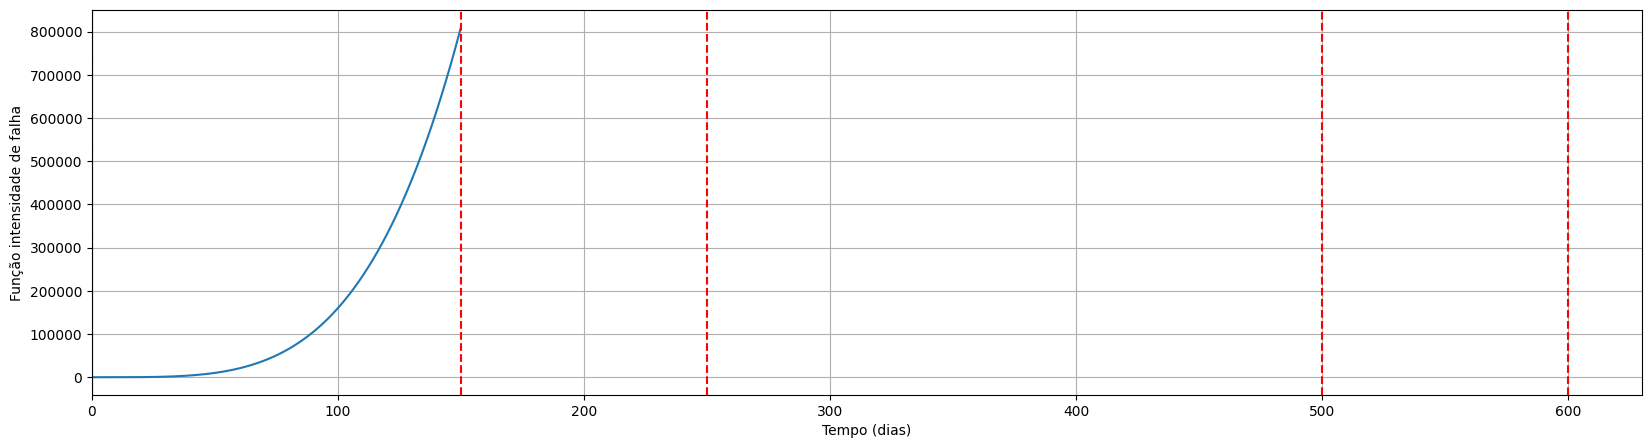

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [151]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [152]:
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:0.25, 3:0.50, 5:0.75, 7:1.0}

    # Criação de variáveis para os parâmetros
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    # Cálculo da intensidade de falha
    # Cria as variaveis
    # tempos de falhas
    t = df['t']
    # indice do sistema
    k = df['k']
    m = df['k'].nunique()
    # Numero de ciclos de manutenção
    ck = df['c'].max()
    # Numero de falhas e severidade das manutenções preventivas em cada sistema
    n = []
    s = []

    if ck == 0:
        return MAX_VALUE_CUSTO

    # Obter o número de ciclos de manutenção
    num_ciclos = ck

    for k in range(m):
        n.append(list(df['n'][k * ck:(k + 1) * ck]))
        s_row = []  # Criar uma nova lista para cada sistema
        for j in range(num_ciclos):
            s_row.append(df['s'][k * ck + j])  # Usar a variável 'j' para obter a severidade correta
        s.append(s_row)

    # Tempos das MP
    T = list(df['T'][:m])

    # Obter os tempos para manutenções preventivas
    tempos_mp = T[1:]

    # Cria alguns cenários de teste
    beta = 5

    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    termos_somatorio = [((1 / (lamb ** beta)) * (T[1] ** beta))]
    numero_medio_falhas = [0, ((1 / (lamb ** beta)) * (T[1] ** beta))]

    for i in range(ck - 1):
        termo = (((T[i + 2] - fator[i] * T[i + 1]) ** beta) - (((1 - fator[i]) * T[i + 1]) ** beta)) * (1 / (lamb ** beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    final = 730
    termo = (((final - fator[ck - 1] * T[ck]) ** beta) - (((1 - fator[ck - 1]) * T[ck]) ** beta)) * (1 / (lamb ** beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    Ctotal = []
    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i + 1] - mi[i]) * CMC) / (T[i + 1] - T[i]))

    cmp = custo_mp(s[0][ck - 1], CMP)
    Ctotal.append((cmp + (mi[ck + 1] - mi[ck]) * CMC) / (final - T[ck]))

    Custo = np.sum(Ctotal)

    print("")
    print("=========================================================================")
    print("")

    print('Media de falhas:', mi)

    print('Fator:', fator)

     # Imprimir o custo total para manutenções preventivas
    print("Custo Total:", Custo)

     # Imprimir o número de ciclos de manutenção
    print("Número de Ciclos de Manutenção:", num_ciclos)

    # Imprimir os tempos para manutenções preventivas
    print("Tempos para Manutenções Preventivas:", tempos_mp)

    # Imprimir os tempos para manutenções preventivas
    print("Número de Sisemas:", m)

    # Imprimir a severidade para cada ciclo de manutenção
    print("=========================================================================")
    print("")
    for k in range(m):

        for i in range(num_ciclos):
            if not np.isnan(s[k][i]):
                print("Severidade para Ciclo de Manutenção", i+1, "do Sistema", k+1, ":", s[k][i])

    return Custo

In [182]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-07-06 01:00:00,260 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   2%|▏         |2/100, best_cost=2.35e+16



Media de falhas: [0, array([1.01497967e+14, 4.62244249e+13, 1.86319528e+13, 1.52151524e+19,
       3.05999267e+12, 1.86187876e+11, 8.44164216e+10, 1.81153825e+15,
       6.74487882e+15, 1.76266173e+12, 1.58094799e+11, 1.20141052e+12,
       1.75040027e+14, 2.74526517e+12, 2.61249067e+11, 3.71478113e+13,
       7.68421730e+10, 7.34314501e+13, 8.21206930e+12, 3.62207180e+11,
       1.89259426e+15, 5.43279925e+19, 3.62028017e+11, 8.56357926e+10]), array([5.21365230e+14, 2.37441288e+14, 9.57068663e+13, 7.81557670e+19,
       1.57182832e+13, 9.56392408e+11, 4.33622352e+11, 9.30533966e+15,
       3.46464605e+16, 9.05427532e+12, 8.12086525e+11, 6.17129279e+12,
       8.99129180e+14, 1.41016205e+13, 1.34195969e+12, 1.90817391e+14,
       3.94715662e+11, 3.77195781e+14, 4.21829868e+13, 1.86055185e+12,
       9.72170057e+15, 2.79066933e+20, 1.85963154e+12, 4.39885902e+11]), array([2.02737978e+16, 1.41670017e+16, 4.29591710e+15, 2.79566417e+21,
       9.66125279e+14, 6.20955798e+13, 1.72178931e

pyswarms.single.global_best:   5%|▌         |5/100, best_cost=8.54e+15



Media de falhas: [0, array([3.40256319e+10, 1.16850366e+10, 9.21290966e+11, 2.03096506e+11,
       1.77266931e+09, 4.76417460e+08, 1.34925169e+08, 4.92516408e+08,
       3.35008415e+08, 2.01533540e+08, 5.37058016e+09, 4.86309901e+10,
       4.91378047e+08, 2.97539781e+11, 3.89296616e+10, 6.57226594e+08,
       3.79704060e+09, 2.41077243e+08, 6.74188505e+09, 2.53051593e+11,
       4.43786263e+08, 7.41539103e+09, 6.35058822e+09, 5.97743255e+09]), array([1.74779673e+11, 6.00225995e+10, 4.73240097e+12, 1.04324707e+12,
       9.10568136e+09, 2.44721649e+09, 6.93070947e+08, 2.52991206e+09,
       1.72083978e+09, 1.03521857e+09, 2.75870921e+10, 2.49803106e+11,
       2.52406463e+09, 1.52837442e+12, 1.99970232e+11, 3.37597988e+09,
       1.95042818e+10, 1.23834295e+09, 3.46310824e+10, 1.29985167e+12,
       2.27959963e+09, 3.80906847e+10, 3.26211055e+10, 3.07043145e+10]), array([7.81950694e+12, 1.69859290e+12, 1.33634184e+14, 3.06209710e+13,
       2.04540742e+11, 3.29727814e+10, 6.32613176e

pyswarms.single.global_best:   8%|▊         |8/100, best_cost=8.54e+15


Media de falhas: [0, array([6.04831132e+09, 2.03549223e+09, 3.22415225e+11, 2.64564202e+10,
       3.28914359e+08, 1.02284251e+08, 2.75143143e+07, 6.66427587e+07,
       4.42452160e+07, 3.33687376e+07, 1.73085387e+09, 1.62723400e+10,
       6.99252022e+07, 1.27064161e+11, 1.82411306e+10, 9.93886587e+07,
       1.32860755e+09, 3.44548574e+07, 1.28917931e+09, 2.12257126e+11,
       5.99017342e+07, 9.39870295e+08, 1.80060624e+09, 2.27211808e+09]), array([3.10683979e+10, 1.04557254e+10, 1.65615227e+12, 1.35898856e+11,
       1.68953641e+09, 5.25404143e+08, 1.41332947e+08, 3.42324268e+08,
       2.27274673e+08, 1.71405399e+08, 8.89088774e+09, 8.35862289e+10,
       3.59185216e+08, 6.52691259e+11, 9.36993278e+10, 5.10530334e+08,
       6.82466655e+09, 1.76984478e+08, 6.62213530e+09, 1.09030249e+12,
       3.07697606e+08, 4.82783752e+09, 9.24918516e+09, 1.16712029e+10]), array([1.07848086e+12, 1.77754713e+11, 7.51585714e+13, 5.33046264e+12,
       1.77607872e+10, 3.67690323e+09, 8.19196738e+

pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=8.54e+15


Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([1.19642730e+10, 4.23499089e+09, 4.83705498e+11, 4.66764382e+10,
       5.58873537e+08, 1.73410738e+08, 5.68259422e+07, 9.69965691e+07,
       9.32618970e+07, 4.90575394e+07, 2.42359997e+09, 2.86099980e+10,
       1.64929685e+08, 1.48600939e+11, 2.12452657e+10, 1.98454075e+08,
       1.93750501e+09, 6.93095859e+07, 2.62604072e+09, 2.23268186e+11,
       9.36689459e+07, 2.02489566e+09, 2.76056634e+09, 3.56328567e+09]), array([6.14569545e+10, 2.17539038e+

pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=8.54e+15

0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Ma

pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=8.46e+15

 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([6.26055072e+09, 1.55537908e+09, 3.40570820e+11, 3.55444652e+10,
       2.89260635e+08, 8.67800906e+07, 2.88451149e+07, 6.23369479e+07,
       5.96356899e+07, 3.43775325e+07, 1.81642487e+09, 1.58726613e+10,
       7.07170088e+07, 1.24860976e+11, 2.08035400e+10, 1.01111043e+08,
       1.51338979e+09, 3.47957971e+07, 1.26407628e+09, 2.14886994e+11,
       4.95482297e+07, 1.18785916e+09, 2.04945377e+09, 1.79521889e+09]), array([3.21586093e+10, 7.98952528e+09, 1.74941222e+12, 1.82581473e+11,
       1.48584688e+09, 4.45763825e+08, 1.48168879e+08, 3.20206583e+08,
       3.06331015e+08, 1.76587282e+08, 9.33044077e+09, 8.15331967e+10,
       3.63252494e+08, 6.413741

pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=8.46e+15

2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([6.08123109e+09, 1.02064525e+09, 3.37837047e+11, 4.20799954e+10,
       2.84262039e+08, 8.04056035e+07, 2.91

pyswarms.single.global_best:  25%|██▌       |25/100, best_cost=8.46e+15


Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([6.43505100e+09, 2.43655144e+09, 3.48548901e+11, 2.36638184e+10,
       3.20627273e+08, 9.54433644e+07, 2.84520301e+07, 6.63706993e+07,
       5.73497908e+07, 3.41764198e+07, 1.80763115e+09, 1.57053297e+10,
       7.30215791e+07, 1.20885054e+11, 2.64767462e+10, 1.50318436e+08,
       1.52475227e+09, 3.58788803e+07, 1.64880689e+09, 2.16012032e+11,
       5.69441456e+07, 1.17213336e+09, 1.96538811e+09, 1.91602902e+09]), array([3.30549660e+10, 1.25158488e+10, 1.79039328e+12, 1.21554082e+11,
       1.64696808e+09, 4.90264517e+08, 1.46149718e+08, 3.40926779e+08,
       2.94589023e+08, 1.75554226e+08, 9.28527003e+09, 8.06736638e+10,
       3.75090394e+08, 6.20951000e+11, 1.36003265e+11, 7.72141632e+08,
       7.83220436e+09, 1.84299265e+08, 8.46943650e+09, 1.10959033e+12,
       2.92505343e+08, 6.02090461e+09, 1.00956212e+10, 9.84207807e+09]), array(

pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=8.17e+15

1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([6.34717176e+09, 1.14601191e+09, 3.34616396e+11, 5.55850511e+10,
       2.66492561e+08, 7.99688976e+07, 2.92004429e+07, 5.73762235e+07,
       6.18390243e+07, 3.45144770e+07, 1.82262474e+09, 1.59636772e+10,
       6.88276132e+07, 1.28309555e+11, 1.74836632e+10, 7.34729527e+07,
       1.50326087e+09, 3.43087622e+07, 1.0110

pyswarms.single.global_best:  36%|███▌      |36/100, best_cost=7.98e+15

 7982185694233263.0
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Sev

pyswarms.single.global_best:  40%|████      |40/100, best_cost=7.98e+15

 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([6.13105228e+09, 1.58172153e+09, 3.42630473e+11, 4.23629158e+10,
       3.09650037e+08, 8.25261624e+07, 2.91222487e+07, 6.30686383e+07,
       6.11322088e+07, 3.44072235e+07, 1.82178521e+09, 1.60631095e+10,
       7.09552165e+07, 1.28129077e+11, 2.21152144e+10, 8.88845611e+07,
       1.51541031e+09, 3.39190979e+07, 1.35740150e+09, 2.15575399e+11,
       5.41805146e+07, 1.22398005e+09, 2.13013447e+09, 1.69744290e+09]), array([3.14934139e+10, 8.12483869e+09, 1.75999206e+12, 2.17605850e+11,
       1.59058125e+09, 4.23912645e+08, 1.49592434e+08, 3.23965062e+08,
       3.14018193e+08, 1.76739796e+08, 9.35797526e+09, 8.25114733e+10,
       3.64476097e+08, 6.58161416e+11, 1.13599358e+11, 4.56573871e+08,
       7.78421744e+09, 1.74232439e+08, 6.97257265e+09, 1.10734748e+12,
       2.78309382e+08, 6.28722583e+09, 1.09418748e+10, 8.71926540e+09]), ar

pyswarms.single.global_best:  43%|████▎     |43/100, best_cost=7.96e+15


Custo Total: 7988630231524997.0
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistem

pyswarms.single.global_best:  47%|████▋     |47/100, best_cost=7.96e+15



Media de falhas: [0, array([5.97435532e+09, 1.77466297e+09, 3.45718885e+11, 4.10340989e+10,
       3.63175379e+08, 8.17643652e+07, 2.91026985e+07, 6.40832914e+07,
       6.02433182e+07, 3.44711880e+07, 1.81687774e+09, 1.61108682e+10,
       7.13000717e+07, 1.27554087e+11, 1.93068205e+10, 8.50192880e+07,
       1.51151410e+09, 3.38290501e+07, 1.68923195e+09, 2.15485106e+11,
       4.82243012e+07, 1.22286462e+09, 2.13123655e+09, 1.70112111e+09]), array([3.06885077e+10, 9.11592218e+09, 1.77585632e+12, 2.10780108e+11,
       1.86552520e+09, 4.19999517e+08, 1.49492010e+08, 3.29177037e+08,
       3.09452223e+08, 1.77068363e+08, 9.33276707e+09, 8.27567955e+10,
       3.66247516e+08, 6.55207865e+11, 9.91734636e+10, 4.36719099e+08,
       7.76420378e+09, 1.73769889e+08, 8.67708816e+09, 1.10688367e+12,
       2.47714064e+08, 6.28149619e+09, 1.09475359e+10, 8.73815926e+09]), array([5.64476726e+11, 1.47169067e+11, 7.21950551e+13, 6.43206922e+12,
       1.93231148e+10, 3.26378002e+09, 9.16410806e

pyswarms.single.global_best:  50%|█████     |50/100, best_cost=7.96e+15



Media de falhas: [0, array([6.04863381e+09, 1.49889912e+09, 3.40445112e+11, 4.53241081e+10,
       3.26221406e+08, 8.07555907e+07, 2.91798943e+07, 6.30289726e+07,
       6.04987806e+07, 3.44817780e+07, 1.81896736e+09, 1.60615080e+10,
       7.03619505e+07, 1.27976166e+11, 1.88319651e+10, 8.00013499e+07,
       1.51030017e+09, 3.38941711e+07, 1.38293613e+09, 2.14820059e+11,
       4.94636746e+07, 1.21804749e+09, 2.12714774e+09, 1.69869278e+09]), array([3.10700545e+10, 7.69940434e+09, 1.74876650e+12, 2.32816625e+11,
       1.67570350e+09, 4.14817739e+08, 1.49888542e+08, 3.23761311e+08,
       3.10764458e+08, 1.77122761e+08, 9.34350080e+09, 8.25032469e+10,
       3.61428664e+08, 6.57375960e+11, 9.67342708e+10, 4.10943426e+08,
       7.75796815e+09, 1.74104397e+08, 7.10373650e+09, 1.10346752e+12,
       2.54080361e+08, 6.25675202e+09, 1.09265329e+10, 8.72568566e+09]), array([6.26549158e+11, 1.20103056e+11, 7.12081945e+13, 7.09428265e+12,
       1.72195859e+10, 3.12500526e+09, 8.83525341e

pyswarms.single.global_best:  54%|█████▍    |54/100, best_cost=7.96e+15


Custo Total: 8643716980344027.0
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistem

pyswarms.single.global_best:  58%|█████▊    |58/100, best_cost=7.96e+15

: 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([6.06805622e+09, 1.54428771e+09, 3.43662522e+11, 4.42177730e+10,
       3.38178622e+08, 8.06639162e+07, 2.91793870e+07, 6.22827922e+07,
       6.06543347e+07, 3.44812218e+07, 1.81878826e+09, 1.60701534e+10,
       7.04128519e+07, 1.28110616e+11, 1.89076387e+10, 8.04611015e+07,
       1.51060209e+09, 3.39073991e+07, 1.33581577e+09, 2.14830421e+11,
       4.88713877e+07, 1.21936429e+09, 2.12788802e+09, 1.69803572e+09]), array([3.11698217e+10, 7.93255218e+09, 1.76529339e+12, 2.27133707e+11,
       1.73712420e+09, 4.14346834e+08, 1.49885937e+08, 3.19928401e+08,
       3.11563494e+08, 1.77119904e+08, 9.34258081e+09, 8.25

pyswarms.single.global_best:  61%|██████    |61/100, best_cost=7.96e+15

2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([5.97466119e+09, 1.75426332e+09, 3.42623451e+11, 4.33633214e+10,
       3.36846889e+08, 8.16946769e+07, 2.91403614e+07, 6.40124994e+07,
       6.05842635e+07, 3.44728488e+07, 1.81817331e+09, 1.60847911e+10,
       7.07082326e+07, 1.27704485e+11, 1.89752754e+10, 8.24448422e+07,
       1.51089426e+09, 3.38656755e+07, 1.45644599e+09, 2.15085884e+11,
       4.91505231e+07, 1.22162401e+09, 2.12999253e+09, 1.69984507e+09]), array([3.06900788e+10, 9.01113516e+09, 1.75995599e+12, 2.22744640e+11,
       1.73028349e+09, 4.19641549e+08, 1.49685473e+08, 3.28813399e+08,
       3.11203559e+08, 1.77076894e+08, 9.339

pyswarms.single.global_best:  67%|██████▋   |67/100, best_cost=7.96e+15

 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([6.04551778e+09, 1.58719520e+09, 3.45328228e+11, 4

pyswarms.single.global_best:  70%|███████   |70/100, best_cost=7.96e+15



Media de falhas: [0, array([6.05589420e+09, 1.55076043e+09, 3.42672069e+11, 4.44468348e+10,
       3.40058084e+08, 8.09634827e+07, 2.91708283e+07, 6.27137011e+07,
       6.04185573e+07, 3.44801610e+07, 1.81832066e+09, 1.60719185e+10,
       7.05630157e+07, 1.27982977e+11, 1.89498172e+10, 8.13962795e+07,
       1.51048300e+09, 3.38838127e+07, 1.39425197e+09, 2.15088267e+11,
       4.90945932e+07, 1.21750333e+09, 2.12859865e+09, 1.69838517e+09]), array([3.11073490e+10, 7.96580064e+09, 1.76020572e+12, 2.28310329e+11,
       1.74677845e+09, 4.15885619e+08, 1.49841973e+08, 3.22141854e+08,
       3.10352374e+08, 1.77114455e+08, 9.34017893e+09, 8.25567225e+10,
       3.62461476e+08, 6.57410944e+11, 9.73396423e+10, 4.18108769e+08,
       7.75890731e+09, 1.74051189e+08, 7.16186267e+09, 1.10484523e+12,
       2.52184499e+08, 6.25395684e+09, 1.09339858e+10, 8.72410553e+09]), array([6.52782753e+11, 1.26757023e+11, 7.17192441e+13, 6.95771099e+12,
       1.78973662e+10, 3.15305343e+09, 9.17068939e

pyswarms.single.global_best:  72%|███████▏  |72/100, best_cost=7.96e+15

 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([6.00294701e+09, 1.71110987e+09, 3.43590292e+11, 4.31856764e+10,
       3.43059640e+08, 8.13867984e+07, 2.91274480e+07, 6.39402564e+07,
       6.07459834e+07, 3.44751936e+07, 1.81782671e+09, 1.60850920e+10,
       7.06805177e

pyswarms.single.global_best:  77%|███████▋  |77/100, best_cost=7.96e+15



Media de falhas: [0, array([6.04617298e+09, 1.61709368e+09, 3.44951296e+11, 4.34923692e+10,
       3.47320044e+08, 8.11230783e+07, 2.91547467e+07, 6.23927494e+07,
       6.04880330e+07, 3.44787777e+07, 1.81799000e+09, 1.60796299e+10,
       7.06289424e+07, 1.28017049e+11, 1.90640934e+10, 8.16236393e+07,
       1.51072072e+09, 3.38855224e+07, 1.43408178e+09, 2.15259367e+11,
       4.86711850e+07, 1.22068651e+09, 2.12922664e+09, 1.69889880e+09]), array([3.10574139e+10, 8.30653504e+09, 1.77191344e+12, 2.23407520e+11,
       1.78408100e+09, 4.16705415e+08, 1.49759367e+08, 3.20493220e+08,
       3.10709251e+08, 1.77107349e+08, 9.33848041e+09, 8.25963340e+10,
       3.62800122e+08, 6.57585962e+11, 9.79266458e+10, 4.19276649e+08,
       7.76012839e+09, 1.74059971e+08, 7.36645670e+09, 1.10572411e+12,
       2.50009575e+08, 6.27030789e+09, 1.09372116e+10, 8.72674391e+09]), array([6.25378215e+11, 1.32579647e+11, 7.21400686e+13, 6.80532746e+12,
       1.86618069e+10, 3.13994031e+09, 9.02454221e

pyswarms.single.global_best:  84%|████████▍ |84/100, best_cost=7.96e+15



Media de falhas: [0, array([5.99944886e+09, 1.63571454e+09, 3.42061522e+11, 4.36178692e+10,
       3.38294620e+08, 8.12447744e+07, 2.91546768e+07, 6.36702482e+07,
       6.06693890e+07, 3.44754799e+07, 1.81807386e+09, 1.60757824e+10,
       7.05862257e+07, 1.27811833e+11, 1.89704158e+10, 8.19302100e+07,
       1.51068488e+09, 3.38739612e+07, 1.51178974e+09, 2.14959556e+11,
       4.91584371e+07, 1.21964431e+09, 2.12911200e+09, 1.69868907e+09]), array([3.08174058e+10, 8.40218491e+09, 1.75706952e+12, 2.24052177e+11,
       1.73772006e+09, 4.17330532e+08, 1.49759008e+08, 3.27055356e+08,
       3.11640824e+08, 1.77090409e+08, 9.33891115e+09, 8.25765700e+10,
       3.62580700e+08, 6.56531828e+11, 9.74454514e+10, 4.20851413e+08,
       7.75994430e+09, 1.74000585e+08, 7.76561965e+09, 1.10418407e+12,
       2.52512446e+08, 6.26495442e+09, 1.09366227e+10, 8.72566660e+09]), array([5.82380714e+11, 1.33656922e+11, 7.15352204e+13, 6.84239131e+12,
       1.76029370e+10, 3.21780621e+09, 9.21183513e

pyswarms.single.global_best:  87%|████████▋ |87/100, best_cost=7.96e+15

: 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([6.03546697e+09, 1.61999234e+09, 3.43356997e+11, 4.39502432e+10,
       3.45187565e+08, 8.11641490e+07, 2.91573097e+07, 6.29208936e+07,
       6.05478847e+07, 3.44777988e+07, 1.81817077e+09, 1.60790174e+10,
       7.06427124e+07, 1.27950273e+11, 1.90517647e+10, 8.15784794e+07,
       1.51067719e+09, 3.38833598e+07, 1.44661394e+09, 2.15148012e+11,
       4.88318471e+07, 1.22029650e+09, 2.12894629e+09, 1.69898337e+09]), array([3.10024203e+10, 8.32142463e+09, 1.76372400e+12, 2.25759484e+11,
       1.77312709e+09, 4.16916383e+08, 1.49772532e+08, 3.23206141e+08,
       3.11016692e+08, 1.77102321e+08, 9.33940896e+09, 8.25931874e+10,
       3.62870855e+08, 6.57242953e+11, 9.7863

pyswarms.single.global_best:  90%|█████████ |90/100, best_cost=7.96e+15


Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Media de falhas: [0, array([6.00703307e+09, 1.62932994e+09, 3.42734444e+11, 4.36590760e+10,
       3.41637502e+08, 8.12605517e+07, 2.91500711e+07, 6.38218509e+07,
       6.05906568e+07, 3.44764334e+07, 1.81813308e+09, 1.60770338e+10,
       7.05676061e+07, 1.27837793e+11, 1.89820925e+10, 8.20406605e+07,
       1.51072328e+09, 3.38728646e+07, 1.49489038e+09, 2.15013385

pyswarms.single.global_best:  92%|█████████▏|92/100, best_cost=7.95e+15


Media de falhas: [0, array([6.01561926e+09, 1.65638142e+09, 3.43945898e+11, 4.34064544e+10,
       3.39858866e+08, 8.12686508e+07, 2.91392631e+07, 6.26110378e+07,
       6.06442112e+07, 3.44760430e+07, 1.81783713e+09, 1.60827045e+10,
       7.06417449e+07, 1.27872378e+11, 1.90267711e+10, 8.24064624e+07,
       1.51079877e+09, 3.38837436e+07, 1.49505412e+09, 2.15156876e+11,
       4.87717012e+07, 1.22252417e+09, 2.12945590e+09, 1.69927179e+09]), array([3.09004684e+10, 8.50834461e+09, 1.76674901e+12, 2.22966201e+11,
       1.74575512e+09, 4.17453178e+08, 1.49679832e+08, 3.21614503e+08,
       3.11511493e+08, 1.77093302e+08, 9.33769517e+09, 8.26121269e+10,
       3.62865885e+08, 6.56842829e+11, 9.77349318e+10, 4.23297782e+08,
       7.76052935e+09, 1.74050834e+08, 7.67965367e+09, 1.10519765e+12,
       2.50525897e+08, 6.27974744e+09, 1.09383892e+10, 8.72865985e+09]), array([6.09302678e+11, 1.34332316e+11, 7.17898353e+13, 6.79067573e+12,
       1.76514186e+10, 3.16915452e+09, 9.27381610e+

pyswarms.single.global_best:  96%|█████████▌|96/100, best_cost=7.95e+15



Media de falhas: [0, array([6.03519256e+09, 1.64850042e+09, 3.44672328e+11, 4.37954234e+10,
       3.40818900e+08, 8.11588485e+07, 2.91471752e+07, 6.22663585e+07,
       6.05779268e+07, 3.44766985e+07, 1.81804887e+09, 1.60816727e+10,
       7.07214825e+07, 1.27943443e+11, 1.90934061e+10, 8.21540863e+07,
       1.51077045e+09, 3.38882194e+07, 1.45792232e+09, 2.15225361e+11,
       4.87126456e+07, 1.22167974e+09, 2.12913351e+09, 1.69930777e+09]), array([3.10010107e+10, 8.46786226e+09, 1.77048047e+12, 2.24964221e+11,
       1.75068654e+09, 4.16889156e+08, 1.49720474e+08, 3.19843986e+08,
       3.11171009e+08, 1.77096669e+08, 9.33878280e+09, 8.26068271e+10,
       3.63275474e+08, 6.57207872e+11, 9.80772164e+10, 4.22001400e+08,
       7.76038387e+09, 1.74073825e+08, 7.48891856e+09, 1.10554943e+12,
       2.50222546e+08, 6.27540985e+09, 1.09367332e+10, 8.72884464e+09]), array([6.19003766e+11, 1.32694695e+11, 7.22809384e+13, 6.84123239e+12,
       1.82676353e+10, 3.15887609e+09, 9.01359365e

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=7.95e+15
2023-07-06 01:00:06,780 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66002916 2.14995426 0.73913219 1.1175686  2.94941278 3.9278395
 4.82153772 4.13966546 4.16461011 4.66215956 2.10948402 1.3640237
 4.03870169 0.900975   1.31855658 3.91741135 2.18902447 4.6782985
 2.19857121 0.81194691 4.3501229  2.2838279  2.04382086 2.13814868]
2023-07-06 01:00:06,782 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Fator: [0.3296799539643607, array([0.49692654, 0.57504123, 0.25623206, 0.36016034, 0.6943881 ,
       0.78910779, 0.85724853, 0.81338585, 0.81278774, 0.84506422,
       0.57282631, 0.41663152, 0.78355558, 0.30952111, 0.41057271,
       0.78346554, 0.59167992, 0.84620445, 0.58468946, 0.35332226,
       0.82869981, 0.61309818, 0.56998802, 0.59218825]), array([0.57631874, 0.6568899 , 0.30928829, 0.42774586, 0.77277149,
       0.8570857 , 0.91225432, 0.87734629, 0.8768547 , 0.90279477,
       0.65465305, 0.49016612, 0.85236716, 0.37058367, 0.48353869,
       0.85229038, 0.67359942, 0.90368815, 0.66659954, 0.42009095,
       0.88979601, 0.69485872, 0.65178242, 0.67410727]), array([0.7868572 , 0.85419235, 0.48627077, 0.6338491 , 0.93055626,
       0.96986049, 0.98747418, 0.97711108, 0.97694569, 0.98493943,
       0.85247687, 0.70257898, 0.9680457 , 0.56540131, 0.69558361,
       0.96801578, 0.86672409, 0.98518767, 0.86153528, 0.62498573,
       0.98112204, 0.88194028, 0.85026227, 0.86709711

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:06,812 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66005623 2.14930799 0.7391426  1.11919401 2.95010086 3.92731969
 4.8216678  4.13849697 4.1642449  4.6621651  2.10951087 1.36401809
 4.03945149 0.90102221 1.31910719 3.91687293 2.18902334 4.67833991
 2.19450921 0.8119474  4.34945009 2.28371477 2.04380299 2.1381506 ]
2023-07-06 01:00:06,814 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02340831e+09, 1.65562901e+09, 3.44203370e+11, 4.32443543e+10,
       3.39838027e+08, 8.12783764e+07, 2.91386796e+07, 6.25522721e+07,
       6.06422048e+07, 3.44760935e+07, 1.81780568e+09, 1.60825772e+10,
       7.06064391e+07, 1.27872986e+11, 1.90132281e+10, 8.23680686e+07,
       1.51079083e+09, 3.38842154e+07, 1.49200148e+09, 2.15187390e+11,
       4.87848007e+07, 1.22249471e+09, 2.12941911e+09, 1.69927960e+09]), array([3.09404785e+10, 8.50447973e+09, 1.76807157e+12, 2.22133540e+11,
       1.74564808e+09, 4.17503136e+08, 1.49676835e+08, 3.21312640e+08,
       3.11501186e+08, 1.77093562e+08, 9.33753359e+09, 8.26114729e+10,
       3.62684530e+08, 6.56845955e+11, 9.76653655e+10, 4.23100564e+08,
       7.76048852e+09, 1.74053257e+08, 7.66397316e+09, 1.10535439e+12,
       2.50593186e+08, 6.27959608e+09, 1.09382002e+10, 8.72869996e+09]), array([6.26756024e+11, 1.33189087e+11, 7.19961729e+13, 6.76265999e+12,
       1.77801689e+10, 3.15343332e+09, 9.03420028e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:06,838 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65978071 2.14982766 0.7390485  1.11882038 2.94971851 3.92737949
 4.8216901  4.13910968 4.16419307 4.66216081 2.10950691 1.36402064
 4.03939283 0.90101784 1.31898879 3.91753976 2.18902519 4.67830828
 2.194884   0.81193386 4.3495347  2.28379606 2.04380883 2.13814901]
2023-07-06 01:00:06,839 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02840922e+09, 1.65362892e+09, 3.44422575e+11, 4.33166084e+10,
       3.40058336e+08, 8.12721886e+07, 2.91380059e+07, 6.25059876e+07,
       6.06459788e+07, 3.44762523e+07, 1.81782276e+09, 1.60824271e+10,
       7.06115661e+07, 1.27876092e+11, 1.90217633e+10, 8.22979907e+07,
       1.51078442e+09, 3.38853606e+07, 1.49072808e+09, 2.15205334e+11,
       4.87800561e+07, 1.22227716e+09, 2.12938866e+09, 1.69928590e+09]), array([3.09661667e+10, 8.49420584e+09, 1.76919756e+12, 2.22504689e+11,
       1.74677974e+09, 4.17471351e+08, 1.49673374e+08, 3.21074890e+08,
       3.11520572e+08, 1.77094377e+08, 9.33762132e+09, 8.26107020e+10,
       3.62710866e+08, 6.56861907e+11, 9.77092082e+10, 4.22740595e+08,
       7.76045561e+09, 1.74059140e+08, 7.65743209e+09, 1.10544656e+12,
       2.50568814e+08, 6.27847858e+09, 1.09380438e+10, 8.72873233e+09]), array([6.34060499e+11, 1.32979428e+11, 7.20498272e+13, 6.77248330e+12,
       1.78005538e+10, 3.14516033e+09, 9.15958172e

pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.03236191e+09, 1.65176719e+09, 3.44612517e+11, 4.34260389e+10,
       3.40275422e+08, 8.12530374e+07, 2.91382240e+07, 6.24572013e+07,
       6.06447896e+07, 3.44764036e+07, 1.81784715e+09, 1.60822603e+10,
       7.06308126e+07, 1.27879395e+11, 1.90368788e+10, 8.22369836e+07,
       1.51077935e+09, 3.38864362e+07, 1.48917551e+09, 2.15218348e+11,
       4.87724658e+07, 1.22207992e+09, 2.12935292e+09, 1.69929174e+09]), array([3.09864705e+10, 8.48464270e+09, 1.77017324e+12, 2.23066801e+11,
       1.74789485e+09, 4.17372977e+08, 1.49674494e+08, 3.20824290e+08,
       3.11514463e+08, 1.77095154e+08, 9.33774664e+09, 8.26098455e+10,
       3.62809729e+08, 6.56878872e+11, 9.77868525e+10, 4.22427219e+08,
       7.76042958e+09, 1.74064665e+08, 7.64945699e+09, 1.10551341e+12,
       2.50529825e+08, 6.27746542e+09, 1.09378602e+10, 8.72876235e+09]), array([6.42119385e+11, 1.32674039e+11, 7.20998469e+13, 6.78530558e+12,
       1.79192241e+10, 3.12770053e+09, 9.19430343e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:06,860 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65956314 2.15031207 0.73896701 1.11825594 2.94934205 3.92756461
 4.82168288 4.1397561  4.1642094  4.66215671 2.10950125 1.36402347
 4.03917266 0.90101318 1.31877926 3.91812083 2.18902666 4.67827858
 2.19534147 0.81192404 4.34967007 2.28386978 2.04381569 2.13814754]
2023-07-06 01:00:06,862 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.03400072e+09, 1.65023681e+09, 3.44694530e+11, 4.35546728e+10,
       3.40469287e+08, 8.12346858e+07, 2.91394796e+07, 6.24142828e+07,
       6.06407995e+07, 3.44765190e+07, 1.81788588e+09, 1.60821083e+10,
       7.06516987e+07, 1.27888770e+11, 1.90538091e+10, 8.21834298e+07,
       1.51077543e+09, 3.38872536e+07, 1.48626408e+09, 2.15229393e+11,
       4.87609238e+07, 1.22190464e+09, 2.12931790e+09, 1.69929608e+09]), array([3.09948886e+10, 8.47678159e+09, 1.77059451e+12, 2.23727556e+11,
       1.74889068e+09, 4.17278710e+08, 1.49680944e+08, 3.20603830e+08,
       3.11493968e+08, 1.77095747e+08, 9.33794555e+09, 8.26090645e+10,
       3.62917015e+08, 6.56927029e+11, 9.78738185e+10, 4.22152129e+08,
       7.76040943e+09, 1.74068864e+08, 7.63450181e+09, 1.10557014e+12,
       2.50470537e+08, 6.27656506e+09, 1.09376803e+10, 8.72878462e+09]), array([6.49406819e+11, 1.32388062e+11, 7.21477403e+13, 6.80055361e+12,
       1.80687154e+10, 3.10622184e+09, 9.16500897e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:07,052 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65947299 2.15071074 0.73893184 1.11759463 2.9490061  3.92774205
 4.82164133 4.14032528 4.1642642  4.66215359 2.10949226 1.36402604
 4.03893382 0.90099997 1.31854482 3.91863133 2.1890278  4.67825601
 2.19620089 0.81191571 4.34987597 2.2839353  2.04382242 2.13814645]
2023-07-06 01:00:07,054 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.03358199e+09, 1.64968166e+09, 3.44688625e+11, 4.36711559e+10,
       3.40637820e+08, 8.12171481e+07, 2.91413967e+07, 6.23893911e+07,
       6.06301095e+07, 3.44765721e+07, 1.81792818e+09, 1.60819806e+10,
       7.06720052e+07, 1.27900648e+11, 1.90688104e+10, 8.21465184e+07,
       1.51077436e+09, 3.38879004e+07, 1.48241119e+09, 2.15232334e+11,
       4.87480505e+07, 1.22181129e+09, 2.12928754e+09, 1.69929828e+09]), array([3.09927377e+10, 8.47392990e+09, 1.77056418e+12, 2.24325895e+11,
       1.74975639e+09, 4.17188624e+08, 1.49690791e+08, 3.20475969e+08,
       3.11439056e+08, 1.77096020e+08, 9.33816285e+09, 8.26084086e+10,
       3.63021323e+08, 6.56988043e+11, 9.79508756e+10, 4.21962526e+08,
       7.76040393e+09, 1.74072186e+08, 7.61471066e+09, 1.10558525e+12,
       2.50404411e+08, 6.27608557e+09, 1.09375244e+10, 8.72879590e+09]), array([6.55841177e+11, 1.32125860e+11, 7.21860747e+13, 6.81431539e+12,
       1.82588338e+10, 3.08685070e+09, 9.08399542e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:07,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65949602 2.15085548 0.73893437 1.11699781 2.94871423 3.92791166
 4.82157789 4.1406556  4.16441103 4.66215216 2.10948244 1.36402821
 4.03870169 0.90098324 1.3183373  3.91898343 2.18902811 4.67823815
 2.19734132 0.81191349 4.35010569 2.28397019 2.04382825 2.13814589]
2023-07-06 01:00:07,078 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:07,101 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65967539 2.15084419 0.73898503 1.11659578 2.94859109 3.92805465
 4.82151555 4.14074694 4.1645462  4.66215108 2.10947397 1.36402931
 4.03849277 0.90096721 1.31819669 3.9189071  2.18902778 4.67823756
 2.19846556 0.81191551 4.35031537 2.2839609  2.04383146 2.13814605]
2023-07-06 01:00:07,102 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.03032232e+09, 1.64972496e+09, 3.44570497e+11, 4.37498308e+10,
       3.40708956e+08, 8.12023674e+07, 2.91432805e+07, 6.23825101e+07,
       6.06202707e+07, 3.44766120e+07, 1.81796466e+09, 1.60819158e+10,
       7.06902870e+07, 1.27912020e+11, 1.90789823e+10, 8.21545179e+07,
       1.51077550e+09, 3.38879221e+07, 1.47862472e+09, 2.15229652e+11,
       4.87363038e+07, 1.22183616e+09, 2.12927079e+09, 1.69929766e+09]), array([3.09759937e+10, 8.47415233e+09, 1.76995739e+12, 2.24730025e+11,
       1.75012179e+09, 4.17112700e+08, 1.49700468e+08, 3.20440623e+08,
       3.11388517e+08, 1.77096225e+08, 9.33835025e+09, 8.26080756e+10,
       3.63115232e+08, 6.57046461e+11, 9.80031257e+10, 4.22003617e+08,
       7.76040982e+09, 1.74072298e+08, 7.59526071e+09, 1.10557148e+12,
       2.50344071e+08, 6.27621333e+09, 1.09374384e+10, 8.72879273e+09]), array([6.58980511e+11, 1.31927826e+11, 7.22261544e+13, 6.82313843e+12,
       1.84709709e+10, 3.07062051e+09, 8.97812246e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02715141e+09, 1.65012017e+09, 3.44361505e+11, 4.38059292e+10,
       3.40643207e+08, 8.11923473e+07, 2.91448342e+07, 6.23786272e+07,
       6.06113185e+07, 3.44766048e+07, 1.81798482e+09, 1.60818924e+10,
       7.07062796e+07, 1.27922036e+11, 1.90849959e+10, 8.21648377e+07,
       1.51077754e+09, 3.38876781e+07, 1.47517011e+09, 2.15221790e+11,
       4.87265907e+07, 1.22196002e+09, 2.12926331e+09, 1.69929517e+09]), array([3.09597057e+10, 8.47618244e+09, 1.76888386e+12, 2.25018186e+11,
       1.74978406e+09, 4.17061229e+08, 1.49708449e+08, 3.20420678e+08,
       3.11342533e+08, 1.77096188e+08, 9.33845379e+09, 8.26079555e+10,
       3.63197381e+08, 6.57097909e+11, 9.80340155e+10, 4.22056627e+08,
       7.76042029e+09, 1.74071044e+08, 7.57751535e+09, 1.10553109e+12,
       2.50294178e+08, 6.27684955e+09, 1.09374000e+10, 8.72877996e+09]), array([6.59491603e+11, 1.31802536e+11, 7.22478267e+13, 6.82890826e+12,
       1.86585981e+10, 3.06239769e+09, 8.85927718e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:07,263 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65984998 2.15074115 0.73907471 1.11630965 2.94870491 3.92815159
 4.82146414 4.14079849 4.16466922 4.66215127 2.1094693  1.36402971
 4.03831007 0.90095311 1.31811361 3.91880866 2.18902718 4.67824429
 2.19949429 0.81192144 4.35048879 2.28391459 2.04383289 2.13814668]
2023-07-06 01:00:07,265 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.02357004e+09, 1.65065346e+09, 3.44160437e+11, 4.37847315e+10,
       3.40503156e+08, 8.11914199e+07, 2.91456086e+07, 6.23948233e+07,
       6.06043822e+07, 3.44765885e+07, 1.81799360e+09, 1.60819045e+10,
       7.07194384e+07, 1.27929801e+11, 1.90896287e+10, 8.22035400e+07,
       1.51078092e+09, 3.38870177e+07, 1.47282999e+09, 2.15207606e+11,
       4.87178888e+07, 1.22210700e+09, 2.12926492e+09, 1.69929213e+09]), array([3.09413092e+10, 8.47892179e+09, 1.76785103e+12, 2.24909299e+11,
       1.74906465e+09, 4.17056466e+08, 1.49712427e+08, 3.20503873e+08,
       3.11306903e+08, 1.77096104e+08, 9.33849892e+09, 8.26080175e+10,
       3.63264974e+08, 6.57137793e+11, 9.80578131e+10, 4.22255429e+08,
       7.76043764e+09, 1.74067652e+08, 7.56549487e+09, 1.10545823e+12,
       2.50249479e+08, 6.27760456e+09, 1.09374082e+10, 8.72876433e+09]), array([6.58281830e+11, 1.31755051e+11, 7.22568237e+13, 6.82566720e+12,
       1.87703786e+10, 3.05769015e+09, 8.76043966e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:07,285 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66004731 2.15060216 0.73916104 1.11641772 2.94894743 3.92816057
 4.82143852 4.1405835  4.16476454 4.66215171 2.10946726 1.3640295
 4.03815978 0.90094217 1.31804963 3.91843958 2.18902621 4.67826253
 2.20019278 0.81193214 4.35064419 2.28385965 2.04383259 2.13814744]
2023-07-06 01:00:07,286 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02042090e+09, 1.65156156e+09, 3.43994681e+11, 4.37353246e+10,
       3.40330461e+08, 8.11955180e+07, 2.91456193e+07, 6.24284219e+07,
       6.05996777e+07, 3.44765213e+07, 1.81799759e+09, 1.60820059e+10,
       7.07284541e+07, 1.27935213e+11, 1.90835077e+10, 8.22635664e+07,
       1.51078413e+09, 3.38862640e+07, 1.47124308e+09, 2.15192177e+11,
       4.87187182e+07, 1.22224955e+09, 2.12927099e+09, 1.69928797e+09]), array([3.09251331e+10, 8.48358641e+09, 1.76699959e+12, 2.24655511e+11,
       1.74817757e+09, 4.17077516e+08, 1.49712482e+08, 3.20676459e+08,
       3.11282737e+08, 1.77095759e+08, 9.33851938e+09, 8.26085387e+10,
       3.63311285e+08, 6.57165597e+11, 9.80263715e+10, 4.22563767e+08,
       7.76045414e+09, 1.74063781e+08, 7.55734336e+09, 1.10537898e+12,
       2.50253739e+08, 6.27833678e+09, 1.09374394e+10, 8.72874295e+09]), array([6.54925502e+11, 1.31767510e+11, 7.22502937e+13, 6.81919287e+12,
       1.88410561e+10, 3.06175075e+09, 8.69209142e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:07,311 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66022094 2.15036561 0.73923226 1.11666984 2.94924665 3.92812091
 4.82143817 4.14013772 4.16482921 4.66215353 2.10946633 1.36402778
 4.03805682 0.90093454 1.31813417 3.91786757 2.18902528 4.67828334
 2.20066721 0.81194379 4.35062938 2.28380638 2.04383142 2.13814849]
2023-07-06 01:00:07,312 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.01770824e+09, 1.65240068e+09, 3.43865627e+11, 4.36735168e+10,
       3.40152506e+08, 8.12073576e+07, 2.91453417e+07, 6.24693643e+07,
       6.05970179e+07, 3.44763997e+07, 1.81799763e+09, 1.60821600e+10,
       7.07330130e+07, 1.27935023e+11, 1.90739656e+10, 8.23268140e+07,
       1.51078767e+09, 3.38855188e+07, 1.47165160e+09, 2.15177160e+11,
       4.87250643e+07, 1.22237564e+09, 2.12927706e+09, 1.69928413e+09]), array([3.09111989e+10, 8.48789671e+09, 1.76633668e+12, 2.24338022e+11,
       1.74726347e+09, 4.17138333e+08, 1.49711056e+08, 3.20886768e+08,
       3.11269074e+08, 1.77095134e+08, 9.33851962e+09, 8.26093299e+10,
       3.63334703e+08, 6.57164619e+11, 9.79773565e+10, 4.22888652e+08,
       7.76047234e+09, 1.74059952e+08, 7.55944180e+09, 1.10530184e+12,
       2.50286337e+08, 6.27898448e+09, 1.09374706e+10, 8.72872323e+09]), array([6.51677922e+11, 1.31889471e+11, 7.22283627e+13, 6.81143581e+12,
       1.88016655e+10, 3.07438435e+09, 8.64655636e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:07,494 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.6603706  2.15014717 0.73928774 1.11698573 2.94955517 3.92800637
 4.82144735 4.13959489 4.16486577 4.66215682 2.10946632 1.36402517
 4.03800477 0.90093481 1.31826603 3.91726541 2.18902425 4.67830392
 2.20054502 0.81195512 4.35051605 2.28375926 2.04383026 2.13814946]
2023-07-06 01:00:07,496 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.01617468e+09, 1.65329149e+09, 3.43827968e+11, 4.36060074e+10,
       3.40008442e+08, 8.12217323e+07, 2.91445429e+07, 6.25047280e+07,
       6.05980020e+07, 3.44762843e+07, 1.81797481e+09, 1.60823044e+10,
       7.07262757e+07, 1.27929252e+11, 1.90653340e+10, 8.23806869e+07,
       1.51079072e+09, 3.38849038e+07, 1.47226277e+09, 2.15165272e+11,
       4.87308415e+07, 1.22247000e+09, 2.12928770e+09, 1.69928083e+09]), array([3.09033214e+10, 8.49247257e+09, 1.76614324e+12, 2.23991246e+11,
       1.74652345e+09, 4.17212172e+08, 1.49706953e+08, 3.21068421e+08,
       3.11274130e+08, 1.77094541e+08, 9.33840239e+09, 8.26100717e+10,
       3.63300095e+08, 6.57134976e+11, 9.79330181e+10, 4.23165381e+08,
       7.76048797e+09, 1.74056793e+08, 7.56258124e+09, 1.10524078e+12,
       2.50316013e+08, 6.27946919e+09, 1.09375252e+10, 8.72870627e+09]), array([6.47212696e+11, 1.32055290e+11, 7.22165450e+13, 6.80418525e+12,
       1.87533011e+10, 3.09391262e+09, 8.64586196e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:07,515 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66045523 2.14991541 0.73930394 1.11733138 2.94980508 3.92786732
 4.82147378 4.13912636 4.16485224 4.66215994 2.10947162 1.36402272
 4.0380817  0.90094294 1.31838537 3.91675293 2.18902337 4.6783209
 2.20036229 0.81196409 4.35041289 2.283724   2.04382821 2.13815029]
2023-07-06 01:00:07,517 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.01500630e+09, 1.65406614e+09, 3.43863284e+11, 4.35337055e+10,
       3.39884414e+08, 8.12352801e+07, 2.91438083e+07, 6.25282984e+07,
       6.06035779e+07, 3.44761831e+07, 1.81794730e+09, 1.60824259e+10,
       7.07042246e+07, 1.27917247e+11, 1.90562069e+10, 8.24245034e+07,
       1.51079288e+09, 3.38844576e+07, 1.47428965e+09, 2.15160653e+11,
       4.87366267e+07, 1.22250764e+09, 2.12930453e+09, 1.69927927e+09]), array([3.08973199e+10, 8.49645171e+09, 1.76632464e+12, 2.23619853e+11,
       1.74588636e+09, 4.17281762e+08, 1.49703179e+08, 3.21189495e+08,
       3.11302771e+08, 1.77094022e+08, 9.33826105e+09, 8.26106962e+10,
       3.63186825e+08, 6.57073309e+11, 9.78861351e+10, 4.23390453e+08,
       7.76049906e+09, 1.74054502e+08, 7.57299272e+09, 1.10521705e+12,
       2.50345730e+08, 6.27966253e+09, 1.09376117e+10, 8.72869828e+09]), array([6.43179249e+11, 1.32234627e+11, 7.22001324e+13, 6.79604789e+12,
       1.86450517e+10, 3.11186574e+09, 8.66518522e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:07,541 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66051974 2.149714   0.73928875 1.11770227 2.95002033 3.9277363
 4.82149809 4.13881426 4.1647756  4.66216268 2.109478   1.36402066
 4.03833354 0.90095985 1.31851164 3.91633642 2.18902274 4.67833322
 2.19975694 0.81196758 4.3503096  2.28370994 2.04382498 2.13815068]
2023-07-06 01:00:07,543 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:07,658 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66052563 2.1495674  0.73924618 1.11802136 2.95019073 3.92762002
 4.82152439 4.13860381 4.16467528 4.66216436 2.10948382 1.36401886
 4.03858081 0.90097875 1.31863639 3.91626642 2.1890225  4.67833487
 2.19891335 0.81196867 4.35018196 2.28372648 2.04382135 2.13815089]
2023-07-06 01:00:07,659 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.01489957e+09, 1.65463026e+09, 3.43962307e+11, 4.34716172e+10,
       3.39786268e+08, 8.12473062e+07, 2.91430132e+07, 6.25441979e+07,
       6.06108770e+07, 3.44761208e+07, 1.81792224e+09, 1.60825316e+10,
       7.06825826e+07, 1.27903829e+11, 1.90471943e+10, 8.24318694e+07,
       1.51079373e+09, 3.38843977e+07, 1.47711977e+09, 2.15159213e+11,
       4.87437773e+07, 1.22246339e+09, 2.12932344e+09, 1.69927844e+09]), array([3.08967716e+10, 8.49934941e+09, 1.76683330e+12, 2.23300923e+11,
       1.74538221e+09, 4.17343537e+08, 1.49699095e+08, 3.21271166e+08,
       3.11340264e+08, 1.77093702e+08, 9.33813234e+09, 8.26112389e+10,
       3.63075657e+08, 6.57004383e+11, 9.78398400e+10, 4.23428290e+08,
       7.76050341e+09, 1.74054194e+08, 7.58753021e+09, 1.10520965e+12,
       2.50382460e+08, 6.27943520e+09, 1.09377088e+10, 8.72869402e+09]), array([6.39786107e+11, 1.32389758e+11, 7.21798119e+13, 6.78916572e+12,
       1.85135899e+10, 3.12782150e+09, 8.69895488e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.01700310e+09, 1.65475707e+09, 3.44093588e+11, 4.34368067e+10,
       3.39739003e+08, 8.12577630e+07, 2.91421870e+07, 6.25392144e+07,
       6.06181926e+07, 3.44761109e+07, 1.81789955e+09, 1.60825470e+10,
       7.06618281e+07, 1.27891813e+11, 1.90403760e+10, 8.24126642e+07,
       1.51079399e+09, 3.38843584e+07, 1.47990658e+09, 2.15163011e+11,
       4.87509624e+07, 1.22237115e+09, 2.12934112e+09, 1.69927839e+09]), array([3.09075768e+10, 8.50000079e+09, 1.76750765e+12, 2.23122112e+11,
       1.74513943e+09, 4.17397251e+08, 1.49694851e+08, 3.21245567e+08,
       3.11377843e+08, 1.77093651e+08, 9.33801580e+09, 8.26113178e+10,
       3.62969047e+08, 6.56942664e+11, 9.78048167e+10, 4.23329639e+08,
       7.76050479e+09, 1.74053992e+08, 7.60184522e+09, 1.10522916e+12,
       2.50419368e+08, 6.27896140e+09, 1.09377996e+10, 8.72869377e+09]), array([6.38171461e+11, 1.32505237e+11, 7.21610345e+13, 6.78597631e+12,
       1.83973590e+10, 3.13526025e+09, 8.74542811e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:07,958 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66040951 2.14953445 0.73918976 1.1182005  2.95027281 3.92751893
 4.82155173 4.13866977 4.16457476 4.66216463 2.10948908 1.3640186
 4.03881802 0.90099568 1.31873082 3.91644893 2.18902242 4.67833596
 2.19808458 0.8119658  4.35005372 2.28376094 2.04381796 2.1381509 ]
2023-07-06 01:00:07,963 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Fator: [0.3296799539643607, array([0.48874968, 0.57670562, 0.2559507 , 0.36021419, 0.69299054,
       0.78929689, 0.85896567, 0.80679189, 0.80970636, 0.84509961,
       0.57098556, 0.41881404, 0.79478743, 0.30520661, 0.40903652,
       0.79326925, 0.57747286, 0.84628039, 0.58649796, 0.33748049,
       0.83196739, 0.56256476, 0.54760899, 0.59838813]), array([0.56769327, 0.65856886, 0.30896166, 0.42780606, 0.77147186,
       0.85724587, 0.91357168, 0.87190514, 0.8743159 , 0.90282252,
       0.65279187, 0.49254925, 0.86188051, 0.36566366, 0.4818556 ,
       0.86060206, 0.65934226, 0.9037476 , 0.66841332, 0.40227924,
       0.89241742, 0.64425221, 0.62898415, 0.68028856]), array([0.77898305, 0.85547411, 0.48583341, 0.63391843, 0.9298397 ,
       0.96992126, 0.98781064, 0.97525103, 0.97608312, 0.98494717,
       0.8510427 , 0.70507675, 0.97165614, 0.5592673 , 0.69379558,
       0.97118216, 0.85606286, 0.98520412, 0.86288823, 0.60399834,
       0.98192262, 0.84438338, 0.83215577, 0.87160009

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.01990008e+09, 1.65484283e+09, 3.44230454e+11, 4.34079065e+10,
       3.39802027e+08, 8.12583146e+07, 2.91414660e+07, 6.25262479e+07,
       6.06247349e+07, 3.44761311e+07, 1.81788512e+09, 1.60824942e+10,
       7.06458334e+07, 1.27882564e+11, 1.90375256e+10, 8.23905013e+07,
       1.51079308e+09, 3.38846728e+07, 1.48223927e+09, 2.15171530e+11,
       4.87569485e+07, 1.22226584e+09, 2.12935501e+09, 1.69928044e+09]), array([3.09224578e+10, 8.50044133e+09, 1.76821069e+12, 2.22973660e+11,
       1.74546316e+09, 4.17400084e+08, 1.49691148e+08, 3.21178962e+08,
       3.11411448e+08, 1.77093754e+08, 9.33794166e+09, 8.26110470e+10,
       3.62886887e+08, 6.56895152e+11, 9.77901750e+10, 4.23215795e+08,
       7.76050008e+09, 1.74055607e+08, 7.61382758e+09, 1.10527292e+12,
       2.50450117e+08, 6.27842045e+09, 1.09378710e+10, 8.72870429e+09]), array([6.38511505e+11, 1.32597453e+11, 7.21480124e+13, 6.78211639e+12,
       1.83042417e+10, 3.14081179e+09, 8.81656387e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,000 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66024967 2.14951217 0.73913097 1.11834935 2.95016337 3.92751359
 4.82157559 4.13884141 4.16448487 4.66216408 2.10949243 1.3640195
 4.03900089 0.90100872 1.3187703  3.91665962 2.18902268 4.67832728
 2.19739229 0.81195937 4.3499469  2.28380029 2.04381529 2.13815038]
2023-07-06 01:00:08,002 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Custo Total: 8815210471566538.0
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistem

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,130 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66005851 2.14955938 0.73907838 1.11842513 2.94995395 3.92760288
 4.82158787 4.13902098 4.16440771 4.66216338 2.10949467 1.36402116
 4.03911804 0.90101781 1.31874854 3.9169041  2.18902319 4.67831222
 2.1969704  0.81195064 4.3498572  2.283837   2.04381293 2.13814957]
2023-07-06 01:00:08,132 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02336699e+09, 1.65466111e+09, 3.44352940e+11, 4.33932031e+10,
       3.39922657e+08, 8.12490790e+07, 2.91410948e+07, 6.25126852e+07,
       6.06303514e+07, 3.44761571e+07, 1.81787550e+09, 1.60823965e+10,
       7.06355885e+07, 1.27876113e+11, 1.90390967e+10, 8.23647912e+07,
       1.51079133e+09, 3.38852181e+07, 1.48366301e+09, 2.15183099e+11,
       4.87619761e+07, 1.22216761e+09, 2.12936732e+09, 1.69928369e+09]), array([3.09402662e+10, 8.49950792e+09, 1.76883986e+12, 2.22898133e+11,
       1.74608280e+09, 4.17352644e+08, 1.49689241e+08, 3.21109294e+08,
       3.11440299e+08, 1.77093888e+08, 9.33789223e+09, 8.26105449e+10,
       3.62834261e+08, 6.56862016e+11, 9.77982453e+10, 4.23083729e+08,
       7.76049112e+09, 1.74058408e+08, 7.62114091e+09, 1.10533235e+12,
       2.50475942e+08, 6.27791588e+09, 1.09379342e+10, 8.72872096e+09]), array([6.39909359e+11, 1.32635526e+11, 7.21378046e+13, 6.77911185e+12,
       1.82432011e+10, 3.14340791e+09, 8.88249248e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65987801 2.14966757 0.73903979 1.11845902 2.94969591 3.92772497
 4.82158643 4.13927033 4.16434783 4.66216205 2.10949589 1.36402286
 4.0391526  0.90102323 1.31869996 3.91715924 2.18902377 4.678298
 2.19682878 0.81194195 4.34983337 2.2838688  2.04381306 2.13814869]
2023-07-06 01:00:08,163 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02664253e+09, 1.65424477e+09, 3.44442862e+11, 4.33866300e+10,
       3.40071366e+08, 8.12364514e+07, 2.91411386e+07, 6.24938589e+07,
       6.06347107e+07, 3.44762062e+07, 1.81787021e+09, 1.60822962e+10,
       7.06325670e+07, 1.27872263e+11, 1.90426038e+10, 8.23379708e+07,
       1.51078933e+09, 3.38857330e+07, 1.48414129e+09, 2.15194613e+11,
       4.87633117e+07, 1.22208255e+09, 2.12936662e+09, 1.69928716e+09]), array([3.09570917e+10, 8.49736929e+09, 1.76930177e+12, 2.22864369e+11,
       1.74684668e+09, 4.17287779e+08, 1.49689466e+08, 3.21012589e+08,
       3.11462691e+08, 1.77094140e+08, 9.33786510e+09, 8.26100297e+10,
       3.62818741e+08, 6.56842241e+11, 9.78162601e+10, 4.22945961e+08,
       7.76048082e+09, 1.74061053e+08, 7.62359769e+09, 1.10539149e+12,
       2.50482803e+08, 6.27747893e+09, 1.09379306e+10, 8.72873878e+09]), array([6.41564505e+11, 1.32632220e+11, 7.21283023e+13, 6.77720919e+12,
       1.82077146e+10, 3.14018359e+09, 8.94336265e

pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.02907822e+09, 1.65363614e+09, 3.44499683e+11, 4.34140956e+10,
       3.40228130e+08, 8.12240416e+07, 2.91413452e+07, 6.24735214e+07,
       6.06380172e+07, 3.44762599e+07, 1.81787514e+09, 1.60821987e+10,
       7.06346046e+07, 1.27876860e+11, 1.90486789e+10, 8.23058968e+07,
       1.51078739e+09, 3.38861914e+07, 1.48344353e+09, 2.15203977e+11,
       4.87636566e+07, 1.22200679e+09, 2.12935916e+09, 1.69929028e+09]), array([3.09696032e+10, 8.49424292e+09, 1.76959364e+12, 2.23005452e+11,
       1.74765193e+09, 4.17224034e+08, 1.49690527e+08, 3.20908121e+08,
       3.11479675e+08, 1.77094416e+08, 9.33789039e+09, 8.26095288e+10,
       3.62829207e+08, 6.56865853e+11, 9.78474659e+10, 4.22781206e+08,
       7.76047087e+09, 1.74063407e+08, 7.62001352e+09, 1.10543959e+12,
       2.50484575e+08, 6.27708981e+09, 1.09378923e+10, 8.72875484e+09]), array([6.43774696e+11, 1.32608559e+11, 7.21353719e+13, 6.77975222e+12,
       1.82178061e+10, 3.13275914e+09, 8.99485223e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,184 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65974388 2.14982579 0.73901541 1.11831746 2.94942404 3.92784499
 4.82157959 4.13953979 4.16430241 4.6621606  2.10949475 1.36402451
 4.03912929 0.90101675 1.31861584 3.91746449 2.18902433 4.67828534
 2.1970354  0.81193488 4.34982722 2.28389711 2.04381449 2.13814791]
2023-07-06 01:00:08,185 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65966952 2.14998289 0.73900592 1.11814818 2.94917641 3.92795223
 4.82157092 4.13978568 4.16428461 4.66215918 2.10949247 1.36402593
 4.039039   0.90100132 1.31853666 3.91772591 2.18902486 4.67827407
 2.19739266 0.



Media de falhas: [0, array([6.03042893e+09, 1.65303207e+09, 3.44521798e+11, 4.34469698e+10,
       3.40370991e+08, 8.12129542e+07, 2.91416071e+07, 6.24549704e+07,
       6.06393137e+07, 3.44763125e+07, 1.81788497e+09, 1.60821150e+10,
       7.06425007e+07, 1.27887811e+11, 1.90543990e+10, 8.22784402e+07,
       1.51078556e+09, 3.38865995e+07, 1.48223801e+09, 2.15210477e+11,
       4.87623734e+07, 1.22198146e+09, 2.12935122e+09, 1.69929239e+09]), array([3.09765414e+10, 8.49113997e+09, 1.76970724e+12, 2.23174317e+11,
       1.74838576e+09, 4.17167081e+08, 1.49691872e+08, 3.20812830e+08,
       3.11486335e+08, 1.77094686e+08, 9.33794089e+09, 8.26090990e+10,
       3.62869767e+08, 6.56922106e+11, 9.78768485e+10, 4.22640169e+08,
       7.76046145e+09, 1.74065504e+08, 7.61382110e+09, 1.10547298e+12,
       2.50477983e+08, 6.27695969e+09, 1.09378515e+10, 8.72876564e+09]), array([6.46221732e+11, 1.32529709e+11, 7.21498521e+13, 6.78279097e+12,
       1.82486493e+10, 3.12531360e+09, 9.01513718e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.03117076e+09, 1.65249384e+09, 3.44486127e+11, 4.34772036e+10,
       3.40459025e+08, 8.12032404e+07, 2.91420663e+07, 6.24403399e+07,
       6.06375997e+07, 3.44763585e+07, 1.81789635e+09, 1.60820686e+10,
       7.06500268e+07, 1.27902053e+11, 1.90593419e+10, 8.22560723e+07,
       1.51078406e+09, 3.38867735e+07, 1.48036971e+09, 2.15215301e+11,
       4.87609799e+07, 1.22199576e+09, 2.12933810e+09, 1.69929285e+09]), array([3.09803519e+10, 8.48837524e+09, 1.76952401e+12, 2.23329619e+11,
       1.74883796e+09, 4.17117184e+08, 1.49694231e+08, 3.20737678e+08,
       3.11477531e+08, 1.77094923e+08, 9.33799935e+09, 8.26088605e+10,
       3.62908427e+08, 6.56995264e+11, 9.79022388e+10, 4.22525272e+08,
       7.76045377e+09, 1.74066398e+08, 7.60422416e+09, 1.10549776e+12,
       2.50470825e+08, 6.27703313e+09, 1.09377841e+10, 8.72876801e+09]), array([6.48479558e+11, 1.32400432e+11, 7.21669707e+13, 6.78557695e+12,
       1.83117558e+10, 3.11500528e+09, 9.01234116e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,325 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65962869 2.15012292 0.73902122 1.11799262 2.94902388 3.9280462
 4.82155573 4.13997966 4.16430815 4.66215793 2.10948983 1.36402672
 4.03895294 0.90098126 1.31846826 3.91793896 2.1890253  4.67826927
 2.19794703 0.81192634 4.34987497 2.28390123 2.04381854 2.13814726]
2023-07-06 01:00:08,326 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,348 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65963183 2.1502129  0.73905829 1.11784844 2.94898057 3.92811129
 4.82154189 4.14006592 4.16439196 4.66215686 2.10948584 1.36402653
 4.03882346 0.90096317 1.31840797 3.9180491  2.18902551 4.67826768
 2.19847095 0.81192511 4.34990705 2.28388657 2.04382102 2.13814753]
2023-07-06 01:00:08,350 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.03111380e+09, 1.65214810e+09, 3.44399747e+11, 4.35052495e+10,
       3.40484023e+08, 8.11965132e+07, 2.91424844e+07, 6.24338349e+07,
       6.06314978e+07, 3.44763982e+07, 1.81791354e+09, 1.60820799e+10,
       7.06613521e+07, 1.27914892e+11, 1.90636999e+10, 8.22445108e+07,
       1.51078332e+09, 3.38868310e+07, 1.47860661e+09, 2.15216929e+11,
       4.87591821e+07, 1.22203500e+09, 2.12932518e+09, 1.69929180e+09]), array([3.09800593e+10, 8.48659930e+09, 1.76908030e+12, 2.23473683e+11,
       1.74896637e+09, 4.17082629e+08, 1.49696379e+08, 3.20704264e+08,
       3.11446187e+08, 1.77095127e+08, 9.33808766e+09, 8.26089187e+10,
       3.62966602e+08, 6.57061213e+11, 9.79246244e+10, 4.22465884e+08,
       7.76044994e+09, 1.74066693e+08, 7.59516764e+09, 1.10550612e+12,
       2.50461591e+08, 6.27723471e+09, 1.09377177e+10, 8.72876263e+09]), array([6.50362457e+11, 1.32278907e+11, 7.21724750e+13, 6.78839063e+12,
       1.83814210e+10, 3.10188128e+09, 8.98386388e

pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.02901318e+09, 1.65191341e+09, 3.44307486e+11, 4.35316642e+10,
       3.40505930e+08, 8.11926863e+07, 2.91428761e+07, 6.24300477e+07,
       6.06220378e+07, 3.44764224e+07, 1.81793024e+09, 1.60821327e+10,
       7.06719686e+07, 1.27924554e+11, 1.90671421e+10, 8.22427634e+07,
       1.51078323e+09, 3.38867584e+07, 1.47694443e+09, 2.15216262e+11,
       4.87561558e+07, 1.22208140e+09, 2.12931369e+09, 1.69929032e+09]), array([3.09692690e+10, 8.48539375e+09, 1.76860638e+12, 2.23609367e+11,
       1.74907890e+09, 4.17062971e+08, 1.49698391e+08, 3.20684810e+08,
       3.11397594e+08, 1.77095251e+08, 9.33817344e+09, 8.26091899e+10,
       3.63021136e+08, 6.57110841e+11, 9.79423061e+10, 4.22456908e+08,
       7.76044949e+09, 1.74066320e+08, 7.58662955e+09, 1.10550270e+12,
       2.50446045e+08, 6.27747305e+09, 1.09376587e+10, 8.72875504e+09]), array([6.51149446e+11, 1.32171988e+11, 7.21815119e+13, 6.79145725e+12,
       1.84498159e+10, 3.09006410e+09, 8.93472242e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,371 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65974746 2.150274   0.7390979  1.11771275 2.94894263 3.92814831
 4.82152893 4.14011615 4.16452193 4.6621562  2.10948196 1.36402563
 4.03870211 0.90094956 1.31836037 3.91806575 2.18902554 4.67826969
 2.19896556 0.81192561 4.34996105 2.28386922 2.04382322 2.1381479 ]
2023-07-06 01:00:08,372 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,396 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65991862 2.15032226 0.73913832 1.11755464 2.9490289  3.92811822
 4.82151986 4.14012005 4.16464896 4.66215572 2.10947909 1.36402479
 4.03859289 0.90094088 1.31836487 3.91791296 2.18902535 4.67827273
 2.19937252 0.



Media de falhas: [0, array([6.02590540e+09, 1.65172805e+09, 3.44213344e+11, 4.35624675e+10,
       3.40456126e+08, 8.11957962e+07, 2.91431502e+07, 6.24297542e+07,
       6.06127922e+07, 3.44764404e+07, 1.81794262e+09, 1.60821823e+10,
       7.06815254e+07, 1.27930718e+11, 1.90668162e+10, 8.22588018e+07,
       1.51078388e+09, 3.38866483e+07, 1.47557850e+09, 2.15212498e+11,
       4.87518197e+07, 1.22214497e+09, 2.12930554e+09, 1.69928839e+09]), array([3.09533053e+10, 8.48444162e+09, 1.76812280e+12, 2.23767594e+11,
       1.74882307e+09, 4.17078945e+08, 1.49699799e+08, 3.20683302e+08,
       3.11350102e+08, 1.77095343e+08, 9.33823703e+09, 8.26094446e+10,
       3.63070226e+08, 6.57142504e+11, 9.79406322e+10, 4.22539293e+08,
       7.76045287e+09, 1.74065755e+08, 7.57961314e+09, 1.10548336e+12,
       2.50423772e+08, 6.27779957e+09, 1.09376168e+10, 8.72874513e+09]), array([6.50470468e+11, 1.32078168e+11, 7.21909626e+13, 6.79603071e+12,
       1.85082420e+10, 3.08167806e+09, 8.88825610e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02292120e+09, 1.65191837e+09, 3.44131057e+11, 4.35900035e+10,
       3.40381678e+08, 8.11997908e+07, 2.91432958e+07, 6.24392952e+07,
       6.06049332e+07, 3.44764420e+07, 1.81794920e+09, 1.60822449e+10,
       7.06892576e+07, 1.27933236e+11, 1.90638143e+10, 8.22806369e+07,
       1.51078471e+09, 3.38863158e+07, 1.47455278e+09, 2.15202670e+11,
       4.87469547e+07, 1.22220231e+09, 2.12930119e+09, 1.69928651e+09]), array([3.09379764e+10, 8.48541925e+09, 1.76770012e+12, 2.23909039e+11,
       1.74844066e+09, 4.17099464e+08, 1.49700546e+08, 3.20732312e+08,
       3.11309733e+08, 1.77095352e+08, 9.33827083e+09, 8.26097663e+10,
       3.63109944e+08, 6.57155442e+11, 9.79252122e+10, 4.22651453e+08,
       7.76045709e+09, 1.74064047e+08, 7.57434434e+09, 1.10543288e+12,
       2.50398782e+08, 6.27809412e+09, 1.09375945e+10, 8.72873548e+09]), array([6.48675382e+11, 1.32057244e+11, 7.21990800e+13, 6.80019300e+12,
       1.85559944e+10, 3.07588846e+09, 8.84580537e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,567 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66008308 2.15027271 0.73917366 1.11741341 2.94915789 3.92807957
 4.82151505 4.13999351 4.16475697 4.66215567 2.10947756 1.36402373
 4.03850454 0.90093733 1.31840639 3.91770499 2.18902511 4.67828191
 2.19967842 0.81193587 4.35012525 2.28382403 2.04382562 2.13814886]
2023-07-06 01:00:08,568 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,585 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.6602295  2.15015773 0.73920418 1.11730958 2.9492961  3.92798444
 4.821511   4.13985583 4.1648176  4.66215566 2.10947776 1.36402277
 4.03847797 0.9009441  1.31844914 3.91751195 2.18902486 4.67829117
 2.19966171 0.81194506 4.3502027  2.28380511 2.04382519 2.13814924]
2023-07-06 01:00:08,586 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02026580e+09, 1.65236008e+09, 3.44060040e+11, 4.36102611e+10,
       3.40301931e+08, 8.12096244e+07, 2.91434181e+07, 6.24496788e+07,
       6.06005220e+07, 3.44764424e+07, 1.81794833e+09, 1.60823015e+10,
       7.06915830e+07, 1.27928428e+11, 1.90607241e+10, 8.23009117e+07,
       1.51078557e+09, 3.38859805e+07, 1.47460879e+09, 2.15190487e+11,
       4.87426153e+07, 1.22225295e+09, 2.12930346e+09, 1.69928498e+09]), array([3.09243364e+10, 8.48768819e+09, 1.76733532e+12, 2.24013096e+11,
       1.74803102e+09, 4.17149977e+08, 1.49701175e+08, 3.20785649e+08,
       3.11287074e+08, 1.77095354e+08, 9.33826638e+09, 8.26100572e+10,
       3.63121889e+08, 6.57130744e+11, 9.79093385e+10, 4.22755599e+08,
       7.76046152e+09, 1.74062324e+08, 7.57463205e+09, 1.10537030e+12,
       2.50376491e+08, 6.27835423e+09, 1.09376062e+10, 8.72872762e+09]), array([6.46967494e+11, 1.32094181e+11, 7.22009433e+13, 6.80375555e+12,
       1.85799378e+10, 3.07643947e+09, 8.81429978e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.01895092e+09, 1.65283372e+09, 3.44041963e+11, 4.36177461e+10,
       3.40219045e+08, 8.12229281e+07, 2.91435174e+07, 6.24609454e+07,
       6.05986080e+07, 3.44764117e+07, 1.81794029e+09, 1.60823431e+10,
       7.06913076e+07, 1.27922386e+11, 1.90578847e+10, 8.23210400e+07,
       1.51078666e+09, 3.38856425e+07, 1.47491030e+09, 2.15179431e+11,
       4.87396713e+07, 1.22229130e+09, 2.12931153e+09, 1.69928369e+09]), array([3.09175822e+10, 8.49012110e+09, 1.76724247e+12, 2.24051544e+11,
       1.74760526e+09, 4.17218314e+08, 1.49701685e+08, 3.20843522e+08,
       3.11277242e+08, 1.77095196e+08, 9.33822508e+09, 8.26102708e+10,
       3.63120474e+08, 6.57099704e+11, 9.78947537e+10, 4.22858992e+08,
       7.76046711e+09, 1.74060588e+08, 7.57618082e+09, 1.10531351e+12,
       2.50361369e+08, 6.27855123e+09, 1.09376476e+10, 8.72872099e+09]), array([6.45295669e+11, 1.32146936e+11, 7.22009818e+13, 6.80614503e+12,
       1.85781418e+10, 3.08125018e+09, 8.78762077e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,611 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66030203 2.15003449 0.73921194 1.11727123 2.94943979 3.92785576
 4.82150771 4.13970647 4.16484391 4.6621565  2.10947963 1.36402206
 4.03848111 0.90095261 1.31848842 3.91732036 2.18902454 4.6783005
 2.19957177 0.81195341 4.35025525 2.28379078 2.04382364 2.13814957]
2023-07-06 01:00:08,612 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.01795187e+09, 1.65331658e+09, 3.44037889e+11, 4.36212177e+10,
       3.40148687e+08, 8.12349999e+07, 2.91435750e+07, 6.24712727e+07,
       6.05970303e+07, 3.44763726e+07, 1.81793062e+09, 1.60823641e+10,
       7.06873566e+07, 1.27916760e+11, 1.90545656e+10, 8.23367554e+07,
       1.51078769e+09, 3.38853484e+07, 1.47568905e+09, 2.15170304e+11,
       4.87382278e+07, 1.22231425e+09, 2.12932000e+09, 1.69928352e+09]), array([3.09124504e+10, 8.49260142e+09, 1.76722154e+12, 2.24069377e+11,
       1.74724385e+09, 4.17280323e+08, 1.49701981e+08, 3.20896570e+08,
       3.11269138e+08, 1.77094995e+08, 9.33817541e+09, 8.26103788e+10,
       3.63100179e+08, 6.57070806e+11, 9.78777043e+10, 4.22939718e+08,
       7.76047239e+09, 1.74059077e+08, 7.58018103e+09, 1.10526662e+12,
       2.50353954e+08, 6.27866911e+09, 1.09376911e+10, 8.72872010e+09]), array([6.43839891e+11, 1.32215660e+11, 7.21996483e+13, 6.80805903e+12,
       1.85551867e+10, 3.08751906e+09, 8.78118714e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,778 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66035715 2.14990889 0.73921369 1.11725344 2.94956179 3.92773901
 4.82150581 4.13956959 4.1648656  4.66215755 2.10948187 1.3640217
 4.03852626 0.90096054 1.31853435 3.91717081 2.18902425 4.67830862
 2.19933957 0.81196029 4.35028102 2.2837822  2.04382201 2.13814961]
2023-07-06 01:00:08,779 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.01805653e+09, 1.65372688e+09, 3.44083257e+11, 4.36211909e+10,
       3.40089605e+08, 8.12458312e+07, 2.91436244e+07, 6.24788508e+07,
       6.05966521e+07, 3.44763287e+07, 1.81791998e+09, 1.60823744e+10,
       7.06811879e+07, 1.27909551e+11, 1.90513411e+10, 8.23456877e+07,
       1.51078851e+09, 3.38851510e+07, 1.47654717e+09, 2.15162900e+11,
       4.87384683e+07, 1.22232412e+09, 2.12932939e+09, 1.69928381e+09]), array([3.09129879e+10, 8.49470902e+09, 1.76745458e+12, 2.24069240e+11,
       1.74694036e+09, 4.17335960e+08, 1.49702235e+08, 3.20935497e+08,
       3.11267195e+08, 1.77094769e+08, 9.33812073e+09, 8.26104315e+10,
       3.63068492e+08, 6.57033779e+11, 9.78611409e+10, 4.22985600e+08,
       7.76047661e+09, 1.74058063e+08, 7.58458892e+09, 1.10522859e+12,
       2.50355190e+08, 6.27871981e+09, 1.09377394e+10, 8.72872161e+09]), array([6.42883133e+11, 1.32286469e+11, 7.22005651e+13, 6.80940871e+12,
       1.85157472e+10, 3.09705206e+09, 8.80105298e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,801 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66035138 2.1498022  0.7391942  1.11725358 2.94966427 3.92763428
 4.82150417 4.13946917 4.16487079 4.66215874 2.10948434 1.36402153
 4.03859675 0.90097069 1.31857898 3.91708582 2.18902401 4.67831407
 2.19908387 0.81196588 4.35027672 2.28377851 2.04382021 2.13814953]
2023-07-06 01:00:08,803 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:08,822 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66030151 2.14970814 0.73917472 1.11733379 2.94974825 3.92758596
 4.82150797 4.13941833 4.16484199 4.66215988 2.10948648 1.3640215
 4.03868556 0.90097986 1.31861354 3.91701767 2.18902391 4.67831507
 2.19879874 0.81196798 4.35023731 2.28377631 2.04381865 2.13814925]
2023-07-06 01:00:08,824 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.01896029e+09, 1.65408869e+09, 3.44128610e+11, 4.36055357e+10,
       3.40041195e+08, 8.12508286e+07, 2.91435096e+07, 6.24826878e+07,
       6.05987475e+07, 3.44762867e+07, 1.81791079e+09, 1.60823761e+10,
       7.06734169e+07, 1.27903044e+11, 1.90488447e+10, 8.23528513e+07,
       1.51078883e+09, 3.38851149e+07, 1.47750478e+09, 2.15160121e+11,
       4.87406762e+07, 1.22233001e+09, 2.12933754e+09, 1.69928496e+09]), array([3.09176303e+10, 8.49656756e+09, 1.76768754e+12, 2.23988823e+11,
       1.74669170e+09, 4.17361631e+08, 1.49701645e+08, 3.20955206e+08,
       3.11277959e+08, 1.77094554e+08, 9.33807352e+09, 8.26104403e+10,
       3.63028575e+08, 6.57000350e+11, 9.78483178e+10, 4.23022397e+08,
       7.76047829e+09, 1.74057878e+08, 7.58950787e+09, 1.10521432e+12,
       2.50366531e+08, 6.27875006e+09, 1.09377812e+10, 8.72872748e+09]), array([6.42206623e+11, 1.32370655e+11, 7.22016626e+13, 6.80822706e+12,
       1.84660406e+10, 3.10558179e+09, 8.83286415e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02036310e+09, 1.65427980e+09, 3.44196394e+11, 4.35886035e+10,
       3.40000385e+08, 8.12524260e+07, 2.91432198e+07, 6.24846452e+07,
       6.06050882e+07, 3.44762504e+07, 1.81790387e+09, 1.60823679e+10,
       7.06662920e+07, 1.27897991e+11, 1.90470590e+10, 8.23529460e+07,
       1.51078861e+09, 3.38850952e+07, 1.47859000e+09, 2.15158765e+11,
       4.87444793e+07, 1.22232619e+09, 2.12934398e+09, 1.69928644e+09]), array([3.09248361e+10, 8.49754920e+09, 1.76803573e+12, 2.23901848e+11,
       1.74648207e+09, 4.17369836e+08, 1.49700157e+08, 3.20965261e+08,
       3.11310529e+08, 1.77094367e+08, 9.33803798e+09, 8.26103983e+10,
       3.62991977e+08, 6.56974395e+11, 9.78391450e+10, 4.23022884e+08,
       7.76047715e+09, 1.74057777e+08, 7.59508236e+09, 1.10520735e+12,
       2.50386066e+08, 6.27873047e+09, 1.09378143e+10, 8.72873509e+09]), array([6.42498178e+11, 1.32437571e+11, 7.22055582e+13, 6.80655515e+12,
       1.84175573e+10, 3.11259771e+09, 8.86641086e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,010 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66022413 2.14965847 0.7391456  1.11742059 2.94981906 3.92757052
 4.82151756 4.13939239 4.16475484 4.66216086 2.10948808 1.36402164
 4.03876699 0.90098698 1.31863826 3.91701677 2.18902398 4.67831561
 2.19847588 0.811969   4.35016943 2.28377774 2.04381741 2.13814887]
2023-07-06 01:00:09,012 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,031 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66010429 2.14965746 0.73911859 1.11751304 2.94979685 3.92760065
 4.82152906 4.13937229 4.16465407 4.6621616  2.10948921 1.36402222
 4.03882315 0.90099255 1.31863943 3.91705258 2.18902417 4.67831563
 2.19819727 0.81196742 4.35010795 2.28378232 2.04381713 2.13814851]
2023-07-06 01:00:09,032 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02253651e+09, 1.65428367e+09, 3.44259299e+11, 4.35705757e+10,
       3.40013184e+08, 8.12493094e+07, 2.91428723e+07, 6.24861630e+07,
       6.06124207e+07, 3.44762228e+07, 1.81789902e+09, 1.60823339e+10,
       7.06613789e+07, 1.27894040e+11, 1.90469744e+10, 8.23491822e+07,
       1.51078794e+09, 3.38850945e+07, 1.47952727e+09, 2.15160860e+11,
       4.87479241e+07, 1.22231392e+09, 2.12934545e+09, 1.69928787e+09]), array([3.09360003e+10, 8.49756909e+09, 1.76835886e+12, 2.23809244e+11,
       1.74654781e+09, 4.17353827e+08, 1.49698371e+08, 3.20973057e+08,
       3.11348194e+08, 1.77094226e+08, 9.33801306e+09, 8.26102234e+10,
       3.62966739e+08, 6.56954099e+11, 9.78387106e+10, 4.23003550e+08,
       7.76047372e+09, 1.74057773e+08, 7.59989683e+09, 1.10521811e+12,
       2.50403761e+08, 6.27866743e+09, 1.09378219e+10, 8.72874244e+09]), array([6.43167476e+11, 1.32482573e+11, 7.22072353e+13, 6.80454601e+12,
       1.83770672e+10, 3.11680337e+09, 8.90069293e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02463970e+09, 1.65410202e+09, 3.44314745e+11, 4.35522390e+10,
       3.40080868e+08, 8.12394638e+07, 2.91425183e+07, 6.24811880e+07,
       6.06195437e+07, 3.44762136e+07, 1.81789701e+09, 1.60822875e+10,
       7.06573445e+07, 1.27893869e+11, 1.90485132e+10, 8.23450589e+07,
       1.51078715e+09, 3.38851634e+07, 1.48018510e+09, 2.15165231e+11,
       4.87508085e+07, 1.22226716e+09, 2.12934463e+09, 1.69928913e+09]), array([3.09468038e+10, 8.49663601e+09, 1.76864367e+12, 2.23715054e+11,
       1.74689548e+09, 4.17303253e+08, 1.49696553e+08, 3.20947503e+08,
       3.11384783e+08, 1.77094178e+08, 9.33800273e+09, 8.26099849e+10,
       3.62946016e+08, 6.56953225e+11, 9.78466147e+10, 4.22982370e+08,
       7.76046964e+09, 1.74058127e+08, 7.60327590e+09, 1.10524056e+12,
       2.50418578e+08, 6.27842724e+09, 1.09378176e+10, 8.72874892e+09]), array([6.43832466e+11, 1.32501218e+11, 7.22049645e+13, 6.80228342e+12,
       1.83538532e+10, 3.11860034e+09, 8.92683200e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,052 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65998836 2.14970467 0.73909478 1.11760712 2.94967943 3.92769585
 4.82154077 4.1394382  4.16455619 4.66216185 2.10948968 1.364023
 4.03886928 0.90099279 1.31861813 3.9170918  2.1890244  4.67831373
 2.19800185 0.81196412 4.35005647 2.2837998  2.04381729 2.1381482 ]
2023-07-06 01:00:09,054 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02633329e+09, 1.65379989e+09, 3.44351237e+11, 4.35370014e+10,
       3.40155715e+08, 8.12287250e+07, 2.91422225e+07, 6.24758629e+07,
       6.06249621e+07, 3.44762160e+07, 1.81790032e+09, 1.60822336e+10,
       7.06566551e+07, 1.27897292e+11, 1.90512102e+10, 8.23390424e+07,
       1.51078637e+09, 3.38852621e+07, 1.48033418e+09, 2.15173657e+11,
       4.87528105e+07, 1.22220893e+09, 2.12934351e+09, 1.69929004e+09]), array([3.09555032e+10, 8.49508408e+09, 1.76883111e+12, 2.23636783e+11,
       1.74727995e+09, 4.17248091e+08, 1.49695033e+08, 3.20920149e+08,
       3.11412615e+08, 1.77094191e+08, 9.33801977e+09, 8.26097084e+10,
       3.62942475e+08, 6.56970808e+11, 9.78604685e+10, 4.22951465e+08,
       7.76046564e+09, 1.74058634e+08, 7.60404168e+09, 1.10528385e+12,
       2.50428861e+08, 6.27812811e+09, 1.09378119e+10, 8.72875357e+09]), array([6.44427351e+11, 1.32477220e+11, 7.22005800e+13, 6.79950874e+12,
       1.83423726e+10, 3.11636738e+09, 8.94656364e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65989505 2.14978321 0.73907911 1.11768534 2.94954961 3.92779969
 4.82155056 4.13950876 4.16448175 4.66216179 2.10948891 1.36402392
 4.03887716 0.90098796 1.31858079 3.91714905 2.18902463 4.678311
 2.19795758 0.81195776 4.35002074 2.28382156 2.0438175  2.13814797]


3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


2023-07-06 01:00:09,221 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.02783168e+09, 1.65343206e+09, 3.44381712e+11, 4.35277509e+10,
       3.40227080e+08, 8.12184602e+07, 2.91420374e+07, 6.24693389e+07,
       6.06276348e+07, 3.44762255e+07, 1.81790841e+09, 1.60821869e+10,
       7.06567411e+07, 1.27903107e+11, 1.90541505e+10, 8.23277623e+07,
       1.51078576e+09, 3.38853961e+07, 1.48037781e+09, 2.15184511e+11,
       4.87535444e+07, 1.22215197e+09, 2.12934012e+09, 1.69929041e+09]), array([3.09632001e+10, 8.49319460e+09, 1.76898766e+12, 2.23589266e+11,
       1.74764653e+09, 4.17195364e+08, 1.49694083e+08, 3.20886637e+08,
       3.11426344e+08, 1.77094239e+08, 9.33806132e+09, 8.26094682e+10,
       3.62942916e+08, 6.57000675e+11, 9.78755719e+10, 4.22893523e+08,
       7.76046249e+09, 1.74059322e+08, 7.60426581e+09, 1.10533960e+12,
       2.50432631e+08, 6.27783553e+09, 1.09377945e+10, 8.72875552e+09]), array([6.45081337e+11, 1.32437527e+11, 7.21962280e+13, 6.79758108e+12,
       1.83553762e+10, 3.11347432e+09, 8.95178439e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,243 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65981252 2.14987886 0.73906603 1.11773285 2.94942586 3.92789897
 4.82155668 4.13959522 4.16444503 4.66216153 2.10948703 1.36402471
 4.03887617 0.90097977 1.3185401  3.91725638 2.1890248  4.6783073
 2.19794462 0.81194957 4.35000764 2.28384285 2.04381815 2.13814787]
2023-07-06 01:00:09,245 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,264 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65979621 2.14996864 0.73906802 1.11775993 2.94931319 3.92798806
 4.82155845 4.13969372 4.16445892 4.66216088 2.10948527 1.36402527
 4.03883762 0.90097197 1.31850483 3.9173836  2.18902494 4.67830271
 2.19806942 0.8



Media de falhas: [0, array([6.02812790e+09, 1.65308683e+09, 3.44377082e+11, 4.35224784e+10,
       3.40292069e+08, 8.12092501e+07, 2.91419839e+07, 6.24619072e+07,
       6.06266241e+07, 3.44762495e+07, 1.81791599e+09, 1.60821538e+10,
       7.06601136e+07, 1.27908641e+11, 1.90566991e+10, 8.23143950e+07,
       1.51078530e+09, 3.38855624e+07, 1.47995759e+09, 2.15194843e+11,
       4.87530124e+07, 1.22210537e+09, 2.12933310e+09, 1.69929074e+09]), array([3.09647216e+10, 8.49142127e+09, 1.76896388e+12, 2.23562182e+11,
       1.74798036e+09, 4.17148054e+08, 1.49693808e+08, 3.20848463e+08,
       3.11421152e+08, 1.77094363e+08, 9.33810026e+09, 8.26092983e+10,
       3.62960240e+08, 6.57029102e+11, 9.78886632e+10, 4.22824859e+08,
       7.76046014e+09, 1.74060177e+08, 7.60210725e+09, 1.10539267e+12,
       2.50429899e+08, 6.27759618e+09, 1.09377584e+10, 8.72875721e+09]), array([6.45616523e+11, 1.32383261e+11, 7.21929198e+13, 6.79627556e+12,
       1.83748276e+10, 3.11012041e+09, 8.94897083e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02737864e+09, 1.65277882e+09, 3.44367628e+11, 4.35197674e+10,
       3.40344507e+08, 8.12042625e+07, 2.91420369e+07, 6.24555899e+07,
       6.06240953e+07, 3.44762731e+07, 1.81792316e+09, 1.60821513e+10,
       7.06632365e+07, 1.27913030e+11, 1.90587221e+10, 8.23020657e+07,
       1.51078490e+09, 3.38857400e+07, 1.47928513e+09, 2.15203727e+11,
       4.87514152e+07, 1.22207214e+09, 2.12932552e+09, 1.69929089e+09]), array([3.09608729e+10, 8.48983913e+09, 1.76891531e+12, 2.23548257e+11,
       1.74824972e+09, 4.17122434e+08, 1.49694080e+08, 3.20816013e+08,
       3.11408163e+08, 1.77094484e+08, 9.33813709e+09, 8.26092855e+10,
       3.62976281e+08, 6.57051648e+11, 9.78990551e+10, 4.22761527e+08,
       7.76045807e+09, 1.74061089e+08, 7.59865301e+09, 1.10543830e+12,
       2.50421694e+08, 6.27742548e+09, 1.09377195e+10, 8.72875798e+09]), array([6.46115648e+11, 1.32332273e+11, 7.21942590e+13, 6.79503306e+12,
       1.84140390e+10, 3.10591209e+09, 8.94487912e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,287 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65983747 2.15004877 0.73907208 1.11777385 2.94922231 3.92803631
 4.8215567  4.13977746 4.16449366 4.66216024 2.1094836  1.36402531
 4.03880192 0.90096579 1.31847683 3.91750096 2.18902505 4.67829781
 2.19826923 0.81193507 4.35004564 2.28387268 2.04382095 2.13814775]
2023-07-06 01:00:09,289 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo Total: 9401114365404812.0
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02658431e+09, 1.65252800e+09, 3.44352778e+11, 4.35183929e+10,
       3.40377286e+08, 8.12029131e+07, 2.91421048e+07, 6.24522015e+07,
       6.06217669e+07, 3.44762989e+07, 1.81792939e+09, 1.60821604e+10,
       7.06672515e+07, 1.27916330e+11, 1.90598715e+10, 8.22933754e+07,
       1.51078496e+09, 3.38858993e+07, 1.47839311e+09, 2.15211458e+11,
       4.87492708e+07, 1.22206749e+09, 2.12931883e+09, 1.69929061e+09]), array([3.09567926e+10, 8.48855074e+09, 1.76883903e+12, 2.23541196e+11,
       1.74841810e+09, 4.17115503e+08, 1.49694429e+08, 3.20798607e+08,
       3.11396203e+08, 1.77094617e+08, 9.33816909e+09, 8.26093322e+10,
       3.62996905e+08, 6.57068600e+11, 9.79049593e+10, 4.22716887e+08,
       7.76045840e+09, 1.74061907e+08, 7.59407098e+09, 1.10547802e+12,
       2.50410679e+08, 6.27740159e+09, 1.09376851e+10, 8.72875653e+09]), array([6.46586655e+11, 1.32287313e+11, 7.21981941e+13, 6.79401905e+12,
       1.84559701e+10, 3.10170454e+09, 8.92759908e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,447 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65988122 2.15011403 0.73907845 1.11778091 2.9491655  3.92804937
 4.82155445 4.13982239 4.16452565 4.66215954 2.10948216 1.36402516
 4.03875603 0.90096114 1.31846093 3.9175837  2.18902503 4.67829341
 2.19853444 0.81192924 4.35008391 2.28387442 2.04382224 2.13814782]
2023-07-06 01:00:09,448 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02538966e+09, 1.65230664e+09, 3.44330897e+11, 4.35268748e+10,
       3.40381577e+08, 8.12058149e+07, 2.91422388e+07, 6.24499453e+07,
       6.06195338e+07, 3.44763220e+07, 1.81793416e+09, 1.60821693e+10,
       7.06720556e+07, 1.27917473e+11, 1.90595889e+10, 8.22883119e+07,
       1.51078534e+09, 3.38860172e+07, 1.47755739e+09, 2.15211740e+11,
       4.87467572e+07, 1.22207065e+09, 2.12931478e+09, 1.69928942e+09]), array([3.09506561e+10, 8.48741365e+09, 1.76872664e+12, 2.23584765e+11,
       1.74844014e+09, 4.17130409e+08, 1.49695117e+08, 3.20787018e+08,
       3.11384732e+08, 1.77094735e+08, 9.33819356e+09, 8.26093777e+10,
       3.63021582e+08, 6.57074472e+11, 9.79035076e+10, 4.22690877e+08,
       7.76046033e+09, 1.74062513e+08, 7.58977810e+09, 1.10547947e+12,
       2.50397767e+08, 6.27741784e+09, 1.09376643e+10, 8.72875043e+09]), array([6.46914748e+11, 1.32245112e+11, 7.22024548e+13, 6.79456995e+12,
       1.84919757e+10, 3.09796115e+09, 8.90733861e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,472 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65994704 2.15017164 0.73908785 1.11773735 2.94915807 3.92802129
 4.82155002 4.1398523  4.16455633 4.66215892 2.10948105 1.36402501
 4.03870112 0.90095953 1.31846484 3.91763191 2.18902493 4.67829015
 2.19878309 0.81192903 4.35012877 2.28387324 2.04382302 2.13814812]
2023-07-06 01:00:09,473 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,495 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66000882 2.15017035 0.73910116 1.11769163 2.94915966 3.92795058
 4.82154548 4.13986245 4.16459036 4.66215854 2.10948009 1.36402486
 4.03865172 0.90095859 1.3184865  3.91766933 2.18902474 4.67828958
 2.19894528 0.81192903 4.35016819 2.28386399 2.04382351 2.13814839]
2023-07-06 01:00:09,496 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02426845e+09, 1.65231160e+09, 3.44299889e+11, 4.35357772e+10,
       3.40380656e+08, 8.12131249e+07, 2.91423760e+07, 6.24491796e+07,
       6.06170573e+07, 3.44763362e+07, 1.81793830e+09, 1.60821779e+10,
       7.06763777e+07, 1.27918139e+11, 1.90580235e+10, 8.22843818e+07,
       1.51078598e+09, 3.38860381e+07, 1.47701253e+09, 2.15211739e+11,
       4.87445487e+07, 1.22209540e+09, 2.12931221e+09, 1.69928834e+09]), array([3.09448968e+10, 8.48743916e+09, 1.76856736e+12, 2.23630495e+11,
       1.74843541e+09, 4.17167958e+08, 1.49695822e+08, 3.20783084e+08,
       3.11372011e+08, 1.77094808e+08, 9.33821482e+09, 8.26094222e+10,
       3.63043784e+08, 6.57077893e+11, 9.78954666e+10, 4.22670690e+08,
       7.76046365e+09, 1.74062620e+08, 7.58697935e+09, 1.10547946e+12,
       2.50386423e+08, 6.27754495e+09, 1.09376511e+10, 8.72874488e+09]), array([6.47143729e+11, 1.32224677e+11, 7.22050774e+13, 6.79535321e+12,
       1.85182804e+10, 3.09533522e+09, 8.88897669e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02321043e+09, 1.65235819e+09, 3.44260805e+11, 4.35488455e+10,
       3.40365719e+08, 8.12229622e+07, 2.91425284e+07, 6.24507831e+07,
       6.06147193e+07, 3.44763434e+07, 1.81794125e+09, 1.60821948e+10,
       7.06790404e+07, 1.27917151e+11, 1.90563592e+10, 8.22837632e+07,
       1.51078684e+09, 3.38860043e+07, 1.47681574e+09, 2.15204663e+11,
       4.87426295e+07, 1.22214137e+09, 2.12931148e+09, 1.69928731e+09]), array([3.09394621e+10, 8.48767848e+09, 1.76836659e+12, 2.23697623e+11,
       1.74835868e+09, 4.17218489e+08, 1.49696605e+08, 3.20791321e+08,
       3.11360001e+08, 1.77094845e+08, 9.33822997e+09, 8.26095089e+10,
       3.63057461e+08, 6.57072818e+11, 9.78869177e+10, 4.22667512e+08,
       7.76046803e+09, 1.74062447e+08, 7.58596851e+09, 1.10544311e+12,
       2.50376564e+08, 6.27778110e+09, 1.09376474e+10, 8.72873957e+09]), array([6.47229562e+11, 1.32212436e+11, 7.22050480e+13, 6.79694948e+12,
       1.85348771e+10, 3.09468207e+09, 8.87129936e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,663 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66006714 2.15015822 0.73911794 1.11762454 2.94918554 3.92785543
 4.82154044 4.13984119 4.16462248 4.66215834 2.10947941 1.36402458
 4.03862129 0.90095999 1.31850953 3.91767522 2.18902449 4.67829051
 2.19900388 0.81193437 4.35020245 2.28384681 2.04382365 2.13814865]
2023-07-06 01:00:09,664 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,682 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66011368 2.15008803 0.73913461 1.11754773 2.94923096 3.92776575
 4.82153578 4.13978494 4.16465108 4.66215825 2.10947934 1.36402424
 4.03860015 0.90096331 1.31854009 3.9176413  2.18902426 4.67829293
 2.19899622 0.8119412  4.35022323 2.28383108 2.04382358 2.1381489 ]
2023-07-06 01:00:09,684 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02236602e+09, 1.65262792e+09, 3.44221979e+11, 4.35638138e+10,
       3.40339513e+08, 8.12322346e+07, 2.91426692e+07, 6.24550263e+07,
       6.06126379e+07, 3.44763468e+07, 1.81794153e+09, 1.60822144e+10,
       7.06808897e+07, 1.27914789e+11, 1.90541511e+10, 8.22873257e+07,
       1.51078762e+09, 3.38859167e+07, 1.47684148e+09, 2.15195605e+11,
       4.87414650e+07, 1.22218346e+09, 2.12931183e+09, 1.69928635e+09]), array([3.09351246e+10, 8.48906401e+09, 1.76816716e+12, 2.23774510e+11,
       1.74822407e+09, 4.17266119e+08, 1.49697328e+08, 3.20813117e+08,
       3.11349310e+08, 1.77094862e+08, 9.33823143e+09, 8.26096097e+10,
       3.63066960e+08, 6.57060681e+11, 9.78755748e+10, 4.22685812e+08,
       7.76047207e+09, 1.74061997e+08, 7.58610071e+09, 1.10539659e+12,
       2.50370583e+08, 6.27799730e+09, 1.09376492e+10, 8.72873465e+09]), array([6.46953084e+11, 1.32225347e+11, 7.22016523e+13, 6.79893785e+12,
       1.85352466e+10, 3.09498083e+09, 8.85903036e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02163904e+09, 1.65300662e+09, 3.44187719e+11, 4.35772217e+10,
       3.40299516e+08, 8.12403468e+07, 2.91427896e+07, 6.24606376e+07,
       6.06112069e+07, 3.44763415e+07, 1.81793892e+09, 1.60822380e+10,
       7.06820787e+07, 1.27910325e+11, 1.90520130e+10, 8.22955466e+07,
       1.51078825e+09, 3.38857864e+07, 1.47688632e+09, 2.15186799e+11,
       4.87415055e+07, 1.22222291e+09, 2.12931571e+09, 1.69928561e+09]), array([3.09313903e+10, 8.49100928e+09, 1.76799117e+12, 2.23843382e+11,
       1.74801862e+09, 4.17307789e+08, 1.49697947e+08, 3.20841941e+08,
       3.11341959e+08, 1.77094836e+08, 9.33821800e+09, 8.26097309e+10,
       3.63073068e+08, 6.57037753e+11, 9.78645923e+10, 4.22728040e+08,
       7.76047526e+09, 1.74061327e+08, 7.58633103e+09, 1.10535135e+12,
       2.50370791e+08, 6.27819993e+09, 1.09376691e+10, 8.72873083e+09]), array([6.46510265e+11, 1.32256890e+11, 7.21957297e+13, 6.80118905e+12,
       1.85297201e+10, 3.09677878e+09, 8.84928126e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,712 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66015377 2.14998951 0.73914933 1.11747895 2.94930028 3.92768731
 4.82153179 4.13971055 4.16467075 4.66215839 2.10947995 1.36402384
 4.03858657 0.9009696  1.31856968 3.91756303 2.18902408 4.67829652
 2.19898287 0.81194785 4.35022251 2.28381634 2.04382284 2.13814908]
2023-07-06 01:00:09,714 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02103872e+09, 1.65335992e+09, 3.44168714e+11, 4.35845896e+10,
       3.40251676e+08, 8.12433726e+07, 2.91428846e+07, 6.24662286e+07,
       6.06105216e+07, 3.44763263e+07, 1.81793372e+09, 1.60822607e+10,
       7.06810894e+07, 1.27906156e+11, 1.90500937e+10, 8.23034935e+07,
       1.51078849e+09, 3.38856614e+07, 1.47705906e+09, 2.15178939e+11,
       4.87417366e+07, 1.22225437e+09, 2.12932194e+09, 1.69928519e+09]), array([3.09283066e+10, 8.49282408e+09, 1.76789355e+12, 2.23881230e+11,
       1.74777288e+09, 4.17323331e+08, 1.49698435e+08, 3.20870661e+08,
       3.11338439e+08, 1.77094757e+08, 9.33819131e+09, 8.26098475e+10,
       3.63067986e+08, 6.57016337e+11, 9.78547336e+10, 4.22768861e+08,
       7.76047655e+09, 1.74060685e+08, 7.58721837e+09, 1.10531098e+12,
       2.50371978e+08, 6.27836155e+09, 1.09377011e+10, 8.72872868e+09]), array([6.45997155e+11, 1.32300217e+11, 7.21893501e+13, 6.80256170e+12,
       1.85099338e+10, 3.09920604e+09, 8.84749270e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,890 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66018687 2.14989761 0.73915749 1.11744117 2.94938322 3.92765805
 4.82152865 4.13963644 4.16468017 4.6621588  2.10948116 1.36402346
 4.03859787 0.90097548 1.31859625 3.91748737 2.18902401 4.67829998
 2.19893143 0.81195378 4.35021838 2.28380458 2.04382164 2.13814919]
2023-07-06 01:00:09,891 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,915 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66019878 2.14982564 0.73915995 1.11740911 2.94946308 3.92768064
 4.82152639 4.13957059 4.16467476 4.66215937 2.10948273 1.36402313
 4.03863466 0.90098068 1.31861095 3.91740665 2.18902404 4.67830298
 2.19883623 0.81195827 4.35019124 2.28379439 2.04382046 2.13814926]
2023-07-06 01:00:09,917 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02082275e+09, 1.65363669e+09, 3.44162987e+11, 4.35908423e+10,
       3.40205614e+08, 8.12410362e+07, 2.91429530e+07, 6.24711972e+07,
       6.06109152e+07, 3.44763053e+07, 1.81792692e+09, 1.60822801e+10,
       7.06778707e+07, 1.27902461e+11, 1.90490317e+10, 8.23119732e+07,
       1.51078839e+09, 3.38855528e+07, 1.47737883e+09, 2.15172986e+11,
       4.87432571e+07, 1.22228162e+09, 2.12932810e+09, 1.69928489e+09]), array([3.09271972e+10, 8.49424576e+09, 1.76786413e+12, 2.23913348e+11,
       1.74753627e+09, 4.17311330e+08, 1.49698786e+08, 3.20896183e+08,
       3.11340461e+08, 1.77094649e+08, 9.33815638e+09, 8.26099468e+10,
       3.63051453e+08, 6.56997359e+11, 9.78492780e+10, 4.22812419e+08,
       7.76047600e+09, 1.74060127e+08, 7.58886093e+09, 1.10528040e+12,
       2.50379788e+08, 6.27850153e+09, 1.09377327e+10, 8.72872715e+09]), array([6.45512627e+11, 1.32340672e+11, 7.21857767e+13, 6.80398729e+12,
       1.84792741e+10, 3.10178664e+09, 8.84733291e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02135358e+09, 1.65383759e+09, 3.44165377e+11, 4.35877482e+10,
       3.40172177e+08, 8.12358334e+07, 2.91429141e+07, 6.24750730e+07,
       6.06124594e+07, 3.44762848e+07, 1.81792049e+09, 1.60822877e+10,
       7.06735283e+07, 1.27899258e+11, 1.90487866e+10, 8.23195953e+07,
       1.51078801e+09, 3.38854675e+07, 1.47790634e+09, 2.15170519e+11,
       4.87451873e+07, 1.22228118e+09, 2.12933315e+09, 1.69928481e+09]), array([3.09299240e+10, 8.49527773e+09, 1.76787641e+12, 2.23897454e+11,
       1.74736452e+09, 4.17284605e+08, 1.49698586e+08, 3.20916091e+08,
       3.11348393e+08, 1.77094544e+08, 9.33812336e+09, 8.26099860e+10,
       3.63029147e+08, 6.56980905e+11, 9.78480192e+10, 4.22851571e+08,
       7.76047403e+09, 1.74059689e+08, 7.59157059e+09, 1.10526773e+12,
       2.50389703e+08, 6.27849924e+09, 1.09377587e+10, 8.72872674e+09]), array([6.45189203e+11, 1.32377141e+11, 7.21835326e+13, 6.80397416e+12,
       1.84498491e+10, 3.10409065e+09, 8.85269111e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,944 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66016951 2.14977341 0.73915892 1.11742497 2.94952106 3.92773095
 4.82152767 4.13951923 4.16465354 4.66215993 2.10948423 1.364023
 4.03868428 0.90098519 1.31861434 3.91733411 2.18902415 4.67830533
 2.19867924 0.81196013 4.35015679 2.28379456 2.04381949 2.13814928]
2023-07-06 01:00:09,946 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:09,973 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66012498 2.1497625  0.73915653 1.11747283 2.94954804 3.92778568
 4.821529   4.1395067  4.16462285 4.66216037 2.10948556 1.3640229
 4.03873377 0.90098821 1.31861026 3.91726882 2.18902429 4.67830716
 2.19853064 0.81196025 4.35012328 2.28380293 2.04381866 2.13814926]
2023-07-06 01:00:09,975 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02216108e+09, 1.65387956e+09, 3.44170953e+11, 4.35784143e+10,
       3.40156616e+08, 8.12301738e+07, 2.91428740e+07, 6.24760190e+07,
       6.06146923e+07, 3.44762685e+07, 1.81791474e+09, 1.60822939e+10,
       7.06691989e+07, 1.27897119e+11, 1.90490816e+10, 8.23264558e+07,
       1.51078754e+09, 3.38854014e+07, 1.47840589e+09, 2.15170359e+11,
       4.87470649e+07, 1.22225879e+09, 2.12933749e+09, 1.69928492e+09]), array([3.09340718e+10, 8.49549328e+09, 1.76790505e+12, 2.23849508e+11,
       1.74728458e+09, 4.17255533e+08, 1.49698380e+08, 3.20920951e+08,
       3.11359862e+08, 1.77094460e+08, 9.33809383e+09, 8.26100178e+10,
       3.63006908e+08, 6.56969919e+11, 9.78495345e+10, 4.22886811e+08,
       7.76047166e+09, 1.74059350e+08, 7.59413660e+09, 1.10526691e+12,
       2.50399348e+08, 6.27838424e+09, 1.09377810e+10, 8.72872728e+09]), array([6.45069040e+11, 1.32398924e+11, 7.21799269e+13, 6.80303510e+12,
       1.84233661e+10, 3.10585646e+09, 8.85886015e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02295276e+09, 1.65390923e+09, 3.44183516e+11, 4.35688185e+10,
       3.40155607e+08, 8.12235921e+07, 2.91427869e+07, 6.24739648e+07,
       6.06169694e+07, 3.44762543e+07, 1.81791130e+09, 1.60822986e+10,
       7.06660562e+07, 1.27896129e+11, 1.90504169e+10, 8.23308277e+07,
       1.51078704e+09, 3.38853963e+07, 1.47884568e+09, 2.15172714e+11,
       4.87487574e+07, 1.22222540e+09, 2.12934003e+09, 1.69928550e+09]), array([3.09381385e+10, 8.49564569e+09, 1.76796958e+12, 2.23800218e+11,
       1.74727940e+09, 4.17221725e+08, 1.49697933e+08, 3.20910399e+08,
       3.11371559e+08, 1.77094387e+08, 9.33807616e+09, 8.26100421e+10,
       3.62990765e+08, 6.56964834e+11, 9.78563936e+10, 4.22909269e+08,
       7.76046909e+09, 1.74059324e+08, 7.59639569e+09, 1.10527900e+12,
       2.50408042e+08, 6.27821272e+09, 1.09377940e+10, 8.72873025e+09]), array([6.44988429e+11, 1.32416050e+11, 7.21782155e+13, 6.80199118e+12,
       1.84037207e+10, 3.10652636e+09, 8.87162948e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,147 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66008134 2.14975479 0.73915113 1.11752205 2.94954979 3.92784933
 4.82153188 4.13953392 4.16459157 4.66216075 2.10948636 1.36402282
 4.03876969 0.9009896  1.31859177 3.91722721 2.18902443 4.6783073
 2.19839986 0.81195848 4.35009307 2.28381541 2.04381817 2.13814911]
2023-07-06 01:00:10,148 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de

pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.02381818e+09, 1.65377612e+09, 3.44202206e+11, 4.35601575e+10,
       3.40155937e+08, 8.12178653e+07, 2.91427056e+07, 6.24702034e+07,
       6.06186398e+07, 3.44762450e+07, 1.81790864e+09, 1.60822894e+10,
       7.06644286e+07, 1.27897527e+11, 1.90520459e+10, 8.23306452e+07,
       1.51078657e+09, 3.38854329e+07, 1.47913690e+09, 2.15176679e+11,
       4.87500177e+07, 1.22219140e+09, 2.12934099e+09, 1.69928652e+09]), array([3.09425839e+10, 8.49496196e+09, 1.76806559e+12, 2.23755729e+11,
       1.74728109e+09, 4.17192308e+08, 1.49697515e+08, 3.20891078e+08,
       3.11380139e+08, 1.77094339e+08, 9.33806250e+09, 8.26099950e+10,
       3.62982405e+08, 6.56972013e+11, 9.78647614e+10, 4.22908331e+08,
       7.76046667e+09, 1.74059512e+08, 7.59789162e+09, 1.10529937e+12,
       2.50414516e+08, 6.27803810e+09, 1.09377989e+10, 8.72873553e+09]), array([6.45035378e+11, 1.32409435e+11, 7.21784779e+13, 6.80100926e+12,
       1.83901080e+10, 3.10613552e+09, 8.88478630e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,167 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66003364 2.14978939 0.7391431  1.11756649 2.94954922 3.92790472
 4.82153457 4.13958377 4.16456861 4.662161   2.10948697 1.36402297
 4.03878829 0.90098763 1.31856922 3.91722895 2.18902457 4.67830629
 2.19831329 0.81195548 4.35007058 2.28382811 2.04381798 2.13814885]
2023-07-06 01:00:10,170 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02461910e+09, 1.65348452e+09, 3.44223370e+11, 4.35523486e+10,
       3.40166254e+08, 8.12140824e+07, 2.91426052e+07, 6.24660966e+07,
       6.06199044e+07, 3.44762478e+07, 1.81790719e+09, 1.60822737e+10,
       7.06646140e+07, 1.27900961e+11, 1.90535782e+10, 8.23273903e+07,
       1.51078621e+09, 3.38855111e+07, 1.47937460e+09, 2.15181901e+11,
       4.87509969e+07, 1.22216089e+09, 2.12933774e+09, 1.69928749e+09]), array([3.09466979e+10, 8.49346411e+09, 1.76817430e+12, 2.23715617e+11,
       1.74733409e+09, 4.17172876e+08, 1.49696999e+08, 3.20869982e+08,
       3.11386635e+08, 1.77094354e+08, 9.33805502e+09, 8.26099144e+10,
       3.62983357e+08, 6.56989652e+11, 9.78726323e+10, 4.22891612e+08,
       7.76046480e+09, 1.74059913e+08, 7.59911259e+09, 1.10532619e+12,
       2.50419545e+08, 6.27788133e+09, 1.09377823e+10, 8.72874050e+09]), array([6.45086552e+11, 1.32387536e+11, 7.21799809e+13, 6.79996337e+12,
       1.83909898e+10, 3.10577543e+09, 8.89642797e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,193 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.6599895  2.14986521 0.73913401 1.11760656 2.94953133 3.92794132
 4.82153789 4.1396382  4.16455124 4.66216093 2.10948731 1.36402324
 4.03878617 0.90098279 1.31854802 3.91725992 2.18902467 4.67830413
 2.19824264 0.81195154 4.35005311 2.28383952 2.04381861 2.13814861]
2023-07-06 01:00:10,195 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02524681e+09, 1.65318510e+09, 3.44242676e+11, 4.35465720e+10,
       3.40185348e+08, 8.12108032e+07, 2.91425153e+07, 6.24621256e+07,
       6.06199385e+07, 3.44762635e+07, 1.81790955e+09, 1.60822549e+10,
       7.06649447e+07, 1.27904167e+11, 1.90548891e+10, 8.23208811e+07,
       1.51078596e+09, 3.38856344e+07, 1.47933843e+09, 2.15186744e+11,
       4.87508848e+07, 1.22213713e+09, 2.12933271e+09, 1.69928833e+09]), array([3.09499223e+10, 8.49192609e+09, 1.76827347e+12, 2.23685944e+11,
       1.74743217e+09, 4.17156032e+08, 1.49696538e+08, 3.20849584e+08,
       3.11386811e+08, 1.77094435e+08, 9.33806717e+09, 8.26098174e+10,
       3.62985056e+08, 6.57006121e+11, 9.78793662e+10, 4.22858176e+08,
       7.76046354e+09, 1.74060547e+08, 7.59892678e+09, 1.10535107e+12,
       2.50418970e+08, 6.27775930e+09, 1.09377564e+10, 8.72874481e+09]), array([6.45407387e+11, 1.32359930e+11, 7.21818838e+13, 6.79915109e+12,
       1.83977307e+10, 3.10429148e+09, 8.90425060e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,359 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65995491 2.14994308 0.73912572 1.11763621 2.94949822 3.92797304
 4.82154087 4.13969083 4.16455077 4.6621605  2.10948676 1.36402356
 4.03878239 0.90097828 1.31852987 3.91732187 2.18902474 4.67830072
 2.19825339 0.81194789 4.35005511 2.28384839 2.04381957 2.1381484 ]
2023-07-06 01:00:10,361 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,381 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65993911 2.15001435 0.7391191  1.1176484  2.9494636  3.92796785
 4.82154288 4.13973672 4.1645525  4.6621601  2.10948624 1.36402385
 4.03876427 0.90097375 1.31851425 3.91739279 2.18902479 4.6782972
 2.19828751 0.81194443 4.35006399 2.28385622 2.04382077 2.13814827]
2023-07-06 01:00:10,383 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02553355e+09, 1.65291113e+09, 3.44258106e+11, 4.35441984e+10,
       3.40205312e+08, 8.12113388e+07, 2.91424545e+07, 6.24586636e+07,
       6.06198123e+07, 3.44762784e+07, 1.81791183e+09, 1.60822375e+10,
       7.06665305e+07, 1.27907382e+11, 1.90560183e+10, 8.23134300e+07,
       1.51078581e+09, 3.38857620e+07, 1.47922363e+09, 2.15191327e+11,
       4.87503871e+07, 1.22211620e+09, 2.12932648e+09, 1.69928885e+09]), array([3.09513952e+10, 8.49051876e+09, 1.76835273e+12, 2.23673752e+11,
       1.74753472e+09, 4.17158783e+08, 1.49696225e+08, 3.20831801e+08,
       3.11386162e+08, 1.77094511e+08, 9.33807885e+09, 8.26097282e+10,
       3.62993202e+08, 6.57022636e+11, 9.78851664e+10, 4.22819902e+08,
       7.76046278e+09, 1.74061202e+08, 7.59833712e+09, 1.10537461e+12,
       2.50416413e+08, 6.27765177e+09, 1.09377244e+10, 8.72874749e+09]), array([6.45694257e+11, 1.32328326e+11, 7.21841126e+13, 6.79880417e+12,
       1.84124113e+10, 3.10298534e+09, 8.90619888e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02555647e+09, 1.65267868e+09, 3.44264152e+11, 4.35443847e+10,
       3.40223295e+08, 8.12143538e+07, 2.91424433e+07, 6.24556583e+07,
       6.06196055e+07, 3.44762933e+07, 1.81791595e+09, 1.60822224e+10,
       7.06685019e+07, 1.27910249e+11, 1.90562903e+10, 8.23063922e+07,
       1.51078589e+09, 3.38858740e+07, 1.47896359e+09, 2.15195181e+11,
       4.87499331e+07, 1.22211107e+09, 2.12932083e+09, 1.69928918e+09]), array([3.09515130e+10, 8.48932475e+09, 1.76838378e+12, 2.23674709e+11,
       1.74762709e+09, 4.17174270e+08, 1.49696168e+08, 3.20816364e+08,
       3.11385100e+08, 1.77094588e+08, 9.33810003e+09, 8.26096507e+10,
       3.63003328e+08, 6.57037361e+11, 9.78865633e+10, 4.22783751e+08,
       7.76046318e+09, 1.74061777e+08, 7.59700139e+09, 1.10539441e+12,
       2.50414081e+08, 6.27762545e+09, 1.09376954e+10, 8.72874919e+09]), array([6.46021416e+11, 1.32295894e+11, 7.21869911e+13, 6.79853341e+12,
       1.84283504e+10, 3.10148726e+09, 8.90585662e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,409 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65993785 2.15007482 0.7391165  1.11764744 2.94943242 3.92793869
 4.82154325 4.13977656 4.16455534 4.6621597  2.10948528 1.36402411
 4.03874173 0.90096971 1.31851048 3.91745978 2.18902477 4.67829411
 2.1983648  0.81194152 4.35007209 2.28385813 2.04382185 2.13814818]
2023-07-06 01:00:10,410 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Custo Total: 9516515311483920.0
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistem

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02556711e+09, 1.65251487e+09, 3.44259119e+11, 4.35473669e+10,
       3.40242769e+08, 8.12194980e+07, 2.91424358e+07, 6.24550132e+07,
       6.06187263e+07, 3.44763076e+07, 1.81792103e+09, 1.60822102e+10,
       7.06704826e+07, 1.27912684e+11, 1.90561917e+10, 8.23015253e+07,
       1.51078618e+09, 3.38859571e+07, 1.47852451e+09, 2.15196822e+11,
       4.87486826e+07, 1.22212547e+09, 2.12931577e+09, 1.69928902e+09]), array([3.09515676e+10, 8.48848327e+09, 1.76835793e+12, 2.23690027e+11,
       1.74772712e+09, 4.17200695e+08, 1.49696129e+08, 3.20813050e+08,
       3.11380584e+08, 1.77094661e+08, 9.33812614e+09, 8.26095882e+10,
       3.63013502e+08, 6.57049869e+11, 9.78860572e+10, 4.22758751e+08,
       7.76046465e+09, 1.74062204e+08, 7.59474592e+09, 1.10540284e+12,
       2.50407658e+08, 6.27769941e+09, 1.09376694e+10, 8.72874837e+09]), array([6.46318697e+11, 1.32267329e+11, 7.21876312e+13, 6.79860401e+12,
       1.84469533e+10, 3.10019925e+09, 8.90368337e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,568 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65993726 2.15011745 0.73911866 1.11763213 2.94939866 3.92788893
 4.8215435  4.13978511 4.16456742 4.66215931 2.1094841  1.36402431
 4.03871909 0.90096628 1.31851185 3.91750611 2.18902468 4.67829181
 2.19849536 0.81194028 4.35009441 2.28385275 2.04382282 2.13814822]
2023-07-06 01:00:10,569 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02555305e+09, 1.65253680e+09, 3.44247426e+11, 4.35534499e+10,
       3.40258776e+08, 8.12243723e+07, 2.91424741e+07, 6.24568942e+07,
       6.06178468e+07, 3.44763204e+07, 1.81792564e+09, 1.60822063e+10,
       7.06725541e+07, 1.27913860e+11, 1.90557899e+10, 8.22991680e+07,
       1.51078660e+09, 3.38860156e+07, 1.47808485e+09, 2.15198011e+11,
       4.87474977e+07, 1.22214660e+09, 2.12931393e+09, 1.69928843e+09]), array([3.09514954e+10, 8.48859592e+09, 1.76829787e+12, 2.23721274e+11,
       1.74780935e+09, 4.17225733e+08, 1.49696326e+08, 3.20822713e+08,
       3.11376066e+08, 1.77094727e+08, 9.33814983e+09, 8.26095679e+10,
       3.63024143e+08, 6.57055910e+11, 9.78839933e+10, 4.22746642e+08,
       7.76046683e+09, 1.74062505e+08, 7.59248751e+09, 1.10540894e+12,
       2.50401571e+08, 6.27780793e+09, 1.09376599e+10, 8.72874531e+09]), array([6.46543828e+11, 1.32256262e+11, 7.21882550e+13, 6.79911948e+12,
       1.84635268e+10, 3.09918202e+09, 8.89986775e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,589 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65993803 2.15011174 0.73912368 1.11760091 2.94937091 3.92784179
 4.82154223 4.13976017 4.16457951 4.66215896 2.10948303 1.36402438
 4.03869542 0.90096462 1.31851741 3.91752855 2.18902456 4.6782902
 2.19862614 0.81193939 4.35011555 2.28384486 2.04382318 2.13814837]
2023-07-06 01:00:10,591 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.02530570e+09, 1.65270750e+09, 3.44234434e+11, 4.35603204e+10,
       3.40266323e+08, 8.12287887e+07, 2.91425316e+07, 6.24592080e+07,
       6.06168797e+07, 3.44763309e+07, 1.81792960e+09, 1.60822081e+10,
       7.06743679e+07, 1.27913508e+11, 1.90547171e+10, 8.22975732e+07,
       1.51078700e+09, 3.38860191e+07, 1.47772645e+09, 2.15198550e+11,
       4.87464188e+07, 1.22217273e+09, 2.12931500e+09, 1.69928780e+09]), array([3.09502248e+10, 8.48947275e+09, 1.76823113e+12, 2.23756566e+11,
       1.74784811e+09, 4.17248418e+08, 1.49696621e+08, 3.20834598e+08,
       3.11371099e+08, 1.77094781e+08, 9.33817013e+09, 8.26095773e+10,
       3.63033460e+08, 6.57054104e+11, 9.78784822e+10, 4.22738450e+08,
       7.76046889e+09, 1.74062523e+08, 7.59064652e+09, 1.10541171e+12,
       2.50396029e+08, 6.27794219e+09, 1.09376654e+10, 8.72874206e+09]), array([6.46605472e+11, 1.32259932e+11, 7.21889442e+13, 6.79979138e+12,
       1.84757599e+10, 3.09892826e+09, 8.89311952e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,616 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65995166 2.15006733 0.73912926 1.11756565 2.94935782 3.92779908
 4.82154033 4.1397295  4.1645928  4.66215868 2.10948211 1.36402435
 4.03867469 0.90096512 1.31853225 3.91754373 2.18902444 4.6782901
 2.19873277 0.81193898 4.35013481 2.28383509 2.04382297 2.13814853]
2023-07-06 01:00:10,618 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02507687e+09, 1.65298647e+09, 3.44222131e+11, 4.35664632e+10,
       3.40264555e+08, 8.12318919e+07, 2.91425930e+07, 6.24614975e+07,
       6.06158538e+07, 3.44763317e+07, 1.81793291e+09, 1.60822196e+10,
       7.06759632e+07, 1.27913091e+11, 1.90535445e+10, 8.22981807e+07,
       1.51078734e+09, 3.38859749e+07, 1.47754423e+09, 2.15197719e+11,
       4.87456082e+07, 1.22220135e+09, 2.12931682e+09, 1.69928711e+09]), array([3.09490494e+10, 8.49090578e+09, 1.76816794e+12, 2.23788119e+11,
       1.74783903e+09, 4.17264359e+08, 1.49696937e+08, 3.20846358e+08,
       3.11365829e+08, 1.77094785e+08, 9.33818715e+09, 8.26096363e+10,
       3.63041655e+08, 6.57051960e+11, 9.78724591e+10, 4.22741571e+08,
       7.76047063e+09, 1.74062295e+08, 7.58971051e+09, 1.10540745e+12,
       2.50391865e+08, 6.27808919e+09, 1.09376748e+10, 8.72873855e+09]), array([6.46580748e+11, 1.32274877e+11, 7.21894694e+13, 6.80044050e+12,
       1.84799941e+10, 3.09926886e+09, 8.88597963e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65996427 2.14999475 0.73913455 1.11753414 2.94936089 3.92776907
 4.8215383  4.13969915 4.16460689 4.66215866 2.10948134 1.36402416
 4.03865646 0.90096571 1.31854848 3.91753795 2.18902434 4.67829132
 2.198787   0.81193961 4.35014928 2.28382439 2.04382262 2.1381487 ]
2023-07-06 01:00:10,646 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02462164e+09, 1.65326018e+09, 3.44211700e+11, 4.35715003e+10,
       3.40258979e+08, 8.12343540e+07, 2.91426512e+07, 6.24641095e+07,
       6.06148925e+07, 3.44763254e+07, 1.81793420e+09, 1.60822380e+10,
       7.06769532e+07, 1.27911225e+11, 1.90523815e+10, 8.23021698e+07,
       1.51078757e+09, 3.38859019e+07, 1.47738197e+09, 2.15195066e+11,
       4.87451581e+07, 1.22222548e+09, 2.12931861e+09, 1.69928651e+09]), array([3.09467110e+10, 8.49231170e+09, 1.76811436e+12, 2.23813993e+11,
       1.74781039e+09, 4.17277005e+08, 1.49697236e+08, 3.20859775e+08,
       3.11360891e+08, 1.77094753e+08, 9.33819379e+09, 8.26097308e+10,
       3.63046740e+08, 6.57042374e+11, 9.78664849e+10, 4.22762061e+08,
       7.76047179e+09, 1.74061921e+08, 7.58887706e+09, 1.10539382e+12,
       2.50389553e+08, 6.27821314e+09, 1.09376840e+10, 8.72873547e+09]), array([6.46465258e+11, 1.32299652e+11, 7.21899580e+13, 6.80097124e+12,
       1.84833838e+10, 3.09997935e+09, 8.87922453e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,816 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.65998936 2.14992356 0.73913903 1.1175083  2.94937055 3.92774526
 4.82153637 4.13966453 4.1646201  4.66215883 2.10948104 1.36402384
 4.03864514 0.90096833 1.31856458 3.91749997 2.18902428 4.67829334
 2.1988353  0.81194161 4.35015731 2.28381537 2.04382228 2.13814886]
2023-07-06 01:00:10,817 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,837 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66001965 2.14986185 0.73914162 1.11749602 2.94939064 3.92774614
 4.82153479 4.1396336  4.16463023 4.66215916 2.10948097 1.36402355
 4.03863571 0.9009722  1.31857866 3.91744332 2.18902422 4.67829549
 2.19882885 0.81194435 4.35015453 2.28380988 2.0438219  2.13814895]
2023-07-06 01:00:10,839 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02407195e+09, 1.65349746e+09, 3.44205668e+11, 4.35738944e+10,
       3.40247391e+08, 8.12342627e+07, 2.91426990e+07, 6.24664433e+07,
       6.06141555e+07, 3.44763133e+07, 1.81793453e+09, 1.60822552e+10,
       7.06777786e+07, 1.27908483e+11, 1.90513640e+10, 8.23081207e+07,
       1.51078776e+09, 3.38858240e+07, 1.47740362e+09, 2.15191431e+11,
       4.87453139e+07, 1.22224017e+09, 2.12932060e+09, 1.69928613e+09]), array([3.09438874e+10, 8.49353057e+09, 1.76808337e+12, 2.23826291e+11,
       1.74775086e+09, 4.17276536e+08, 1.49697481e+08, 3.20871763e+08,
       3.11357105e+08, 1.77094690e+08, 9.33819548e+09, 8.26098189e+10,
       3.63050980e+08, 6.57028293e+11, 9.78612587e+10, 4.22792630e+08,
       7.76047276e+09, 1.74061520e+08, 7.58898826e+09, 1.10537515e+12,
       2.50390354e+08, 6.27828861e+09, 1.09376942e+10, 8.72873351e+09]), array([6.46282175e+11, 1.32330665e+11, 7.21899530e+13, 6.80117937e+12,
       1.84838222e+10, 3.10067876e+09, 8.87391017e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:10,861 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66004727 2.14981479 0.73914376 1.11748572 2.94941414 3.92777262
 4.82153387 4.13960644 4.16463488 4.66215957 2.10948122 1.36402332
 4.03862867 0.9009763  1.31858691 3.91739027 2.18902423 4.67829798
 2.19879427 0.81194752 4.3501439  2.28380534 2.04382153 2.13814899]
2023-07-06 01:00:10,863 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02357076e+09, 1.65367845e+09, 3.44200674e+11, 4.35759022e+10,
       3.40233836e+08, 8.12315248e+07, 2.91427268e+07, 6.24684927e+07,
       6.06138170e+07, 3.44762981e+07, 1.81793344e+09, 1.60822688e+10,
       7.06783946e+07, 1.27905568e+11, 1.90507684e+10, 8.23136948e+07,
       1.51078773e+09, 3.38857339e+07, 1.47751981e+09, 2.15187227e+11,
       4.87459094e+07, 1.22225233e+09, 2.12932249e+09, 1.69928599e+09]), array([3.09413130e+10, 8.49446028e+09, 1.76805772e+12, 2.23836605e+11,
       1.74768124e+09, 4.17262473e+08, 1.49697624e+08, 3.20882291e+08,
       3.11355366e+08, 1.77094612e+08, 9.33818987e+09, 8.26098892e+10,
       3.63054144e+08, 6.57013317e+11, 9.78581992e+10, 4.22821262e+08,
       7.76047260e+09, 1.74061057e+08, 7.58958511e+09, 1.10535355e+12,
       2.50393412e+08, 6.27835103e+09, 1.09377039e+10, 8.72873281e+09]), array([6.46067049e+11, 1.32358020e+11, 7.21893638e+13, 6.80153377e+12,
       1.84811005e+10, 3.10142195e+09, 8.87124434e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02314372e+09, 1.65382953e+09, 3.44198008e+11, 4.35737429e+10,
       3.40221666e+08, 8.12282875e+07, 2.91427244e+07, 6.24695796e+07,
       6.06138253e+07, 3.44762844e+07, 1.81793165e+09, 1.60822763e+10,
       7.06778779e+07, 1.27903015e+11, 1.90506480e+10, 8.23186299e+07,
       1.51078747e+09, 3.38856520e+07, 1.47764782e+09, 2.15183560e+11,
       4.87467408e+07, 1.22224984e+09, 2.12932505e+09, 1.69928595e+09]), array([3.09391194e+10, 8.49523629e+09, 1.76804402e+12, 2.23825513e+11,
       1.74761872e+09, 4.17245844e+08, 1.49697612e+08, 3.20887873e+08,
       3.11355409e+08, 1.77094542e+08, 9.33818067e+09, 8.26099273e+10,
       3.63051490e+08, 6.57000203e+11, 9.78575809e+10, 4.22846612e+08,
       7.76047127e+09, 1.74060637e+08, 7.59024262e+09, 1.10533472e+12,
       2.50397683e+08, 6.27833827e+09, 1.09377171e+10, 8.72873259e+09]), array([6.45849671e+11, 1.32382313e+11, 7.21886402e+13, 6.80125366e+12,
       1.84721918e+10, 3.10210279e+09, 8.87131341e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,047 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66007081 2.14977551 0.73914491 1.11749679 2.94943525 3.92780392
 4.82153395 4.13959203 4.16463477 4.66215994 2.10948164 1.36402319
 4.03863457 0.9009799  1.31858857 3.91734329 2.18902431 4.67830024
 2.19875617 0.81195029 4.35012906 2.28380627 2.04382104 2.138149  ]
2023-07-06 01:00:11,049 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,070 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66009023 2.14979269 0.73914376 1.11751767 2.94945286 3.92783217
 4.82153444 4.13958757 4.16463375 4.66216027 2.10948244 1.36402313
 4.03865604 0.90098279 1.3185832  3.91730746 2.18902442 4.6783021
 2.19866814 0.81195235 4.35011469 2.28381288 2.04382057 2.13814892]
2023-07-06 01:00:11,071 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02279154e+09, 1.65376342e+09, 3.44200676e+11, 4.35696730e+10,
       3.40211508e+08, 8.12253672e+07, 2.91427096e+07, 6.24699160e+07,
       6.06138994e+07, 3.44762722e+07, 1.81792819e+09, 1.60822803e+10,
       7.06759993e+07, 1.27900964e+11, 1.90510361e+10, 8.23223951e+07,
       1.51078710e+09, 3.38855846e+07, 1.47794364e+09, 2.15180834e+11,
       4.87475461e+07, 1.22223215e+09, 2.12932751e+09, 1.69928626e+09]), array([3.09373103e+10, 8.49489674e+09, 1.76805773e+12, 2.23804607e+11,
       1.74756654e+09, 4.17230843e+08, 1.49697535e+08, 3.20889602e+08,
       3.11355789e+08, 1.77094479e+08, 9.33816289e+09, 8.26099483e+10,
       3.63041840e+08, 6.56989668e+11, 9.78595741e+10, 4.22865953e+08,
       7.76046936e+09, 1.74060291e+08, 7.59176220e+09, 1.10532072e+12,
       2.50401820e+08, 6.27824742e+09, 1.09377297e+10, 8.72873419e+09]), array([6.45663881e+11, 1.32387256e+11, 7.21880366e+13, 6.80067060e+12,
       1.84603470e+10, 3.10264943e+09, 8.87384027e

pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.02265378e+09, 1.65368762e+09, 3.44203292e+11, 4.35639761e+10,
       3.40208418e+08, 8.12227021e+07, 2.91426701e+07, 6.24698203e+07,
       6.06142118e+07, 3.44762624e+07, 1.81792501e+09, 1.60822780e+10,
       7.06731691e+07, 1.27900534e+11, 1.90514171e+10, 8.23253988e+07,
       1.51078671e+09, 3.38855275e+07, 1.47828496e+09, 2.15179541e+11,
       4.87481589e+07, 1.22220815e+09, 2.12932947e+09, 1.69928676e+09]), array([3.09366027e+10, 8.49450736e+09, 1.76807117e+12, 2.23775344e+11,
       1.74755067e+09, 4.17217153e+08, 1.49697332e+08, 3.20889110e+08,
       3.11357394e+08, 1.77094429e+08, 9.33814660e+09, 8.26099361e+10,
       3.63027302e+08, 6.56987458e+11, 9.78615311e+10, 4.22881382e+08,
       7.76046737e+09, 1.74059997e+08, 7.59351546e+09, 1.10531407e+12,
       2.50404968e+08, 6.27812413e+09, 1.09377398e+10, 8.72873672e+09]), array([6.45557538e+11, 1.32385938e+11, 7.21868873e+13, 6.79996255e+12,
       1.84455787e+10, 3.10298898e+09, 8.87807900e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,096 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66009782 2.1498124  0.73914264 1.1175469  2.94945822 3.92785794
 4.82153575 4.13958884 4.16462946 4.66216053 2.10948318 1.36402317
 4.03868839 0.9009834  1.31857793 3.91727887 2.18902453 4.67830367
 2.19856661 0.81195332 4.35010375 2.28382185 2.0438202  2.13814879]
2023-07-06 01:00:11,098 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02266007e+09, 1.65348557e+09, 3.44208601e+11, 4.35585099e+10,
       3.40212614e+08, 8.12206554e+07, 2.91426217e+07, 6.24689916e+07,
       6.06148598e+07, 3.44762627e+07, 1.81792148e+09, 1.60822746e+10,
       7.06705830e+07, 1.27901834e+11, 1.90521196e+10, 8.23277522e+07,
       1.51078636e+09, 3.38855097e+07, 1.47859053e+09, 2.15179129e+11,
       4.87486891e+07, 1.22218358e+09, 2.12933107e+09, 1.69928724e+09]), array([3.09366350e+10, 8.49346947e+09, 1.76809844e+12, 2.23747266e+11,
       1.74757223e+09, 4.17206640e+08, 1.49697084e+08, 3.20884853e+08,
       3.11360723e+08, 1.77094431e+08, 9.33812847e+09, 8.26099186e+10,
       3.63014018e+08, 6.56994138e+11, 9.78651401e+10, 4.22893471e+08,
       7.76046557e+09, 1.74059906e+08, 7.59508509e+09, 1.10531195e+12,
       2.50407691e+08, 6.27799791e+09, 1.09377480e+10, 8.72873920e+09]), array([6.45480569e+11, 1.32371036e+11, 7.21863200e+13, 6.79939879e+12,
       1.84325728e+10, 3.10292287e+09, 8.88355972e

pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15

 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,262 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66009747 2.14986494 0.73914036 1.11757494 2.94945094 3.92787774
 4.82153735 4.13959983 4.16462055 4.66216052 2.10948399 1.36402322
 4.03871795 0.90098156 1.3185682  3.91725648 2.18902463 4.67830417
 2.19847573 0.81195363 4.35009429 2.28383103 2.04381989 2.13814867]
2023-07-06 01:00:11,264 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,284 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66008896 2.14991724 0.73913781 1.1175999  2.94943438 3.92789187
 4.82153879 4.13962917 4.16461147 4.66216043 2.10948473 1.36402341
 4.03874059 0.90097947 1.31855811 3.91726931 2.18902472 4.67830385
 2.19840748 0.



Media de falhas: [0, array([6.02281443e+09, 1.65328445e+09, 3.44214537e+11, 4.35536472e+10,
       3.40222163e+08, 8.12191943e+07, 2.91425781e+07, 6.24667777e+07,
       6.06155211e+07, 3.44762660e+07, 1.81791830e+09, 1.60822639e+10,
       7.06686018e+07, 1.27903322e+11, 1.90528491e+10, 8.23264034e+07,
       1.51078606e+09, 3.38855212e+07, 1.47882006e+09, 2.15180055e+11,
       4.87490914e+07, 1.22216319e+09, 2.12933247e+09, 1.69928767e+09]), array([3.09374279e+10, 8.49243638e+09, 1.76812893e+12, 2.23722288e+11,
       1.74762128e+09, 4.17199134e+08, 1.49696860e+08, 3.20873481e+08,
       3.11364120e+08, 1.77094448e+08, 9.33811212e+09, 8.26098636e+10,
       3.63003841e+08, 6.57001778e+11, 9.78688872e+10, 4.22886543e+08,
       7.76046404e+09, 1.74059965e+08, 7.59626410e+09, 1.10531671e+12,
       2.50409757e+08, 6.27789319e+09, 1.09377552e+10, 8.72874141e+09]), array([6.45506286e+11, 1.32354139e+11, 7.21860373e+13, 6.79891942e+12,
       1.84248356e+10, 3.10251922e+09, 8.88850860e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,306 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66007308 2.14996693 0.73913538 1.11761554 2.94941507 3.9278943
 4.82153996 4.13966476 4.16460297 4.66216028 2.10948521 1.36402364
 4.03875307 0.90097657 1.31854882 3.91729499 2.18902479 4.67830252
 2.19837988 0.81195228 4.35008439 2.28384238 2.04381974 2.13814849]
2023-07-06 01:00:11,307 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02310263e+09, 1.65309340e+09, 3.44220186e+11, 4.35505988e+10,
       3.40233305e+08, 8.12189434e+07, 2.91425429e+07, 6.24640923e+07,
       6.06161392e+07, 3.44762716e+07, 1.81791626e+09, 1.60822500e+10,
       7.06675104e+07, 1.27905377e+11, 1.90535200e+10, 8.23237055e+07,
       1.51078580e+09, 3.38855694e+07, 1.47891287e+09, 2.15180924e+11,
       4.87492437e+07, 1.22215322e+09, 2.12933185e+09, 1.69928797e+09]), array([3.09389083e+10, 8.49145505e+09, 1.76815794e+12, 2.23706629e+11,
       1.74767851e+09, 4.17197846e+08, 1.49696679e+08, 3.20859687e+08,
       3.11367295e+08, 1.77094476e+08, 9.33810165e+09, 8.26097923e+10,
       3.62998235e+08, 6.57012334e+11, 9.78723331e+10, 4.22872684e+08,
       7.76046271e+09, 1.74060212e+08, 7.59674084e+09, 1.10532118e+12,
       2.50410540e+08, 6.27784196e+09, 1.09377520e+10, 8.72874296e+09]), array([6.45597026e+11, 1.32335028e+11, 7.21858407e+13, 6.79871385e+12,
       1.84238991e+10, 3.10218058e+09, 8.89253056e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02337122e+09, 1.65292376e+09, 3.44227150e+11, 4.35495385e+10,
       3.40243705e+08, 8.12194020e+07, 2.91425295e+07, 6.24616681e+07,
       6.06166072e+07, 3.44762807e+07, 1.81791453e+09, 1.60822371e+10,
       7.06671527e+07, 1.27907318e+11, 1.90540786e+10, 8.23193231e+07,
       1.51078557e+09, 3.38856394e+07, 1.47884916e+09, 2.15183228e+11,
       4.87492182e+07, 1.22214749e+09, 2.12933041e+09, 1.69928803e+09]), array([3.09402880e+10, 8.49058364e+09, 1.76819372e+12, 2.23701182e+11,
       1.74773193e+09, 4.17200202e+08, 1.49696610e+08, 3.20847235e+08,
       3.11369699e+08, 1.77094523e+08, 9.33809276e+09, 8.26097264e+10,
       3.62996398e+08, 6.57022307e+11, 9.78752025e+10, 4.22850173e+08,
       7.76046155e+09, 1.74060572e+08, 7.59641355e+09, 1.10533301e+12,
       2.50410409e+08, 6.27781252e+09, 1.09377446e+10, 8.72874326e+09]), array([6.45747434e+11, 1.32313864e+11, 7.21861295e+13, 6.79877276e+12,
       1.84257638e+10, 3.10183791e+09, 8.89522715e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,328 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66005827 2.15001106 0.73913239 1.11762098 2.94939703 3.92788986
 4.8215404  4.13969689 4.16459654 4.66216004 2.10948561 1.36402386
 4.03875715 0.90097384 1.31854109 3.9173367  2.18902486 4.67830058
 2.19839883 0.81195054 4.35008485 2.28384452 2.04382001 2.13814847]
2023-07-06 01:00:11,329 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,492 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66004413 2.15003827 0.73912965 1.11761761 2.9493813  3.92787197
 4.82154033 4.13972542 4.16459308 4.66215977 2.10948553 1.36402403
 4.03875719 0.90097166 1.31853633 3.91739615 2.18902486 4.67829822
 2.19846508 0.81194804 4.3500868  2.28384619 2.04382052 2.13814852]
2023-07-06 01:00:11,494 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02362776e+09, 1.65281918e+09, 3.44233525e+11, 4.35501958e+10,
       3.40252784e+08, 8.12212519e+07, 2.91425317e+07, 6.24595162e+07,
       6.06168589e+07, 3.44762905e+07, 1.81791489e+09, 1.60822271e+10,
       7.06671499e+07, 1.27908868e+11, 1.90544227e+10, 8.23130765e+07,
       1.51078558e+09, 3.38857249e+07, 1.47862633e+09, 2.15186542e+11,
       4.87491089e+07, 1.22214304e+09, 2.12932780e+09, 1.69928784e+09]), array([3.09416058e+10, 8.49004642e+09, 1.76822647e+12, 2.23704558e+11,
       1.74777856e+09, 4.17209704e+08, 1.49696621e+08, 3.20836181e+08,
       3.11370992e+08, 1.77094573e+08, 9.33809457e+09, 8.26096750e+10,
       3.62996383e+08, 6.57030266e+11, 9.78769700e+10, 4.22818086e+08,
       7.76046157e+09, 1.74061011e+08, 7.59526898e+09, 1.10535003e+12,
       2.50409847e+08, 6.27778965e+09, 1.09377312e+10, 8.72874230e+09]), array([6.45894568e+11, 1.32296125e+11, 7.21869799e+13, 6.79900525e+12,
       1.84318623e+10, 3.10151767e+09, 8.89614010e

pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.02387175e+09, 1.65278067e+09, 3.44238883e+11, 4.35516260e+10,
       3.40256554e+08, 8.12235722e+07, 2.91425351e+07, 6.24585718e+07,
       6.06169759e+07, 3.44762996e+07, 1.81791592e+09, 1.60822229e+10,
       7.06679081e+07, 1.27909745e+11, 1.90543809e+10, 8.23071968e+07,
       1.51078597e+09, 3.38858008e+07, 1.47841867e+09, 2.15189890e+11,
       4.87485484e+07, 1.22215026e+09, 2.12932519e+09, 1.69928755e+09]), array([3.09428590e+10, 8.48984861e+09, 1.76825399e+12, 2.23711905e+11,
       1.74779793e+09, 4.17221623e+08, 1.49696639e+08, 3.20831329e+08,
       3.11371593e+08, 1.77094620e+08, 9.33809988e+09, 8.26096533e+10,
       3.63000278e+08, 6.57034773e+11, 9.78767554e+10, 4.22787884e+08,
       7.76046357e+09, 1.74061401e+08, 7.59420229e+09, 1.10536723e+12,
       2.50406968e+08, 6.27782675e+09, 1.09377178e+10, 8.72874079e+09]), array([6.46030278e+11, 1.32284616e+11, 7.21876976e+13, 6.79926745e+12,
       1.84415731e+10, 3.10126347e+09, 8.89394902e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,519 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66003068 2.15004829 0.73912735 1.11761027 2.94937476 3.92784953
 4.82154022 4.13973794 4.16459147 4.66215953 2.10948529 1.3640241
 4.03874852 0.90097042 1.31853691 3.91745212 2.18902474 4.67829613
 2.19852684 0.81194551 4.3500968  2.28384349 2.04382102 2.13814859]
2023-07-06 01:00:11,521 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,541 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66001849 2.1500421  0.73912602 1.11759595 2.94937622 3.92782675
 4.82153972 4.13974865 4.1645941  4.6621593  2.10948505 1.36402411
 4.03873956 0.90097045 1.31853972 3.91750196 2.18902458 4.6782946
 2.19859501 0.81



Media de falhas: [0, array([6.02409293e+09, 1.65280446e+09, 3.44241994e+11, 4.35544168e+10,
       3.40255712e+08, 8.12259273e+07, 2.91425499e+07, 6.24577636e+07,
       6.06167850e+07, 3.44763078e+07, 1.81791696e+09, 1.60822224e+10,
       7.06686924e+07, 1.27909725e+11, 1.90541774e+10, 8.23019608e+07,
       1.51078652e+09, 3.38858561e+07, 1.47818949e+09, 2.15192382e+11,
       4.87479765e+07, 1.22216260e+09, 2.12932303e+09, 1.69928719e+09]), array([3.09439952e+10, 8.48997083e+09, 1.76826997e+12, 2.23726241e+11,
       1.74779361e+09, 4.17233720e+08, 1.49696715e+08, 3.20827178e+08,
       3.11370612e+08, 1.77094662e+08, 9.33810521e+09, 8.26096507e+10,
       3.63004306e+08, 6.57034669e+11, 9.78757100e+10, 4.22760988e+08,
       7.76046638e+09, 1.74061686e+08, 7.59302503e+09, 1.10538003e+12,
       2.50404031e+08, 6.27789016e+09, 1.09377067e+10, 8.72873895e+09]), array([6.46147133e+11, 1.32280984e+11, 7.21884399e+13, 6.79972646e+12,
       1.84509774e+10, 3.10112371e+09, 8.88930351e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02426515e+09, 1.65285014e+09, 3.44243720e+11, 4.35575444e+10,
       3.40249464e+08, 8.12278210e+07, 2.91425764e+07, 6.24574795e+07,
       6.06163783e+07, 3.44763133e+07, 1.81791891e+09, 1.60822266e+10,
       7.06698702e+07, 1.27909489e+11, 1.90537795e+10, 8.22984066e+07,
       1.51078704e+09, 3.38858708e+07, 1.47800484e+09, 2.15193665e+11,
       4.87472923e+07, 1.22217511e+09, 2.12932160e+09, 1.69928687e+09]), array([3.09448798e+10, 8.49020547e+09, 1.76827883e+12, 2.23742306e+11,
       1.74776151e+09, 4.17243447e+08, 1.49696851e+08, 3.20825719e+08,
       3.11368523e+08, 1.77094690e+08, 9.33811521e+09, 8.26096721e+10,
       3.63010357e+08, 6.57033457e+11, 9.78736663e+10, 4.22742731e+08,
       7.76046909e+09, 1.74061761e+08, 7.59207654e+09, 1.10538662e+12,
       2.50400516e+08, 6.27795441e+09, 1.09376993e+10, 8.72873730e+09]), array([6.46218041e+11, 1.32282404e+11, 7.21890772e+13, 6.80022017e+12,
       1.84585719e+10, 3.10100121e+09, 8.88464846e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,703 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.660009   2.15003022 0.73912528 1.1175799  2.94938705 3.92780843
 4.82153885 4.13975242 4.16459969 4.66215916 2.10948459 1.36402404
 4.03872609 0.90097078 1.31854523 3.9175358  2.18902443 4.67829419
 2.19864994 0.81194266 4.35011922 2.2838342  2.04382171 2.13814877]
2023-07-06 01:00:11,705 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,729 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66000467 2.15000709 0.73912517 1.1175635  2.94940162 3.92779831
 4.82153785 4.13973286 4.16460568 4.6621591  2.10948412 1.36402395
 4.03871371 0.90097129 1.318553   3.91756124 2.1890243  4.67829406
 2.19868462 0.81194194 4.35013068 2.28382881 2.04382189 2.13814884]
2023-07-06 01:00:11,730 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02434385e+09, 1.65293903e+09, 3.44243954e+11, 4.35607405e+10,
       3.40241057e+08, 8.12288679e+07, 2.91426066e+07, 6.24589549e+07,
       6.06159423e+07, 3.44763155e+07, 1.81792096e+09, 1.60822318e+10,
       7.06709537e+07, 1.27909130e+11, 1.90532180e+10, 8.22957347e+07,
       1.51078751e+09, 3.38858755e+07, 1.47788828e+09, 2.15194629e+11,
       4.87466500e+07, 1.22218954e+09, 2.12932064e+09, 1.69928659e+09]), array([3.09452841e+10, 8.49066208e+09, 1.76828003e+12, 2.23758724e+11,
       1.74771833e+09, 4.17248825e+08, 1.49697006e+08, 3.20833298e+08,
       3.11366283e+08, 1.77094702e+08, 9.33812579e+09, 8.26096988e+10,
       3.63015922e+08, 6.57031617e+11, 9.78707819e+10, 4.22729006e+08,
       7.76047149e+09, 1.74061785e+08, 7.59147779e+09, 1.10539157e+12,
       2.50397217e+08, 6.27802851e+09, 1.09376944e+10, 8.72873585e+09]), array([6.46267987e+11, 1.32291021e+11, 7.21896822e+13, 6.80063146e+12,
       1.84623704e+10, 3.10108403e+09, 8.88046403e

pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.02428636e+09, 1.65307581e+09, 3.44240401e+11, 4.35636124e+10,
       3.40232330e+08, 8.12291877e+07, 2.91426348e+07, 6.24612597e+07,
       6.06154879e+07, 3.44763158e+07, 1.81792283e+09, 1.60822405e+10,
       7.06719560e+07, 1.27908476e+11, 1.90526380e+10, 8.22974830e+07,
       1.51078775e+09, 3.38858584e+07, 1.47780316e+09, 2.15195067e+11,
       4.87461239e+07, 1.22220270e+09, 2.12932108e+09, 1.69928648e+09]), array([3.09449888e+10, 8.49136466e+09, 1.76826178e+12, 2.23773476e+11,
       1.74767350e+09, 4.17250468e+08, 1.49697151e+08, 3.20845137e+08,
       3.11363949e+08, 1.77094703e+08, 9.33813539e+09, 8.26097434e+10,
       3.63021071e+08, 6.57028255e+11, 9.78678027e+10, 4.22737987e+08,
       7.76047272e+09, 1.74061697e+08, 7.59104055e+09, 1.10539382e+12,
       2.50394514e+08, 6.27809614e+09, 1.09376967e+10, 8.72873530e+09]), array([6.46243327e+11, 1.32305082e+11, 7.21896307e+13, 6.80090597e+12,
       1.84639409e+10, 3.10122071e+09, 8.87692897e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,755 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66000783 2.14997151 0.7391267  1.11754876 2.94941676 3.92779522
 4.82153692 4.13970231 4.16461192 4.66215909 2.10948368 1.3640238
 4.03870225 0.90097221 1.31856103 3.91754459 2.18902423 4.67829454
 2.19870995 0.81194161 4.35014007 2.28382389 2.04382181 2.13814886]
2023-07-06 01:00:11,757 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02423031e+09, 1.65320244e+09, 3.44235275e+11, 4.35657190e+10,
       3.40224530e+08, 8.12289593e+07, 2.91426567e+07, 6.24635882e+07,
       6.06150914e+07, 3.44763115e+07, 1.81792450e+09, 1.60822489e+10,
       7.06728584e+07, 1.27907773e+11, 1.90521937e+10, 8.22994240e+07,
       1.51078779e+09, 3.38858236e+07, 1.47773539e+09, 2.15194559e+11,
       4.87458170e+07, 1.22221349e+09, 2.12932276e+09, 1.69928657e+09]), array([3.09447009e+10, 8.49201511e+09, 1.76823545e+12, 2.23784297e+11,
       1.74763343e+09, 4.17249295e+08, 1.49697264e+08, 3.20857097e+08,
       3.11361913e+08, 1.77094681e+08, 9.33814395e+09, 8.26097870e+10,
       3.63025706e+08, 6.57024645e+11, 9.78655206e+10, 4.22747957e+08,
       7.76047291e+09, 1.74061518e+08, 7.59069247e+09, 1.10539121e+12,
       2.50392938e+08, 6.27815154e+09, 1.09377053e+10, 8.72873576e+09]), array([6.46205759e+11, 1.32320939e+11, 7.21893091e+13, 6.80107607e+12,
       1.84602794e+10, 3.10151124e+09, 8.87444537e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66001092 2.14993857 0.7391289  1.11753795 2.94943028 3.92779743
 4.82153619 4.13967144 4.16461737 4.66215921 2.1094833  1.36402366
 4.03869194 0.9009732  1.31856718 3.91752611 2.18902422 4.6782955
 2.19873011 0.81194199 4.35014555 2.28381986 2.04382148 2.13814884]
2023-07-06 01:00:11,924 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,946 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66001468 2.14990905 0.73913124 1.11753257 2.94944105 3.92780709
 4.82153565 4.1396432  4.16462136 4.66215932 2.109483   1.36402353
 4.03868413 0.90097444 1.31857124 3.91747795 2.18902422 4.67829722
 2.1987112  0.81194295 4.3501479  2.28381831 2.04382111 2.13814878]
2023-07-06 01:00:11,947 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02416205e+09, 1.65331594e+09, 3.44229823e+11, 4.35667689e+10,
       3.40218320e+08, 8.12279601e+07, 2.91426732e+07, 6.24657190e+07,
       6.06148008e+07, 3.44763071e+07, 1.81792579e+09, 1.60822564e+10,
       7.06735413e+07, 1.27906889e+11, 1.90519004e+10, 8.23044832e+07,
       1.51078776e+09, 3.38857613e+07, 1.47779894e+09, 2.15193292e+11,
       4.87456854e+07, 1.22221764e+09, 2.12932470e+09, 1.69928682e+09]), array([3.09443502e+10, 8.49259813e+09, 1.76820745e+12, 2.23789690e+11,
       1.74760153e+09, 4.17244162e+08, 1.49697348e+08, 3.20868043e+08,
       3.11360420e+08, 1.77094659e+08, 9.33815057e+09, 8.26098253e+10,
       3.63029214e+08, 6.57020103e+11, 9.78640141e+10, 4.22773945e+08,
       7.76047276e+09, 1.74061198e+08, 7.59101892e+09, 1.10538470e+12,
       2.50392262e+08, 6.27817286e+09, 1.09377153e+10, 8.72873704e+09]), array([6.46118798e+11, 1.32336084e+11, 7.21890191e+13, 6.80108327e+12,
       1.84531767e+10, 3.10176347e+09, 8.87259224e

pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.02407219e+09, 1.65339544e+09, 3.44224721e+11, 4.35671522e+10,
       3.40215579e+08, 8.12269039e+07, 2.91426719e+07, 6.24671639e+07,
       6.06146472e+07, 3.44763032e+07, 1.81792680e+09, 1.60822608e+10,
       7.06740611e+07, 1.27906005e+11, 1.90518410e+10, 8.23106222e+07,
       1.51078768e+09, 3.38856966e+07, 1.47793236e+09, 2.15190774e+11,
       4.87457630e+07, 1.22222099e+09, 2.12932668e+09, 1.69928715e+09]), array([3.09438887e+10, 8.49300650e+09, 1.76818124e+12, 2.23791658e+11,
       1.74758746e+09, 4.17238737e+08, 1.49697342e+08, 3.20875465e+08,
       3.11359631e+08, 1.77094638e+08, 9.33815576e+09, 8.26098480e+10,
       3.63031884e+08, 6.57015562e+11, 9.78637088e+10, 4.22805479e+08,
       7.76047235e+09, 1.74060866e+08, 7.59170424e+09, 1.10537177e+12,
       2.50392661e+08, 6.27819006e+09, 1.09377254e+10, 8.72873875e+09]), array([6.46011367e+11, 1.32347896e+11, 7.21886938e+13, 6.80101542e+12,
       1.84451317e+10, 3.10199629e+09, 8.87246023e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:11,967 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66001964 2.14988838 0.73913343 1.1175306  2.9494458  3.9278173
 4.82153569 4.13962405 4.16462347 4.66215943 2.10948276 1.36402346
 4.03867819 0.90097569 1.31857206 3.91741951 2.18902425 4.67829901
 2.1986715  0.81194485 4.35014652 2.28381705 2.04382073 2.1381487 ]
2023-07-06 01:00:11,968 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02398198e+09, 1.65345117e+09, 3.44220824e+11, 4.35662251e+10,
       3.40216026e+08, 8.12253833e+07, 2.91426582e+07, 6.24678532e+07,
       6.06147463e+07, 3.44762991e+07, 1.81792616e+09, 1.60822606e+10,
       7.06741334e+07, 1.27905331e+11, 1.90519648e+10, 8.23163712e+07,
       1.51078748e+09, 3.38856390e+07, 1.47807136e+09, 2.15187935e+11,
       4.87459669e+07, 1.22222194e+09, 2.12932842e+09, 1.69928745e+09]), array([3.09434252e+10, 8.49329279e+09, 1.76816122e+12, 2.23786896e+11,
       1.74758975e+09, 4.17230926e+08, 1.49697271e+08, 3.20879005e+08,
       3.11360140e+08, 1.77094618e+08, 9.33815248e+09, 8.26098470e+10,
       3.63032256e+08, 6.57012100e+11, 9.78643445e+10, 4.22835010e+08,
       7.76047132e+09, 1.74060570e+08, 7.59241823e+09, 1.10535719e+12,
       2.50393708e+08, 6.27819496e+09, 1.09377344e+10, 8.72874031e+09]), array([6.45913601e+11, 1.32355646e+11, 7.21882855e+13, 6.80078763e+12,
       1.84379983e+10, 3.10212217e+09, 8.87265769e

pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15

 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,261 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66002461 2.14987388 0.73913511 1.11753536 2.94944502 3.92783201
 4.82153614 4.13961491 4.16462211 4.66215954 2.10948291 1.36402346
 4.03867737 0.90097664 1.31857035 3.91736479 2.18902431 4.67830059
 2.19863015 0.81194699 4.35014288 2.2838167  2.0438204  2.13814862]
2023-07-06 01:00:12,295 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,318 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66002988 2.14986921 0.73913611 1.11754346 2.94943838 3.92784596
 4.82153671 4.13961511 4.16461978 4.66215964 2.10948306 1.36402347
 4.03867717 0.90097729 1.31856476 3.91732808 2.18902436 4.67830188
 2.19857752 0.



Media de falhas: [0, array([6.02388632e+09, 1.65346916e+09, 3.44218483e+11, 4.35646463e+10,
       3.40219857e+08, 8.12239413e+07, 2.91426410e+07, 6.24678383e+07,
       6.06149157e+07, 3.44762955e+07, 1.81792552e+09, 1.60822599e+10,
       7.06741506e+07, 1.27904869e+11, 1.90523688e+10, 8.23202287e+07,
       1.51078729e+09, 3.38855926e+07, 1.47824828e+09, 2.15185407e+11,
       4.87464744e+07, 1.22221757e+09, 2.12932982e+09, 1.69928766e+09]), array([3.09429339e+10, 8.49338519e+09, 1.76814920e+12, 2.23778787e+11,
       1.74760943e+09, 4.17223518e+08, 1.49697183e+08, 3.20878929e+08,
       3.11361010e+08, 1.77094599e+08, 9.33814917e+09, 8.26098431e+10,
       3.63032344e+08, 6.57009727e+11, 9.78664199e+10, 4.22854825e+08,
       7.76047037e+09, 1.74060332e+08, 7.59332703e+09, 1.10534420e+12,
       2.50396315e+08, 6.27817248e+09, 1.09377416e+10, 8.72874136e+09]), array([6.45834489e+11, 1.32358227e+11, 7.21878161e+13, 6.80048543e+12,
       1.84338418e+10, 3.10222692e+09, 8.87434839e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,347 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66003451 2.14988768 0.73913672 1.11755182 2.94942621 3.92785779
 4.82153747 4.13961721 4.16461547 4.66215973 2.10948322 1.3640235
 4.0386792  0.90097771 1.31855869 3.91730106 2.18902442 4.67830276
 2.19852878 0.81195017 4.35012386 2.2838224  2.04381997 2.13814854]
2023-07-06 01:00:12,348 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02380227e+09, 1.65339811e+09, 3.44217080e+11, 4.35630170e+10,
       3.40226879e+08, 8.12227176e+07, 2.91426179e+07, 6.24676796e+07,
       6.06152299e+07, 3.44762923e+07, 1.81792484e+09, 1.60822584e+10,
       7.06739727e+07, 1.27904571e+11, 1.90528072e+10, 8.23230677e+07,
       1.51078707e+09, 3.38855605e+07, 1.47841215e+09, 2.15183719e+11,
       4.87470326e+07, 1.22220669e+09, 2.12933066e+09, 1.69928776e+09]), array([3.09425021e+10, 8.49302025e+09, 1.76814199e+12, 2.23770417e+11,
       1.74764550e+09, 4.17217233e+08, 1.49697065e+08, 3.20878114e+08,
       3.11362624e+08, 1.77094582e+08, 9.33814571e+09, 8.26098354e+10,
       3.63031430e+08, 6.57008195e+11, 9.78686717e+10, 4.22869408e+08,
       7.76046921e+09, 1.74060167e+08, 7.59416876e+09, 1.10533553e+12,
       2.50399182e+08, 6.27811660e+09, 1.09377459e+10, 8.72874186e+09]), array([6.45805024e+11, 1.32351258e+11, 7.21873061e+13, 6.80026741e+12,
       1.84322295e+10, 3.10220616e+09, 8.87605557e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,371 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.6600382  2.14991224 0.73913683 1.11756096 2.94941516 3.92786371
 4.82153816 4.13962521 4.16461043 4.66215978 2.10948358 1.36402353
 4.0386831  0.90097765 1.31855275 3.91730307 2.18902449 4.67830348
 2.19849668 0.81195103 4.35011486 2.28382698 2.04381996 2.13814855]
2023-07-06 01:00:12,373 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02373541e+09, 1.65330370e+09, 3.44216819e+11, 4.35612359e+10,
       3.40233253e+08, 8.12221058e+07, 2.91425971e+07, 6.24670765e+07,
       6.06155965e+07, 3.44762901e+07, 1.81792326e+09, 1.60822564e+10,
       7.06736318e+07, 1.27904614e+11, 1.90532364e+10, 8.23228562e+07,
       1.51078685e+09, 3.38855345e+07, 1.47852008e+09, 2.15182574e+11,
       4.87475367e+07, 1.22219444e+09, 2.12933067e+09, 1.69928771e+09]), array([3.09421587e+10, 8.49253528e+09, 1.76814065e+12, 2.23761268e+11,
       1.74767824e+09, 4.17214090e+08, 1.49696958e+08, 3.20875016e+08,
       3.11364507e+08, 1.77094571e+08, 9.33813758e+09, 8.26098255e+10,
       3.63029679e+08, 6.57008419e+11, 9.78708763e+10, 4.22868321e+08,
       7.76046809e+09, 1.74060033e+08, 7.59472317e+09, 1.10532965e+12,
       2.50401771e+08, 6.27805367e+09, 1.09377460e+10, 8.72874164e+09]), array([6.45780541e+11, 1.32342500e+11, 7.21868369e+13, 6.80010680e+12,
       1.84346730e+10, 3.10212290e+09, 8.87886250e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,402 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66004029 2.14993752 0.73913554 1.11757048 2.9494049  3.92786851
 4.82153877 4.13964382 4.16460584 4.66215984 2.109484   1.36402361
 4.03868867 0.90097751 1.31854773 3.91730959 2.18902455 4.67830401
 2.19847719 0.81195121 4.35010706 2.2838311  2.04382012 2.13814858]
2023-07-06 01:00:12,403 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02369754e+09, 1.65320649e+09, 3.44219818e+11, 4.35593790e+10,
       3.40239167e+08, 8.12216095e+07, 2.91425789e+07, 6.24656721e+07,
       6.06159307e+07, 3.44762882e+07, 1.81792145e+09, 1.60822519e+10,
       7.06731442e+07, 1.27904713e+11, 1.90535986e+10, 8.23221718e+07,
       1.51078665e+09, 3.38855153e+07, 1.47858561e+09, 2.15182339e+11,
       4.87479736e+07, 1.22218339e+09, 2.12932987e+09, 1.69928761e+09]), array([3.09419642e+10, 8.49203596e+09, 1.76815605e+12, 2.23751730e+11,
       1.74770862e+09, 4.17211541e+08, 1.49696864e+08, 3.20867802e+08,
       3.11366224e+08, 1.77094561e+08, 9.33812830e+09, 8.26098023e+10,
       3.63027174e+08, 6.57008927e+11, 9.78727370e+10, 4.22864806e+08,
       7.76046707e+09, 1.74059935e+08, 7.59505978e+09, 1.10532844e+12,
       2.50404016e+08, 6.27799695e+09, 1.09377419e+10, 8.72874111e+09]), array([6.45761289e+11, 1.32332109e+11, 7.21869043e+13, 6.79995837e+12,
       1.84395336e+10, 3.10199405e+09, 8.88161617e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,426 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66004158 2.1499621  0.73913429 1.11757851 2.94939601 3.92786686
 4.82153901 4.13966105 4.16460183 4.66215985 2.10948438 1.36402369
 4.03869683 0.90097726 1.31854363 3.91733412 2.18902458 4.67830387
 2.19846631 0.81195058 4.35010108 2.283834   2.04382034 2.13814863]
2023-07-06 01:00:12,427 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02367403e+09, 1.65311200e+09, 3.44222736e+11, 4.35578153e+10,
       3.40244294e+08, 8.12217798e+07, 2.91425715e+07, 6.24643719e+07,
       6.06162225e+07, 3.44762876e+07, 1.81791982e+09, 1.60822469e+10,
       7.06724302e+07, 1.27904888e+11, 1.90538953e+10, 8.23195935e+07,
       1.51078654e+09, 3.38855204e+07, 1.47862220e+09, 2.15183177e+11,
       4.87483089e+07, 1.22217563e+09, 2.12932870e+09, 1.69928742e+09]), array([3.09418434e+10, 8.49155059e+09, 1.76817104e+12, 2.23743698e+11,
       1.74773496e+09, 4.17212415e+08, 1.49696826e+08, 3.20861123e+08,
       3.11367723e+08, 1.77094559e+08, 9.33811990e+09, 8.26097763e+10,
       3.63023507e+08, 6.57009824e+11, 9.78742612e+10, 4.22851562e+08,
       7.76046652e+09, 1.74059961e+08, 7.59524774e+09, 1.10533275e+12,
       2.50405738e+08, 6.27795709e+09, 1.09377358e+10, 8.72874012e+09]), array([6.45762368e+11, 1.32321225e+11, 7.21869875e+13, 6.79984976e+12,
       1.84447457e+10, 3.10183500e+09, 8.88444599e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,449 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66004201 2.14998243 0.73913253 1.11758311 2.9493903  3.92786411
 4.82153902 4.13967663 4.16459883 4.66215983 2.10948471 1.36402377
 4.03870505 0.90097654 1.31854168 3.9173685  2.18902459 4.67830313
 2.19846579 0.81194907 4.35010141 2.28383558 2.04382064 2.13814868]
2023-07-06 01:00:12,450 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02366625e+09, 1.65303384e+09, 3.44226819e+11, 4.35569185e+10,
       3.40247590e+08, 8.12220649e+07, 2.91425712e+07, 6.24631970e+07,
       6.06164403e+07, 3.44762884e+07, 1.81791839e+09, 1.60822423e+10,
       7.06717111e+07, 1.27905400e+11, 1.90540362e+10, 8.23159814e+07,
       1.51078650e+09, 3.38855471e+07, 1.47862393e+09, 2.15185174e+11,
       4.87482905e+07, 1.22217141e+09, 2.12932716e+09, 1.69928720e+09]), array([3.09418034e+10, 8.49114908e+09, 1.76819202e+12, 2.23739091e+11,
       1.74775189e+09, 4.17213880e+08, 1.49696825e+08, 3.20855088e+08,
       3.11368841e+08, 1.77094562e+08, 9.33811258e+09, 8.26097529e+10,
       3.63019813e+08, 6.57012454e+11, 9.78749849e+10, 4.22833008e+08,
       7.76046632e+09, 1.74060098e+08, 7.59525664e+09, 1.10534301e+12,
       2.50405643e+08, 6.27793538e+09, 1.09377279e+10, 8.72873902e+09]), array([6.45780923e+11, 1.32311959e+11, 7.21874294e+13, 6.79980463e+12,
       1.84496273e+10, 3.10162618e+09, 8.88690002e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02367887e+09, 1.65298906e+09, 3.44230581e+11, 4.35562581e+10,
       3.40248075e+08, 8.12225245e+07, 2.91425782e+07, 6.24622438e+07,
       6.06165796e+07, 3.44762915e+07, 1.81791767e+09, 1.60822391e+10,
       7.06710759e+07, 1.27905916e+11, 1.90539010e+10, 8.23126985e+07,
       1.51078647e+09, 3.38855818e+07, 1.47858779e+09, 2.15187482e+11,
       4.87481352e+07, 1.22217286e+09, 2.12932577e+09, 1.69928701e+09]), array([3.09418683e+10, 8.49091906e+09, 1.76821134e+12, 2.23735699e+11,
       1.74775438e+09, 4.17216241e+08, 1.49696860e+08, 3.20850192e+08,
       3.11369557e+08, 1.77094578e+08, 9.33810886e+09, 8.26097366e+10,
       3.63016550e+08, 6.57015104e+11, 9.78742902e+10, 4.22816144e+08,
       7.76046614e+09, 1.74060276e+08, 7.59507100e+09, 1.10535486e+12,
       2.50404846e+08, 6.27794283e+09, 1.09377208e+10, 8.72873803e+09]), array([6.45813300e+11, 1.32306051e+11, 7.21878834e+13, 6.79975224e+12,
       1.84535710e+10, 3.10144239e+09, 8.88908783e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,615 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66004131 2.14999408 0.73913092 1.1175865  2.94938946 3.92785966
 4.82153879 4.13968926 4.16459692 4.66215975 2.10948488 1.36402382
 4.03871231 0.90097581 1.31854355 3.91739975 2.1890246  4.67830217
 2.19847654 0.81194733 4.35010418 2.28383504 2.04382091 2.13814873]
2023-07-06 01:00:12,616 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,637 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66004037 2.14999724 0.73912963 1.11758621 2.94939066 3.92785077
 4.82153834 4.13969872 4.16459852 4.66215965 2.10948499 1.36402384
 4.0387179  0.90097493 1.31854864 3.91743122 2.18902458 4.67830089
 2.19850442 0.8119457  4.3501107  2.28383416 2.04382113 2.13814876]
2023-07-06 01:00:12,638 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02369595e+09, 1.65297691e+09, 3.44233569e+11, 4.35563149e+10,
       3.40247385e+08, 8.12234433e+07, 2.91425917e+07, 6.24615304e+07,
       6.06164634e+07, 3.44762951e+07, 1.81791717e+09, 1.60822382e+10,
       7.06705869e+07, 1.27906545e+11, 1.90535329e+10, 8.23093920e+07,
       1.51078652e+09, 3.38856283e+07, 1.47849403e+09, 2.15189647e+11,
       4.87477699e+07, 1.22217521e+09, 2.12932458e+09, 1.69928688e+09]), array([3.09419560e+10, 8.49085665e+09, 1.76822669e+12, 2.23735990e+11,
       1.74775083e+09, 4.17220961e+08, 1.49696930e+08, 3.20846527e+08,
       3.11368960e+08, 1.77094597e+08, 9.33810632e+09, 8.26097319e+10,
       3.63014038e+08, 6.57018335e+11, 9.78723996e+10, 4.22799160e+08,
       7.76046638e+09, 1.74060515e+08, 7.59458939e+09, 1.10536598e+12,
       2.50402969e+08, 6.27795489e+09, 1.09377147e+10, 8.72873734e+09]), array([6.45883888e+11, 1.32303262e+11, 7.21883737e+13, 6.79979304e+12,
       1.84556427e+10, 3.10132173e+09, 8.88957511e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66003941 2.14999658 0.73912895 1.11758311 2.94939637 3.92784086
 4.82153789 4.13970158 4.16460009 4.66215956 2.10948481 1.36402383
 4.03871999 0.90097414 1.31855326 3.91745766 2.18902455 4.67829971
 2.19854314 0.81194453 4.35011931 2.28383233 2.04382126 2.13814878]
2023-07-06 01:00:12,663 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02371343e+09, 1.65297943e+09, 3.44235173e+11, 4.35569191e+10,
       3.40244088e+08, 8.12244684e+07, 2.91426054e+07, 6.24613146e+07,
       6.06163487e+07, 3.44762985e+07, 1.81791797e+09, 1.60822388e+10,
       7.06704045e+07, 1.27907103e+11, 1.90531992e+10, 8.23066142e+07,
       1.51078663e+09, 3.38856710e+07, 1.47836385e+09, 2.15191199e+11,
       4.87472875e+07, 1.22218011e+09, 2.12932392e+09, 1.69928680e+09]), array([3.09420458e+10, 8.49086960e+09, 1.76823493e+12, 2.23739094e+11,
       1.74773390e+09, 4.17226226e+08, 1.49697000e+08, 3.20845419e+08,
       3.11368371e+08, 1.77094614e+08, 9.33811041e+09, 8.26097350e+10,
       3.63013101e+08, 6.57021201e+11, 9.78706854e+10, 4.22784891e+08,
       7.76046696e+09, 1.74060735e+08, 7.59392069e+09, 1.10537395e+12,
       2.50400491e+08, 6.27798009e+09, 1.09377113e+10, 8.72873696e+09]), array([6.45947824e+11, 1.32302745e+11, 7.21889624e+13, 6.79988901e+12,
       1.84565910e+10, 3.10125048e+09, 8.88986297e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02374666e+09, 1.65298487e+09, 3.44235911e+11, 4.35577481e+10,
       3.40240409e+08, 8.12254175e+07, 2.91426181e+07, 6.24619050e+07,
       6.06161096e+07, 3.44763014e+07, 1.81791926e+09, 1.60822401e+10,
       7.06703847e+07, 1.27907531e+11, 1.90528276e+10, 8.23052910e+07,
       1.51078674e+09, 3.38857148e+07, 1.47823356e+09, 2.15191838e+11,
       4.87468080e+07, 1.22218630e+09, 2.12932375e+09, 1.69928684e+09]), array([3.09422165e+10, 8.49089752e+09, 1.76823872e+12, 2.23743352e+11,
       1.74771500e+09, 4.17231102e+08, 1.49697065e+08, 3.20848452e+08,
       3.11367143e+08, 1.77094630e+08, 9.33811701e+09, 8.26097418e+10,
       3.63012999e+08, 6.57023401e+11, 9.78687767e+10, 4.22778094e+08,
       7.76046755e+09, 1.74060960e+08, 7.59325143e+09, 1.10537724e+12,
       2.50398028e+08, 6.27801189e+09, 1.09377104e+10, 8.72873717e+09]), array([6.46009615e+11, 1.32303512e+11, 7.21894391e+13, 6.79999301e+12,
       1.84547489e+10, 3.10119756e+09, 8.88895386e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,834 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66003758 2.14999517 0.73912863 1.11757885 2.94940275 3.92783168
 4.82153747 4.13969375 4.16460338 4.66215948 2.10948451 1.36402381
 4.03872021 0.90097354 1.3185584  3.91747026 2.18902452 4.6782985
 2.19858189 0.81194404 4.35012786 2.28383002 2.04382129 2.13814877]
2023-07-06 01:00:12,835 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66003421 2.14998634 0.73912925 1.11757214 2.94941028 3.92782441
 4.82153712 4.13968442 4.16460667 4.66215942 2.10948423 1.36402378
 4.03871702 0.90097305 1.31856294 3.91747373 2.18902448 4.67829741
 2.19861363 0.81194404 4.35013436 2.28382738 2.04382131 2.13814874]
2023-07-06 01:00:12,858 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02380780e+09, 1.65301878e+09, 3.44234474e+11, 4.35590567e+10,
       3.40236064e+08, 8.12261687e+07, 2.91426286e+07, 6.24626094e+07,
       6.06158700e+07, 3.44763034e+07, 1.81792048e+09, 1.60822420e+10,
       7.06706639e+07, 1.27907875e+11, 1.90525000e+10, 8.23049269e+07,
       1.51078687e+09, 3.38857542e+07, 1.47812688e+09, 2.15191842e+11,
       4.87464439e+07, 1.22219337e+09, 2.12932364e+09, 1.69928696e+09]), array([3.09425306e+10, 8.49107174e+09, 1.76823134e+12, 2.23750074e+11,
       1.74769268e+09, 4.17234960e+08, 1.49697119e+08, 3.20852070e+08,
       3.11365912e+08, 1.77094640e+08, 9.33812328e+09, 8.26097511e+10,
       3.63014433e+08, 6.57025169e+11, 9.78670939e+10, 4.22776224e+08,
       7.76046821e+09, 1.74061162e+08, 7.59270343e+09, 1.10537726e+12,
       2.50396158e+08, 6.27804819e+09, 1.09377098e+10, 8.72873775e+09]), array([6.46066097e+11, 1.32308100e+11, 7.21894608e+13, 6.80014892e+12,
       1.84512826e+10, 3.10125642e+09, 8.88758635e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66003069 2.14997431 0.7391302  1.11756515 2.94941725 3.9278197
 4.82153697 4.13967059 4.16461028 4.66215941 2.10948392 1.36402375
 4.03871053 0.90097264 1.31856523 3.91747626 2.18902445 4.67829651
 2.19863922 0.81194436 4.35013955 2.28382509 2.04382132 2.13814872]
2023-07-06 01:00:12,881 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02387171e+09, 1.65306503e+09, 3.44232241e+11, 4.35604191e+10,
       3.40232045e+08, 8.12266564e+07, 2.91426330e+07, 6.24636528e+07,
       6.06156077e+07, 3.44763038e+07, 1.81792182e+09, 1.60822436e+10,
       7.06712316e+07, 1.27908170e+11, 1.90523349e+10, 8.23046606e+07,
       1.51078699e+09, 3.38857868e+07, 1.47804085e+09, 2.15191414e+11,
       4.87461531e+07, 1.22219949e+09, 2.12932363e+09, 1.69928706e+09]), array([3.09428589e+10, 8.49130930e+09, 1.76821987e+12, 2.23757072e+11,
       1.74767204e+09, 4.17237465e+08, 1.49697142e+08, 3.20857429e+08,
       3.11364565e+08, 1.77094642e+08, 9.33813018e+09, 8.26097598e+10,
       3.63017350e+08, 6.57026682e+11, 9.78662456e+10, 4.22774856e+08,
       7.76046883e+09, 1.74061329e+08, 7.59226154e+09, 1.10537506e+12,
       2.50394664e+08, 6.27807964e+09, 1.09377098e+10, 8.72873831e+09]), array([6.46093342e+11, 1.32314505e+11, 7.21893893e+13, 6.80027181e+12,
       1.84468130e+10, 3.10137404e+09, 8.88538557e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:12,905 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.6600274  2.14995798 0.73913142 1.11755921 2.94942308 3.92781998
 4.82153698 4.1396581  4.16461352 4.66215941 2.10948367 1.36402371
 4.03870325 0.90097248 1.31856684 3.91746894 2.18902442 4.67829602
 2.19865799 0.81194489 4.3501399  2.2838238  2.04382127 2.13814868]
2023-07-06 01:00:12,906 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02393133e+09, 1.65312783e+09, 3.44229422e+11, 4.35615771e+10,
       3.40228682e+08, 8.12266268e+07, 2.91426328e+07, 6.24645951e+07,
       6.06153718e+07, 3.44763040e+07, 1.81792290e+09, 1.60822458e+10,
       7.06718693e+07, 1.27908283e+11, 1.90522183e+10, 8.23054293e+07,
       1.51078710e+09, 3.38858047e+07, 1.47797777e+09, 2.15190718e+11,
       4.87461338e+07, 1.22220295e+09, 2.12932386e+09, 1.69928720e+09]), array([3.09431651e+10, 8.49163189e+09, 1.76820539e+12, 2.23763021e+11,
       1.74765476e+09, 4.17237313e+08, 1.49697141e+08, 3.20862269e+08,
       3.11363353e+08, 1.77094642e+08, 9.33813576e+09, 8.26097708e+10,
       3.63020625e+08, 6.57027262e+11, 9.78656471e+10, 4.22778805e+08,
       7.76046937e+09, 1.74061421e+08, 7.59193748e+09, 1.10537148e+12,
       2.50394565e+08, 6.27809740e+09, 1.09377110e+10, 8.72873900e+09]), array([6.46084075e+11, 1.32322043e+11, 7.21891557e+13, 6.80035226e+12,
       1.84427365e+10, 3.10157322e+09, 8.88306802e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02397555e+09, 1.65318565e+09, 3.44226501e+11, 4.35621634e+10,
       3.40226479e+08, 8.12263912e+07, 2.91426315e+07, 6.24653452e+07,
       6.06151767e+07, 3.44763026e+07, 1.81792353e+09, 1.60822479e+10,
       7.06724529e+07, 1.27908245e+11, 1.90521940e+10, 8.23064835e+07,
       1.51078717e+09, 3.38858207e+07, 1.47795764e+09, 2.15189848e+11,
       4.87461578e+07, 1.22220557e+09, 2.12932441e+09, 1.69928732e+09]), array([3.09433922e+10, 8.49192887e+09, 1.76819038e+12, 2.23766032e+11,
       1.74764344e+09, 4.17236103e+08, 1.49697134e+08, 3.20866123e+08,
       3.11362351e+08, 1.77094636e+08, 9.33813896e+09, 8.26097817e+10,
       3.63023623e+08, 6.57027069e+11, 9.78655219e+10, 4.22784220e+08,
       7.76046974e+09, 1.74061503e+08, 7.59183412e+09, 1.10536702e+12,
       2.50394689e+08, 6.27811089e+09, 1.09377138e+10, 8.72873963e+09]), array([6.46071783e+11, 1.32328717e+11, 7.21887603e+13, 6.80035299e+12,
       1.84395537e+10, 3.10176042e+09, 8.88112234e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:13,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66002496 2.14994294 0.73913267 1.1175562  2.9494269  3.92782226
 4.82153702 4.13964815 4.1646162  4.66215945 2.10948352 1.36402368
 4.03869657 0.90097253 1.31856718 3.91745891 2.18902439 4.67829558
 2.19866398 0.81194554 4.35013947 2.28382281 2.04382117 2.13814865]
2023-07-06 01:00:13,078 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:13,107 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66002328 2.14992962 0.73913376 1.1175558  2.94942883 3.92782476
 4.82153716 4.1396413  4.16461858 4.66215951 2.10948351 1.36402365
 4.03869199 0.90097319 1.31856576 3.91744766 2.18902439 4.67829557
 2.19865165 0.8119463  4.35013706 2.28382251 2.04382101 2.13814863]
2023-07-06 01:00:13,108 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02400617e+09, 1.65323686e+09, 3.44223963e+11, 4.35622406e+10,
       3.40225368e+08, 8.12261331e+07, 2.91426275e+07, 6.24658623e+07,
       6.06150034e+07, 3.44763002e+07, 1.81792356e+09, 1.60822495e+10,
       7.06728538e+07, 1.27907775e+11, 1.90522960e+10, 8.23076655e+07,
       1.51078717e+09, 3.38858210e+07, 1.47799908e+09, 2.15188846e+11,
       4.87462929e+07, 1.22220638e+09, 2.12932521e+09, 1.69928741e+09]), array([3.09435495e+10, 8.49219195e+09, 1.76817735e+12, 2.23766429e+11,
       1.74763774e+09, 4.17234777e+08, 1.49697114e+08, 3.20868779e+08,
       3.11361461e+08, 1.77094623e+08, 9.33813912e+09, 8.26097897e+10,
       3.63025683e+08, 6.57024654e+11, 9.78660462e+10, 4.22790291e+08,
       7.76046975e+09, 1.74061505e+08, 7.59204695e+09, 1.10536187e+12,
       2.50395382e+08, 6.27811502e+09, 1.09377179e+10, 8.72874007e+09]), array([6.46035441e+11, 1.32334216e+11, 7.21883923e+13, 6.80030125e+12,
       1.84369219e+10, 3.10192703e+09, 8.87970422e

pyswarms.single.global_best:   0%|          |0/1, best_cost=7.95e+15



Media de falhas: [0, array([6.02402282e+09, 1.65325841e+09, 3.44222219e+11, 4.35619963e+10,
       3.40226894e+08, 8.12257037e+07, 2.91426238e+07, 6.24658457e+07,
       6.06149789e+07, 3.44762979e+07, 1.81792341e+09, 1.60822504e+10,
       7.06730063e+07, 1.27907173e+11, 1.90524926e+10, 8.23089641e+07,
       1.51078710e+09, 3.38857923e+07, 1.47811568e+09, 2.15187726e+11,
       4.87466331e+07, 1.22220579e+09, 2.12932613e+09, 1.69928748e+09]), array([3.09436351e+10, 8.49230264e+09, 1.76816839e+12, 2.23765174e+11,
       1.74764558e+09, 4.17232571e+08, 1.49697095e+08, 3.20868693e+08,
       3.11361334e+08, 1.77094611e+08, 9.33813835e+09, 8.26097944e+10,
       3.63026466e+08, 6.57021561e+11, 9.78670561e+10, 4.22796962e+08,
       7.76046940e+09, 1.74061358e+08, 7.59264589e+09, 1.10535612e+12,
       2.50397130e+08, 6.27811199e+09, 1.09377226e+10, 8.72874044e+09]), array([6.46000036e+11, 1.32336466e+11, 7.21880866e+13, 6.80022760e+12,
       1.84368477e+10, 3.10202084e+09, 8.87940597e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:13,134 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66002236 2.14992402 0.73913451 1.11755705 2.94942618 3.92782891
 4.82153728 4.13964152 4.16461892 4.66215957 2.10948355 1.36402363
 4.03869025 0.90097404 1.31856304 3.91743529 2.18902441 4.67829636
 2.19861696 0.81194715 4.35013099 2.28382273 2.04382084 2.13814861]
2023-07-06 01:00:13,135 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02402044e+09, 1.65324360e+09, 3.44221771e+11, 4.35615763e+10,
       3.40228795e+08, 8.12251192e+07, 2.91426165e+07, 6.24655483e+07,
       6.06151159e+07, 3.44762958e+07, 1.81792269e+09, 1.60822511e+10,
       7.06730367e+07, 1.27906456e+11, 1.90527963e+10, 8.23105882e+07,
       1.51078704e+09, 3.38857554e+07, 1.47824939e+09, 2.15186774e+11,
       4.87469436e+07, 1.22220214e+09, 2.12932693e+09, 1.69928747e+09]), array([3.09436228e+10, 8.49222655e+09, 1.76816609e+12, 2.23763017e+11,
       1.74765534e+09, 4.17229569e+08, 1.49697057e+08, 3.20867166e+08,
       3.11362038e+08, 1.77094601e+08, 9.33813464e+09, 8.26097980e+10,
       3.63026622e+08, 6.57017879e+11, 9.78686160e+10, 4.22805305e+08,
       7.76046907e+09, 1.74061168e+08, 7.59333272e+09, 1.10535123e+12,
       2.50398725e+08, 6.27809325e+09, 1.09377267e+10, 8.72874039e+09]), array([6.45965484e+11, 1.32334989e+11, 7.21878270e+13, 6.80016826e+12,
       1.84394019e+10, 3.10205324e+09, 8.87918661e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:13,301 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66002249 2.14992787 0.7391347  1.11755921 2.94942288 3.92783457
 4.82153752 4.13964546 4.16461703 4.66215963 2.10948372 1.36402362
 4.0386899  0.90097505 1.31855884 3.91741984 2.18902443 4.67829738
 2.19857719 0.81194786 4.35012545 2.2838241  2.04382068 2.13814861]
2023-07-06 01:00:13,303 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:13,329 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66002289 2.14993787 0.73913412 1.11756227 2.94941835 3.92784031
 4.82153774 4.13965413 4.16461504 4.66215967 2.10948394 1.36402362
 4.03869282 0.90097595 1.31855487 3.91740372 2.18902446 4.67829857
 2.19854048 0.81194841 4.35012026 2.28382563 2.04382058 2.13814862]
2023-07-06 01:00:13,331 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02401312e+09, 1.65320515e+09, 3.44223118e+11, 4.35609794e+10,
       3.40231413e+08, 8.12245248e+07, 2.91426098e+07, 6.24648944e+07,
       6.06152608e+07, 3.44762944e+07, 1.81792173e+09, 1.60822512e+10,
       7.06727813e+07, 1.27905818e+11, 1.90530832e+10, 8.23122808e+07,
       1.51078696e+09, 3.38857124e+07, 1.47837281e+09, 2.15186047e+11,
       4.87472343e+07, 1.22219805e+09, 2.12932748e+09, 1.69928745e+09]), array([3.09435852e+10, 8.49202905e+09, 1.76817301e+12, 2.23759950e+11,
       1.74766879e+09, 4.17226516e+08, 1.49697023e+08, 3.20863807e+08,
       3.11362783e+08, 1.77094593e+08, 9.33812972e+09, 8.26097988e+10,
       3.63025310e+08, 6.57014602e+11, 9.78700895e+10, 4.22813999e+08,
       7.76046866e+09, 1.74060947e+08, 7.59396669e+09, 1.10534749e+12,
       2.50400218e+08, 6.27807222e+09, 1.09377296e+10, 8.72874030e+09]), array([6.45934296e+11, 1.32330371e+11, 7.21878077e+13, 6.80009265e+12,
       1.84425621e+10, 3.10200708e+09, 8.88004523e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:13,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66002418 2.14995175 0.73913323 1.11756692 2.94941345 3.92784528
 4.82153794 4.13966217 4.16461296 4.66215969 2.10948415 1.36402364
 4.03869603 0.90097653 1.31855149 3.91738965 2.18902448 4.67829962
 2.19851234 0.81194867 4.350116   2.28382767 2.0438205  2.13814862]
2023-07-06 01:00:13,358 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02398984e+09, 1.65315177e+09, 3.44225187e+11, 4.35600737e+10,
       3.40234237e+08, 8.12240112e+07, 2.91426039e+07, 6.24642880e+07,
       6.06154127e+07, 3.44762934e+07, 1.81792083e+09, 1.60822502e+10,
       7.06725008e+07, 1.27905409e+11, 1.90533273e+10, 8.23137591e+07,
       1.51078688e+09, 3.38856744e+07, 1.47846743e+09, 2.15185705e+11,
       4.87474730e+07, 1.22219259e+09, 2.12932790e+09, 1.69928743e+09]), array([3.09434656e+10, 8.49175484e+09, 1.76818363e+12, 2.23755298e+11,
       1.74768330e+09, 4.17223878e+08, 1.49696992e+08, 3.20860692e+08,
       3.11363563e+08, 1.77094588e+08, 9.33812512e+09, 8.26097932e+10,
       3.63023869e+08, 6.57012501e+11, 9.78713435e+10, 4.22821592e+08,
       7.76046825e+09, 1.74060752e+08, 7.59445272e+09, 1.10534573e+12,
       2.50401444e+08, 6.27804417e+09, 1.09377317e+10, 8.72874019e+09]), array([6.45920321e+11, 1.32324490e+11, 7.21879652e+13, 6.79999710e+12,
       1.84457044e+10, 3.10194307e+09, 8.88178744e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02395137e+09, 1.65310250e+09, 3.44227524e+11, 4.35592229e+10,
       3.40236829e+08, 8.12237197e+07, 2.91425987e+07, 6.24636777e+07,
       6.06155612e+07, 3.44762938e+07, 1.81792014e+09, 1.60822486e+10,
       7.06722344e+07, 1.27905351e+11, 1.90535065e+10, 8.23150325e+07,
       1.51078681e+09, 3.38856469e+07, 1.47854194e+09, 2.15185864e+11,
       4.87476033e+07, 1.22218761e+09, 2.12932810e+09, 1.69928740e+09]), array([3.09432680e+10, 8.49150177e+09, 1.76819564e+12, 2.23750928e+11,
       1.74769661e+09, 4.17222380e+08, 1.49696966e+08, 3.20857557e+08,
       3.11364326e+08, 1.77094590e+08, 9.33812154e+09, 8.26097850e+10,
       3.63022501e+08, 6.57012203e+11, 9.78722640e+10, 4.22828134e+08,
       7.76046789e+09, 1.74060611e+08, 7.59483545e+09, 1.10534655e+12,
       2.50402113e+08, 6.27801861e+09, 1.09377327e+10, 8.72874002e+09]), array([6.45919603e+11, 1.32318787e+11, 7.21881958e+13, 6.79991404e+12,
       1.84485538e+10, 3.10186403e+09, 8.88376876e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:13,531 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.6600263  2.14996457 0.73913223 1.11757129 2.94940896 3.9278481
 4.82153811 4.13967026 4.16461091 4.66215968 2.10948431 1.36402366
 4.03869907 0.90097661 1.31854901 3.91737753 2.1890245  4.67830038
 2.19849018 0.81194855 4.35011367 2.28382953 2.04382046 2.13814863]
2023-07-06 01:00:13,532 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:13,558 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66002857 2.14997408 0.73913132 1.11757453 2.94940546 3.92785002
 4.82153826 4.1396772  4.16460901 4.66215967 2.10948437 1.3640237
 4.03870199 0.90097653 1.31854837 3.91737557 2.18902452 4.67830069
 2.19848648 0.81194818 4.35011296 2.28383116 2.04382049 2.13814865]
2023-07-06 01:00:13,559 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02391018e+09, 1.65306593e+09, 3.44229652e+11, 4.35585914e+10,
       3.40238846e+08, 8.12235211e+07, 2.91425941e+07, 6.24631539e+07,
       6.06156999e+07, 3.44762944e+07, 1.81791985e+09, 1.60822466e+10,
       7.06719788e+07, 1.27905406e+11, 1.90535529e+10, 8.23152383e+07,
       1.51078675e+09, 3.38856357e+07, 1.47855436e+09, 2.15186351e+11,
       4.87476431e+07, 1.22218324e+09, 2.12932796e+09, 1.69928733e+09]), array([3.09430565e+10, 8.49131394e+09, 1.76820657e+12, 2.23747684e+11,
       1.74770697e+09, 4.17221360e+08, 1.49696942e+08, 3.20854867e+08,
       3.11365038e+08, 1.77094593e+08, 9.33812007e+09, 8.26097751e+10,
       3.63021188e+08, 6.57012486e+11, 9.78725025e+10, 4.22829191e+08,
       7.76046758e+09, 1.74060553e+08, 7.59489927e+09, 1.10534905e+12,
       2.50402318e+08, 6.27799614e+09, 1.09377320e+10, 8.72873967e+09]), array([6.45935710e+11, 1.32314287e+11, 7.21884504e+13, 6.79986320e+12,
       1.84509909e+10, 3.10175217e+09, 8.88553753e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:13,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66003064 2.14997946 0.73913068 1.11757699 2.9494029  3.92784926
 4.82153835 4.13968319 4.16460759 4.66215963 2.10948443 1.36402373
 4.03870458 0.90097619 1.31854875 3.91738023 2.18902453 4.67830073
 2.1984929  0.81194751 4.35011339 2.28383206 2.04382056 2.13814867]
2023-07-06 01:00:13,581 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Media de falhas: [0, array([6.02387252e+09, 1.65304524e+09, 3.44231137e+11, 4.35581104e+10,
       3.40240325e+08, 8.12236003e+07, 2.91425915e+07, 6.24627015e+07,
       6.06158032e+07, 3.44762956e+07, 1.81791959e+09, 1.60822449e+10,
       7.06717523e+07, 1.27905646e+11, 1.90535255e+10, 8.23147492e+07,
       1.51078670e+09, 3.38856342e+07, 1.47853278e+09, 2.15187245e+11,
       4.87476188e+07, 1.22218082e+09, 2.12932757e+09, 1.69928725e+09]), array([3.09428630e+10, 8.49120765e+09, 1.76821420e+12, 2.23745214e+11,
       1.74771457e+09, 4.17221767e+08, 1.49696929e+08, 3.20852543e+08,
       3.11365569e+08, 1.77094600e+08, 9.33811876e+09, 8.26097662e+10,
       3.63020025e+08, 6.57013719e+11, 9.78723616e+10, 4.22826678e+08,
       7.76046731e+09, 1.74060545e+08, 7.59478844e+09, 1.10535365e+12,
       2.50402193e+08, 6.27798374e+09, 1.09377300e+10, 8.72873926e+09]), array([6.45958612e+11, 1.32311689e+11, 7.21886246e+13, 6.79983148e+12,
       1.84519271e+10, 3.10165088e+09, 8.88680964e

pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02384636e+09, 1.65304061e+09, 3.44232424e+11, 4.35578319e+10,
       3.40241386e+08, 8.12238167e+07, 2.91425900e+07, 6.24623877e+07,
       6.06158931e+07, 3.44762975e+07, 1.81791981e+09, 1.60822437e+10,
       7.06716136e+07, 1.27906075e+11, 1.90533976e+10, 8.23142581e+07,
       1.51078669e+09, 3.38856477e+07, 1.47850376e+09, 2.15188221e+11,
       4.87475050e+07, 1.22218103e+09, 2.12932717e+09, 1.69928717e+09]), array([3.09427286e+10, 8.49118387e+09, 1.76822081e+12, 2.23743783e+11,
       1.74772002e+09, 4.17222878e+08, 1.49696921e+08, 3.20850931e+08,
       3.11366031e+08, 1.77094609e+08, 9.33811987e+09, 8.26097603e+10,
       3.63019312e+08, 6.57015922e+11, 9.78717044e+10, 4.22824156e+08,
       7.76046728e+09, 1.74060615e+08, 7.59463934e+09, 1.10535866e+12,
       2.50401608e+08, 6.27798478e+09, 1.09377280e+10, 8.72873885e+09]), array([6.45981702e+11, 1.32310668e+11, 7.21888888e+13, 6.79982480e+12,
       1.84524489e+10, 3.10156515e+09, 8.88769902e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:13,603 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66003208 2.14998067 0.73913013 1.11757842 2.94940106 3.92784716
 4.8215384  4.13968735 4.16460635 4.66215958 2.10948438 1.36402375
 4.03870617 0.90097559 1.31855052 3.9173849  2.18902453 4.67830035
 2.19850153 0.81194677 4.35011543 2.28383199 2.04382064 2.13814869]
2023-07-06 01:00:13,605 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best:   0%|          |0/1



Media de falhas: [0, array([6.02382926e+09, 1.65304779e+09, 3.44232215e+11, 4.35577836e+10,
       3.40240639e+08, 8.12240610e+07, 2.91425936e+07, 6.24621838e+07,
       6.06159074e+07, 3.44762993e+07, 1.81792017e+09, 1.60822433e+10,
       7.06715930e+07, 1.27906497e+11, 1.90531817e+10, 8.23134970e+07,
       1.51078672e+09, 3.38856641e+07, 1.47846892e+09, 2.15189060e+11,
       4.87472910e+07, 1.22218373e+09, 2.12932677e+09, 1.69928710e+09]), array([3.09426408e+10, 8.49122073e+09, 1.76821973e+12, 2.23743535e+11,
       1.74771618e+09, 4.17224134e+08, 1.49696940e+08, 3.20849883e+08,
       3.11366104e+08, 1.77094619e+08, 9.33812170e+09, 8.26097580e+10,
       3.63019206e+08, 6.57018092e+11, 9.78705956e+10, 4.22820246e+08,
       7.76046742e+09, 1.74060699e+08, 7.59446040e+09, 1.10536297e+12,
       2.50400509e+08, 6.27799867e+09, 1.09377259e+10, 8.72873849e+09]), array([6.46000114e+11, 1.32310966e+11, 7.21889592e+13, 6.79983328e+12,
       1.84521179e+10, 3.10150829e+09, 8.88832424e

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.95e+15
2023-07-06 01:00:13,768 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7948104592229407.0, best pos: [1.66003303 2.1499788  0.73913022 1.11757867 2.94940235 3.9278448
 4.82153828 4.13969006 4.16460616 4.66215953 2.1094843  1.36402375
 4.0387064  0.90097499 1.3185535  3.91739215 2.18902453 4.6782999
 2.19851189 0.81194614 4.35011924 2.28383098 2.04382071 2.13814871]


Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2


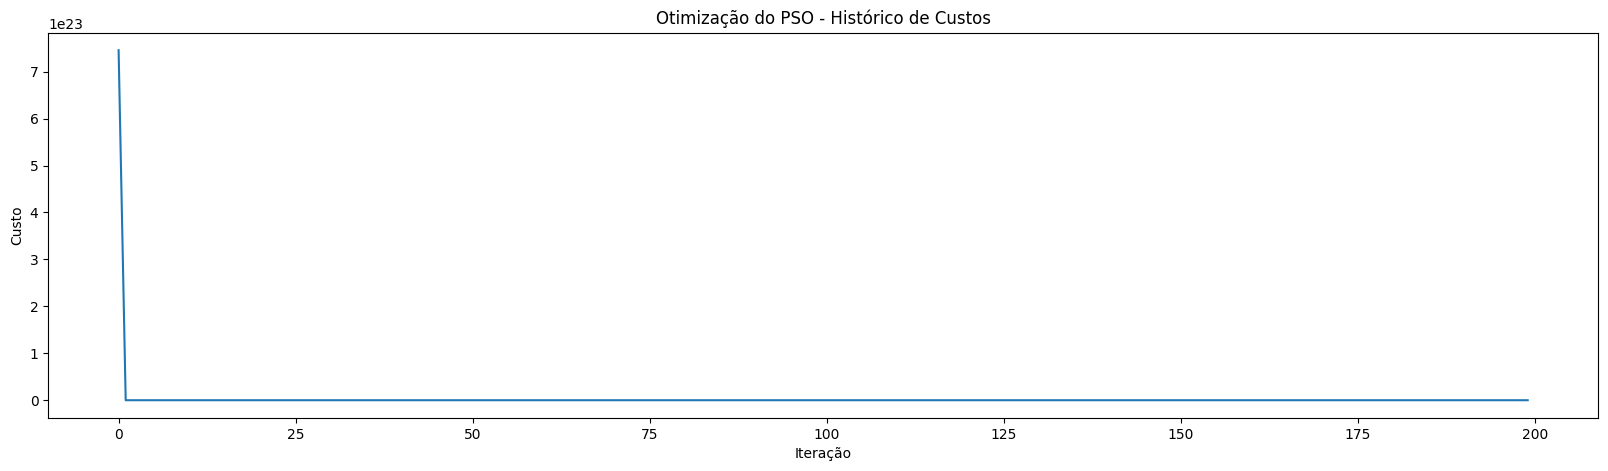

In [183]:
# Plotar gráfico de densidade da otimização
plt.figure(figsize=(20, 5))
plt.plot(optimizer.cost_history)
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.title('Otimização do PSO - Histórico de Custos')
plt.show()

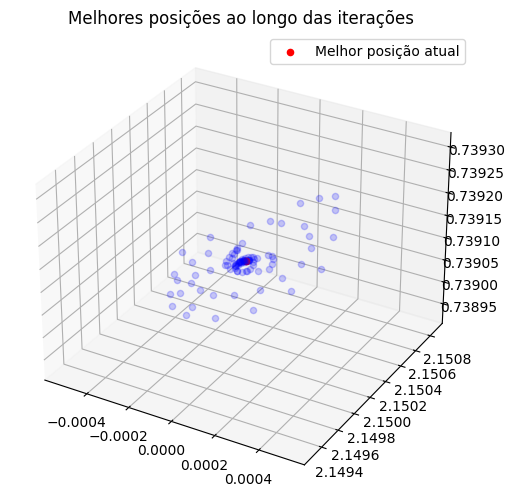

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor custo: 7948104592229407.0
Melhor custo pessoal (pbest) de cada partícula: 1.0276410528510562e+16


In [184]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")

print("Melhor custo:", best_cost)
print("Melhor custo pessoal (pbest) de cada partícula:", pbest_cost[0])